# Projet7 : Mise en place d'un modèle de scoring

## Sommaire <a class="anchor" id="0"></a>
* [0. Warnings](#1)
    * [0.1 Import zip file](#1_1)
    * [0.2 Kernel](#1_2)
    * [0.3 Nota Bene](#1_3)
    * [0.4 Info data](#1_3)
* [I. Installer environnement de travail](#2)
    * [I.1 Packages/librairies](#2_1)
    * [I.2 Palettes](#2_2)
    * [I.3 Definir env travail + extract zip file](#2_3)
* [II. Open app_train & app_test](#3)
    * [II.1 Pourcentage of test vs all (test+train)](#3_1)
* [III. EDA train+test_tables](#4)
    * [III.1 Problem of unbalanced data](#4_1)
    * [III.2 Examine Missing Values](#4_2) 
* [IV. Label Encoding and One-Hot Encoding](#5)    
* [V. Back to EDA](#6) 
* [VI. Join the all tables](#7)
* [VII. Features engineering](#8)
* [VIII. Remove missing values](#9)
* [IX. Save & load new tables](#10)
* [X. Correlations with TARGET](#11)
* [XI. Model training : 1st try](#12)
* [XII. Gestion du déséquilibre de la var TARGET](#13)
* [XIII. XIII. Gestion du déséquilibre coût métier](#14)
* [XIV. Interpretability global & local of the model_met1](#15)
* [XV. Verification of data leakage](#16)
* [XVI. Verification of data drift](#17)
* [XVII. Pipeline de déploiement continu (MLFlow)](#18)
    * [XVII.1 Load train2 & test2](#18_1)
    * [XVII.2 Pipe de transformation](#18_2)
    * [XVII.3 Modelisation & MLFlow : 1st try](#18_3)
    * [XVII.4 Pipeline de référence](#18_4)
    * [XVII.5 Improved functions](#18_5)
    * [XVII.6 Dummy_classifier model](#18_6)
    * [XVII.7 LGBM_classifier model](#18_7)
    * [XVII.8 Fonction coût métier](#18_8)
    * [XVII.9 Save model with MLFlow](#18_9)
    * [XVII.10 Feature importance](#18_10)
    * [XVII.11 Verification of data leakage](#18_11)
    * [XVII.12 Create reduced train & test datasets](#18_12)
    * [XVII.13 Global interpretation](#18_13)
    * [XVII.14 Local interpretation](#18_14)
* [XVIII. Data drift check (new saved model)](#19)
* [XIX. Preparation for API & Dashboard](#20)

# 0. Warnings <a class="anchor" id="1"></a>

#### 0.1 /!\ We need to download the zip file in the same folder of the notebook <a class="anchor" id="1_1"></a>

"Projet+Mise+en+prod+-+home-credit-default-risk.zip" https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip

#### 0.2 kernel used : Python 3.10.11 <a class="anchor" id="1_2"></a>

#### 0.3 NB : relancer à partir de train+test (ligne 138) (saved as csv) <a class="anchor" id="1_3"></a>

### 0.4 /!\ Info Data <a class="anchor" id="1_4"></a>

The data is provided by Home Credit, a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task.

There are 7 different sources of data:

    - application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
    - bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
    - bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
    - previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
    - POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
    credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
    - installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.


# I. Installer environnement de travail <a class="anchor" id="2"></a>

#### I.1 Installer packages/librairies nécessaires <a class="anchor" id="2_1"></a>

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from lightgbm import plot_importance
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.dummy import DummyClassifier

# File system manangement
import os
from os import listdir

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#others
import missingno as msno
import zipfile
from zipfile import ZipFile
import requests
import math
%matplotlib inline

# Memory management
import gc 

# shap
import shap
shap.initjs()

import joblib
import pickle

import mlflow

from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset
from evidently.metrics import *

from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset
from evidently.tests import *


from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer

from imblearn.over_sampling import SMOTE
from time import time
from collections import Counter

# ----------------------------------------------------
from lightgbm import LGBMClassifier
#from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# ----------------------------------------------------
from sklearn import metrics as met
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve

# ----------------------------------------------------------
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# ----------------------------------------------------------
import mlflow
from mlflow.models.signature import infer_signature
import joblib

# ----------------------------------------------------------
import shap

### I.2 Define own palette <a class="anchor" id="2_2"></a>

In [2]:
# palette
jaune ='#FFCA18'
rouge ='#88001B'
bleu ='#000064'
vert ='#055D00'
pink = '#FC6C85'
choco = '#4b2312'
cyan = '#00FFFF'
orange = '#FF6103'
magenta = '#FF00FF'
pastel = ['#FFE06F','#FF9594','#78CF80','#FFB178','#A7B9FF','#FDE8D8']
pastel2 = [rouge, jaune, bleu, pink, vert, choco, cyan, orange, magenta]

### I.3 Definir l'environnement de travail <a class="anchor" id="2_3"></a>

In [3]:
path_to_dir=os.path.abspath(os.getcwd())

Extract files from zip folder

In [ ]:
with zipfile.ZipFile("Projet+Mise+en+prod+-+home-credit-default-risk.zip","r") as zip_ref:
    zip_ref.extractall("targetdir")

### /!\ Define 2nd work environement

In [4]:
path_to_dir2 = f'{path_to_dir}\\targetdir'

In [5]:
# List files available
print(os.listdir(path_to_dir2))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


# II. Open app_train & app_test <a class="anchor" id="3"></a>

In [6]:
# Training data
app_train = pd.read_csv(f'{path_to_dir2}\\application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [7]:
app_train.SK_ID_CURR.nunique()

307511

Nb : each row is unique.

The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the TARGET (the label we want to predict).

#########################

In [8]:
# Testing data features
app_test = pd.read_csv(f'{path_to_dir2}\\application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [9]:
app_test.SK_ID_CURR.nunique()

48744

Nb : each row is unique.

The test set is considerably smaller and lacks a TARGET column.

### II.1 Pourcentage of test vs all (test+train) <a class="anchor" id="3_1"></a>

In [10]:
pct = app_test.SK_ID_CURR.nunique()/(app_test.SK_ID_CURR.nunique()+app_train.SK_ID_CURR.nunique())*100

In [11]:
print(f'The pct of test data is : {round(pct,2)} %.')

The pct of test data is : 13.68 %.


# III. EDA train+test_tables <a class="anchor" id="4"></a>

In [12]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [13]:
type(app_train.TARGET[0])

numpy.int64

### III.1 Problem of unbalanced data <a class="anchor" id="4_1"></a>

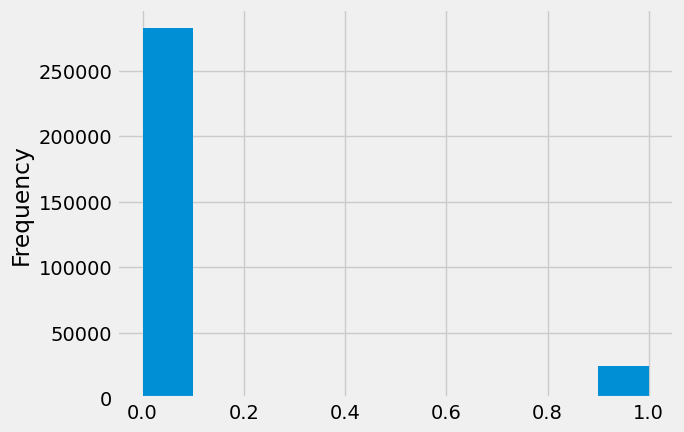

In [14]:
app_train['TARGET'].plot.hist();

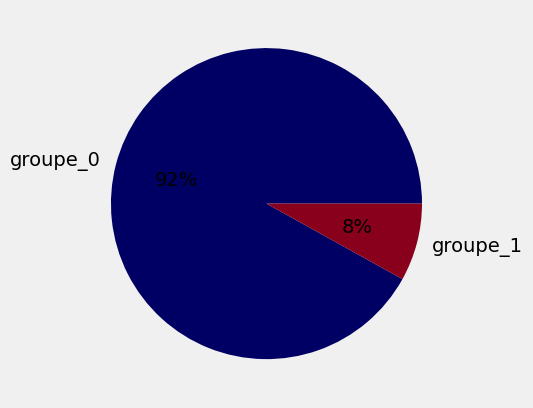

In [15]:
#create pie chart
plt.pie(x=[282686, 24825], labels = ['groupe_0', 'groupe_1'], colors = [bleu, rouge], autopct='%.0f%%')
plt.show()

Nb : From this information, we see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid.

### III.2 Examine Missing Values <a class="anchor" id="4_2"></a>

A dict to call the df

In [16]:
dico = {'app_train' : app_train, 'app_test' : app_test}

In [17]:
# Function to calculate missing values by column# Funct 
def missing_values_table(table='app_train'):
        # call df
        df = dico[table]

        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print (f"The selected dataframe '{table}' has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

Check in test or train set the missing values

In [18]:
# Missing values statistics
missing_values = missing_values_table('app_train')
missing_values.head(10)

The selected dataframe 'app_train' has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4

## Column types

In [19]:
# Number of each type of column
app_train.dtypes.value_counts(), app_test.dtypes.value_counts()

(float64    65
 int64      41
 object     16
 Name: count, dtype: int64,
 float64    65
 int64      40
 object     16
 Name: count, dtype: int64)

In [20]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [21]:
app_test.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

# IV. Label Encoding and One-Hot Encoding <a class="anchor" id="5"></a>

[See summary](#0)

In [22]:
app_test2 = app_test.copy()
app_train2 = app_train.copy()

In [23]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train2:
    if app_train2[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train2[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train2[col])
            # Transform both training and testing data
            app_train2[col] = le.transform(app_train2[col])
            app_test2[col] = le.transform(app_test2[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [24]:
# one-hot encoding of categorical variables
app_train2 = pd.get_dummies(app_train2)
app_test2 = pd.get_dummies(app_test2)

print('Training Features shape: ', app_train2.shape)
print('Testing Features shape: ', app_test2.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [ ]:
app_train.shape, app_train2.shape

## Align train & test tables

In [25]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


# V. Back to EDA <a class="anchor" id="6"></a>

[See Summary](#0)

## V.1 Check anomalies

The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:

In [26]:
(app_train2['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?

In [27]:
app_train2['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

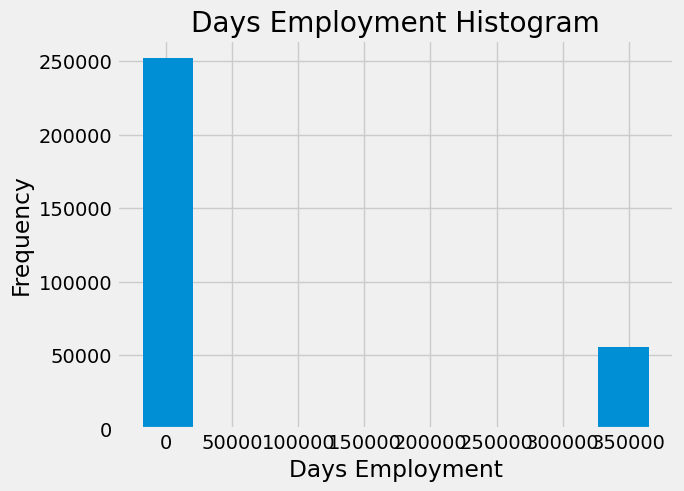

In [28]:
app_train2['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');



Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.


In [29]:
anom = app_train2[app_train2['DAYS_EMPLOYED'] == 365243]
non_anom = app_train2[app_train2['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment




Well that is extremely interesting! It turns out that the anomalies have a lower rate of default.

In [30]:
app_train3 = app_train2.copy()
app_test3 = app_test2.copy()

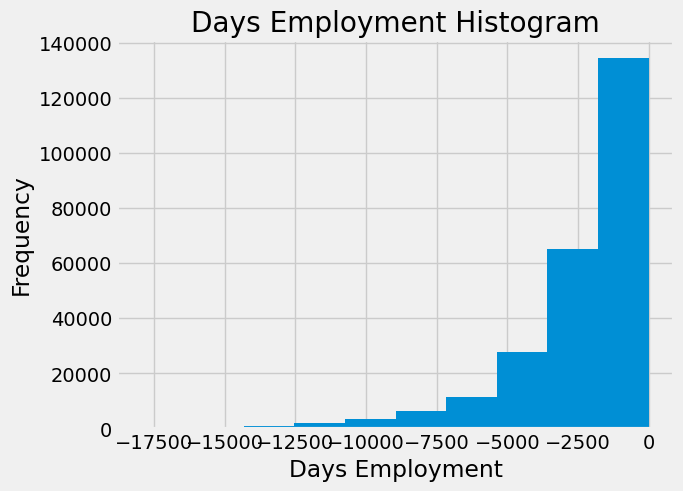

In [31]:
# Create an anomalous flag column
app_train3['DAYS_EMPLOYED_ANOM'] = app_train3["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train3['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train3['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [32]:
app_train3.DAYS_EMPLOYED_ANOM.value_counts()

DAYS_EMPLOYED_ANOM
False    252137
True      55374
Name: count, dtype: int64

As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with np.nan in the testing data.

In [33]:
app_test3['DAYS_EMPLOYED_ANOM'] = app_test3["DAYS_EMPLOYED"] == 365243
app_test3["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test3["DAYS_EMPLOYED_ANOM"].sum(), len(app_test3)))

There are 9274 anomalies in the test data out of 48744 entries


## V.2 Correlations

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

    .00-.19 “very weak”
    .20-.39 “weak”
    .40-.59 “moderate”
    .60-.79 “strong”
    .80-1.0 “very strong”

In [ ]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))



## Effect of Age on Repayment¶

In [35]:
# Find the correlation of the positive days since birth and target
app_train3['DAYS_BIRTH'] = abs(app_train3['DAYS_BIRTH'])
app_train3['DAYS_BIRTH'].corr(app_train3['TARGET'])

-0.0782393083098269



As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

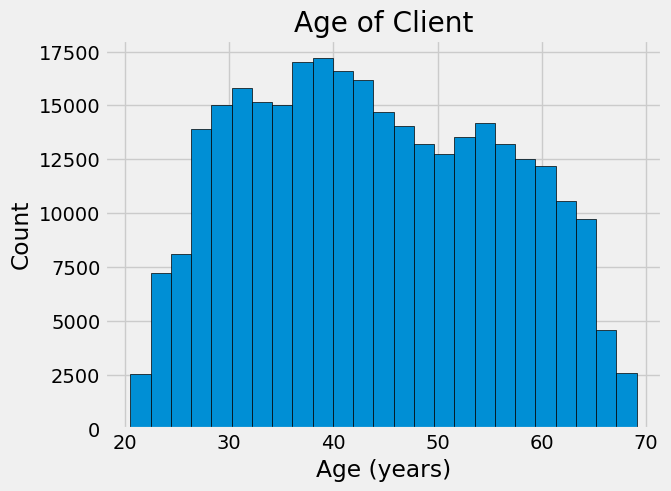

In [36]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train3['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target.

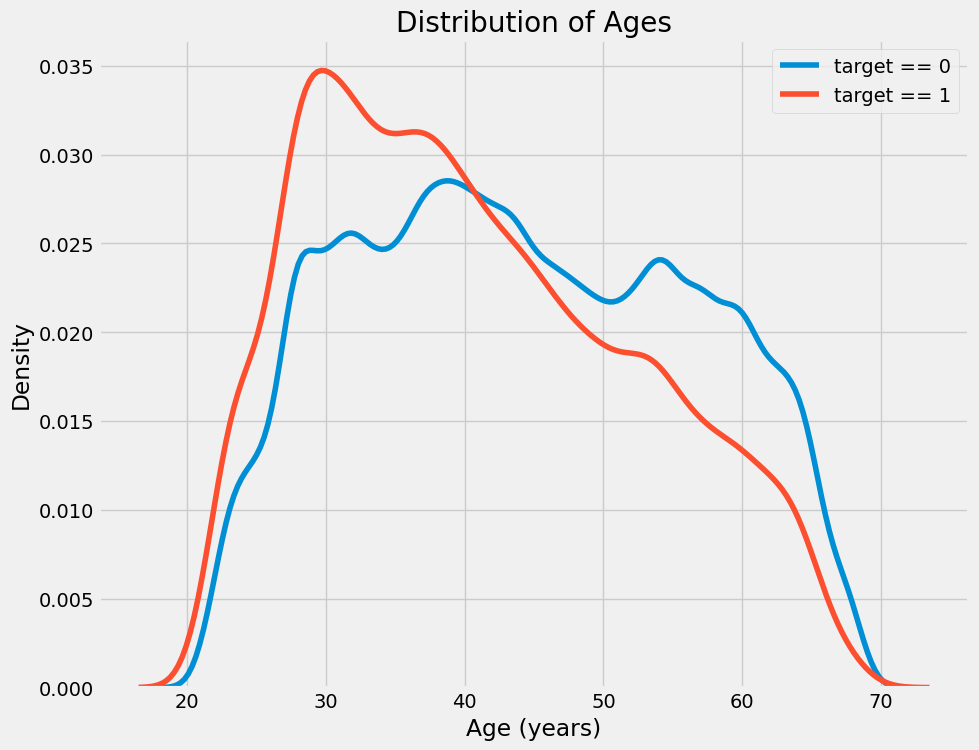

In [37]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train3.loc[app_train3['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train3.loc[app_train3['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages'); plt.legend();



The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.


In [38]:
# Age information into a separate dataframe
age_data = app_train3[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [39]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

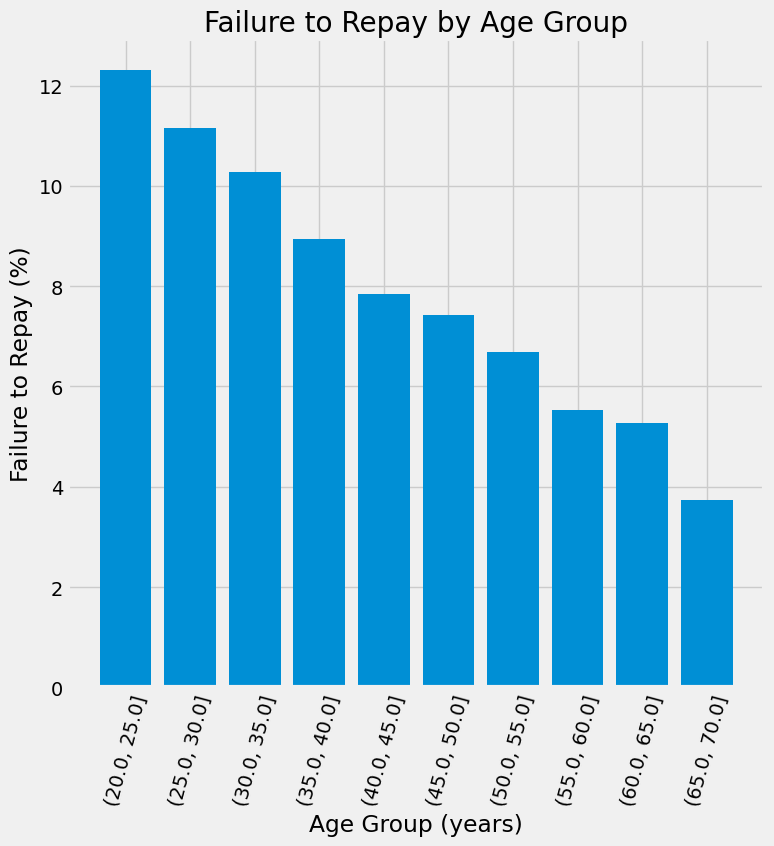

In [40]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

# /!\ 

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.


## Exterior Sources

The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

In [41]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train3[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

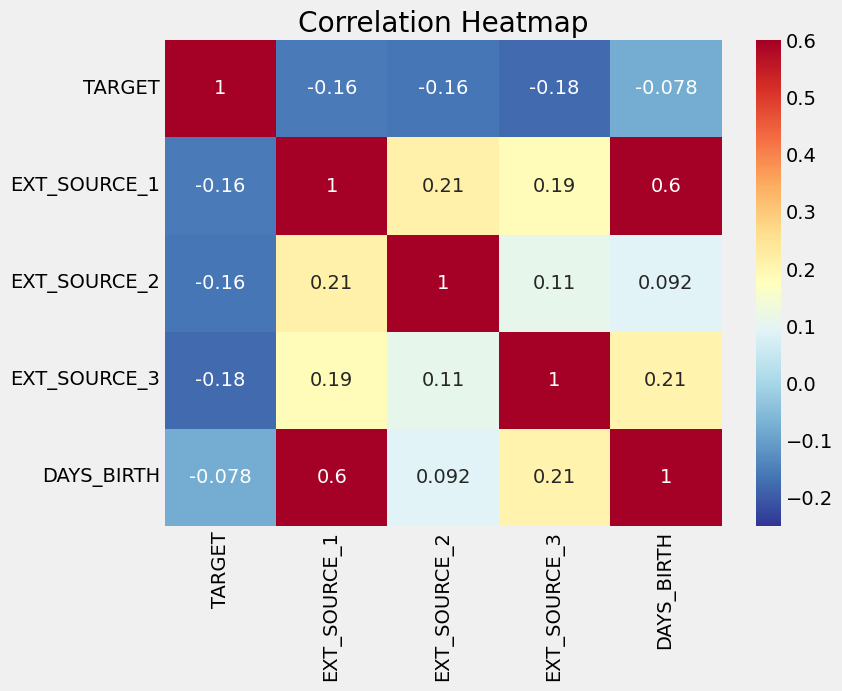

In [42]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');



All three EXT_SOURCE featureshave negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.


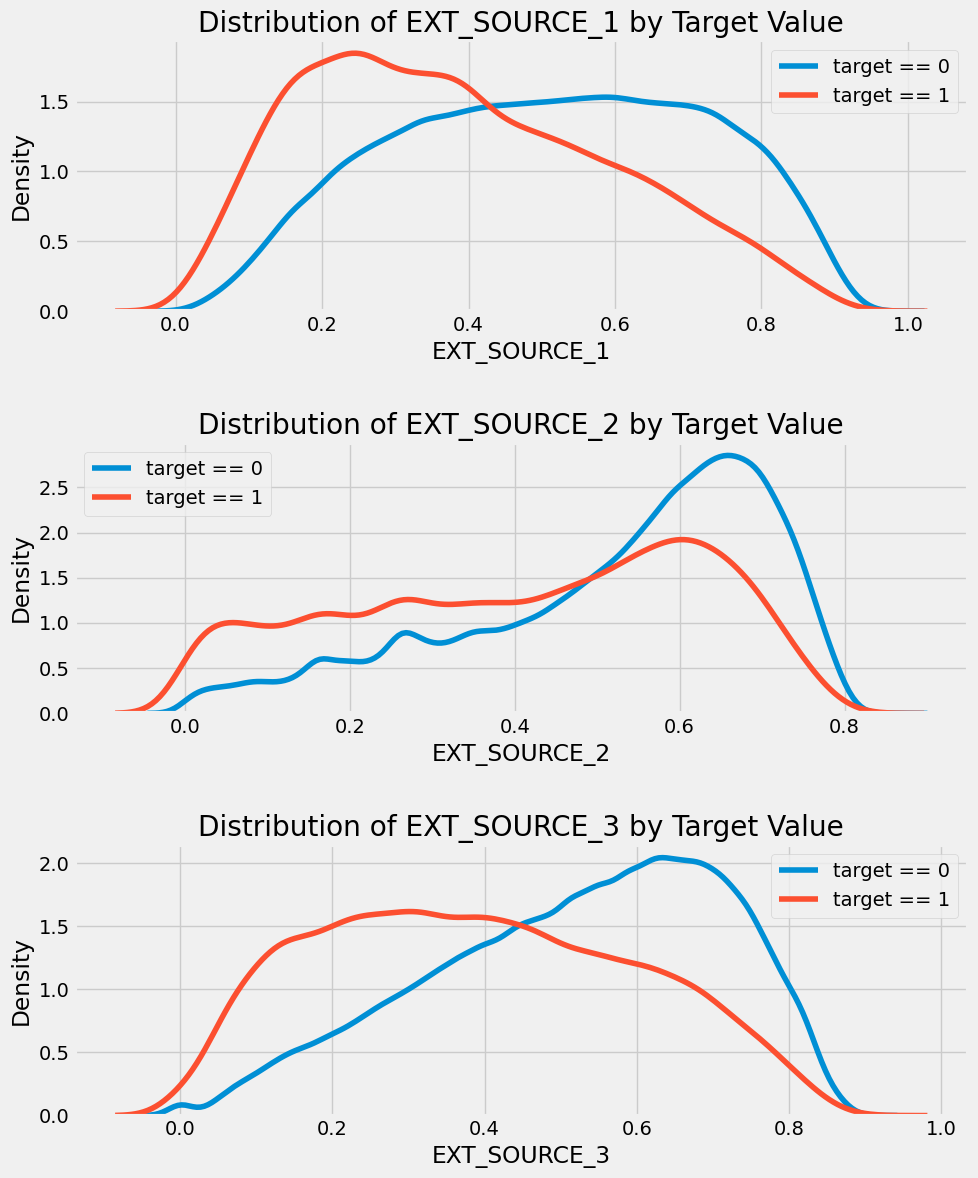

In [43]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train3.loc[app_train3['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train3.loc[app_train3['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density')
    plt.legend();
    
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

# VI. JOIN ALL TABLES <a class="anchor" id="7"></a>

[See Summary](#0)

### VI. 1. Concat train+test tables

In [44]:
app_test4 = app_test3.copy()

In [45]:
app_test4.insert(1, 'TARGET', np.nan)

In [46]:
app_test4.head(3)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100001     NaN                   0             0                1   
1      100005     NaN                   0             0                1   
2      100013     NaN                   0             1                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   

   ...  WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0  ...                     False                     False   
1  ...                     False                     False   
2  ...                     False                     False   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                          False                      False   
1                          False                      False   
2                          False                      False   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                     False                             True   
1                     False                            False   
2                     False                            False   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  \
0                      False                    True                    False   
1                      False                   False                    False   
2                      False                   False                    False   

   DAYS_EMPLOYED_ANOM  
0               False  
1               False  
2               False  

[3 rows x 241 columns]

In [47]:
app_test4.TARGET.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: TARGET, dtype: float64

In [48]:
app_train3.head(3)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002       1                   0             0                1   
1      100003       0                   0             0                0   
2      100004       0                   1             1                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   

   ...  WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0  ...                     False                     False   
1  ...                      True                     False   
2  ...                     False                     False   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                          False                      False   
1                          False                      False   
2                          False                      False   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                     False                             True   
1                     False                            False   
2                     False                            False   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  \
0                      False                    True                    False   
1                      False                    True                    False   
2                      False                   False                    False   

   DAYS_EMPLOYED_ANOM  
0               False  
1               False  
2               False  

[3 rows x 244 columns]

In [55]:
#df = app_train3.append(app_test4)
df = pd.concat([app_train3, app_test4], ignore_index=True)

In [56]:
df.head(3)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0                   0             0                1   
1      100003     0.0                   0             0                0   
2      100004     0.0                   1             1                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   

   ...  WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0  ...                     False                     False   
1  ...                      True                     False   
2  ...                     False                     False   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                          False                      False   
1                          False                      False   
2                          False                      False   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                     False                             True   
1                     False                            False   
2                     False                            False   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  \
0                      False                    True                    False   
1                      False                    True                    False   
2                      False                   False                    False   

   DAYS_EMPLOYED_ANOM  
0               False  
1               False  
2               False  

[3 rows x 244 columns]

In [57]:
df.TARGET.describe()

count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64

In [58]:
df.shape, app_train3.shape

((356255, 244), (307511, 244))

<AxesSubplot: >

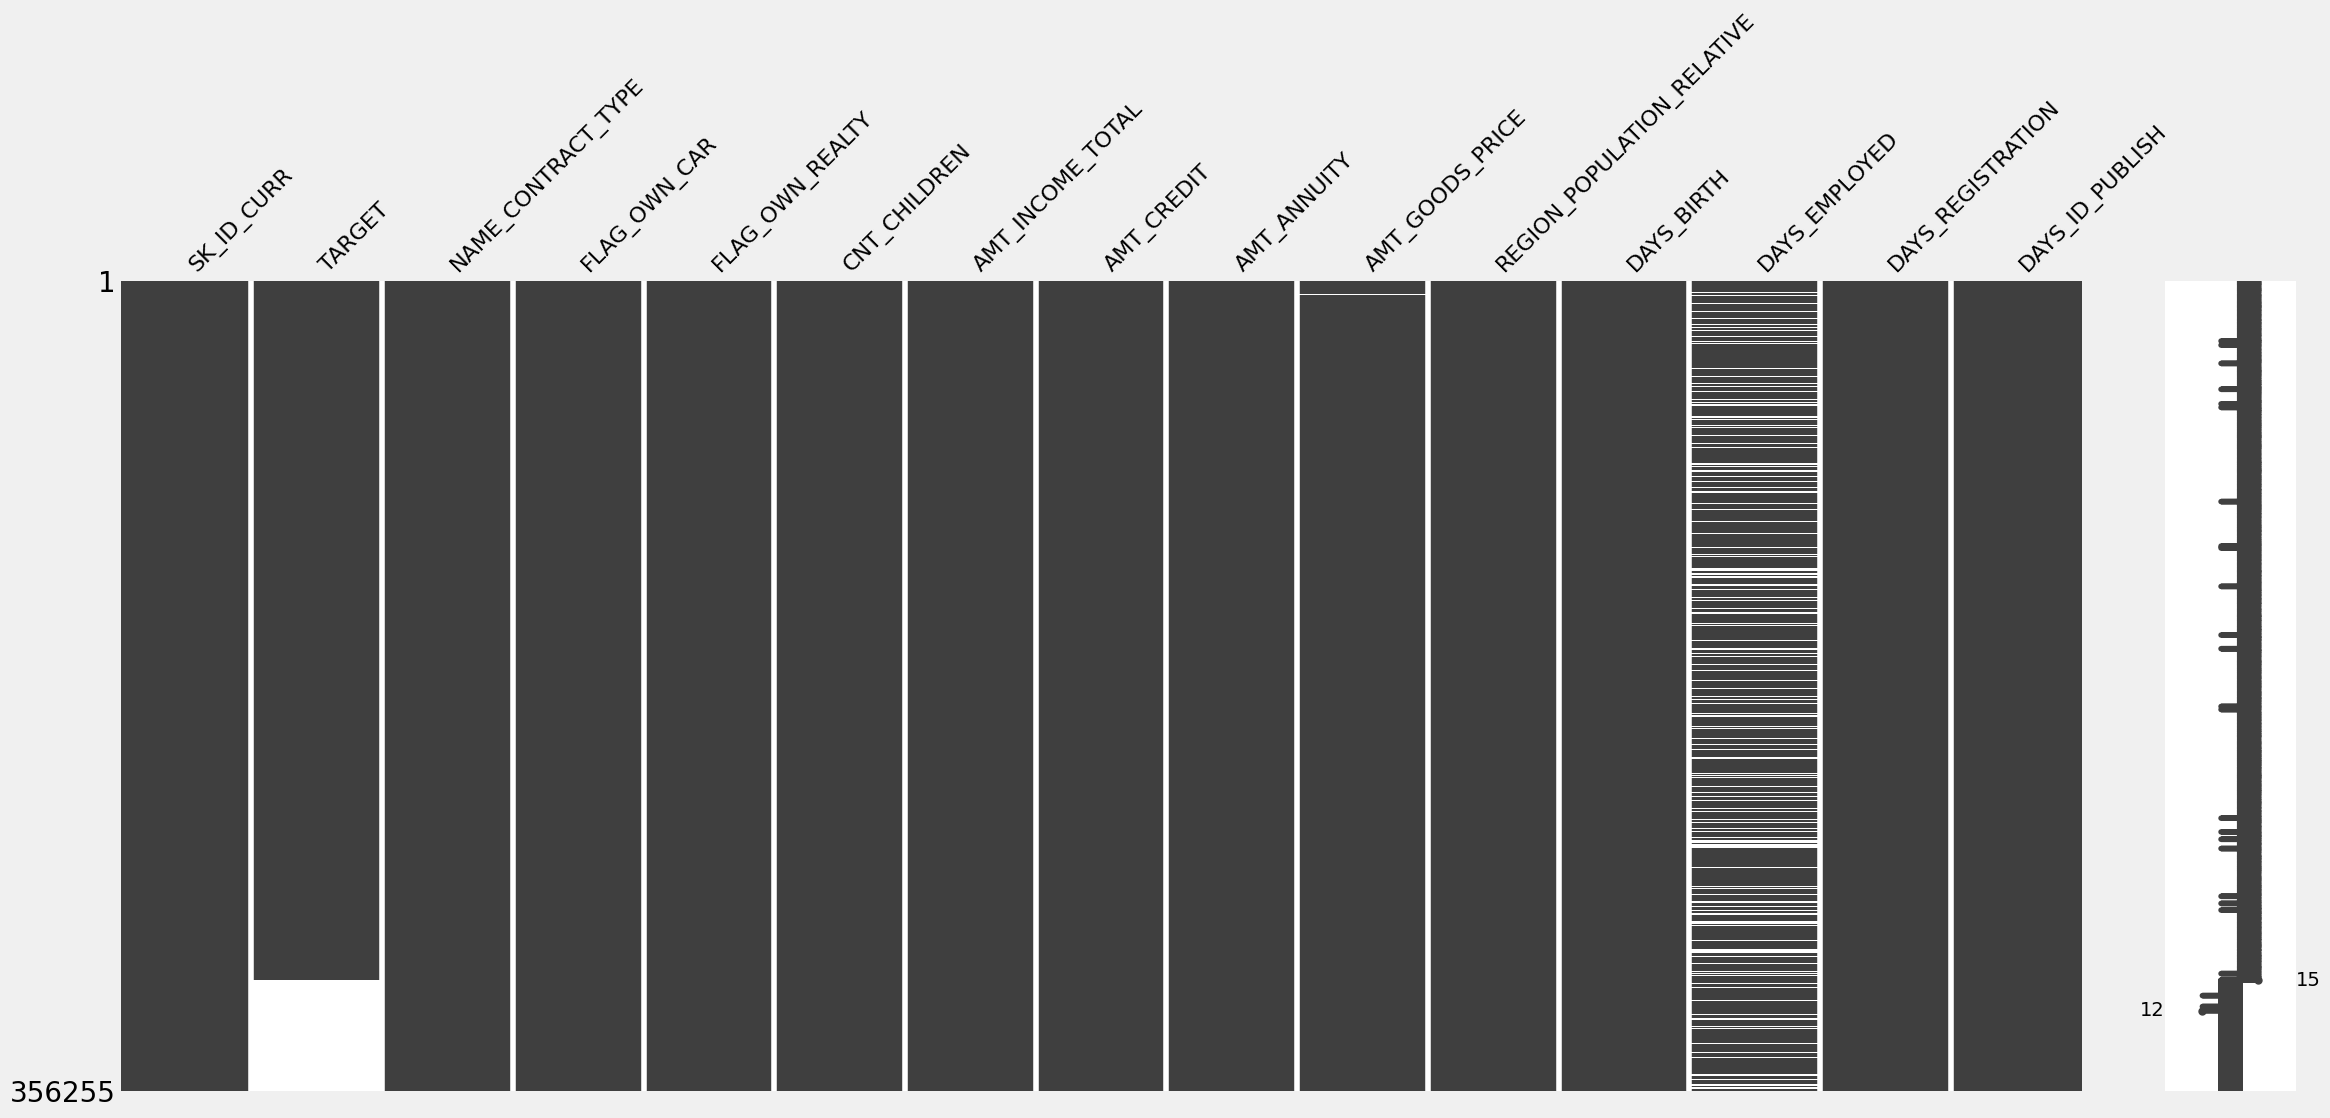

In [59]:
msno.matrix(df.iloc[:,:15])

In [60]:
df.tail(3)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
356252      456223     NaN                   0             1                1   
356253      456224     NaN                   0             0                0   
356254      456250     NaN                   0             1                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
356252             1          202500.0    315000.0      33205.5   
356253             0          225000.0    450000.0      25128.0   
356254             0          135000.0    312768.0      24709.5   

        AMT_GOODS_PRICE  ...  WALLSMATERIAL_MODE_Block  \
356252         315000.0  ...                     False   
356253         450000.0  ...                     False   
356254         270000.0  ...                     False   

        WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic  \
356252                     False                          False   
356253                     False                          False   
356254                     False                          False   

        WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
356252                      False                     False   
356253                      False                      True   
356254                      False                     False   

        WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
356252                             True                      False   
356253                            False                      False   
356254                            False                      False   

        EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  DAYS_EMPLOYED_ANOM  
356252                    True                    False               False  
356253                    True                    False               False  
356254                   False                    False               False  

[3 rows x 244 columns]

In [61]:
df = df.reset_index(drop=True)

In [62]:
df.head(3)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0                   0             0                1   
1      100003     0.0                   0             0                0   
2      100004     0.0                   1             1                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   

   ...  WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0  ...                     False                     False   
1  ...                      True                     False   
2  ...                     False                     False   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                          False                      False   
1                          False                      False   
2                          False                      False   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                     False                             True   
1                     False                            False   
2                     False                            False   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  \
0                      False                    True                    False   
1                      False                    True                    False   
2                      False                   False                    False   

   DAYS_EMPLOYED_ANOM  
0               False  
1               False  
2               False  

[3 rows x 244 columns]

In [63]:
df.columns.sort_values()[20:80]

Index(['CODE_GENDER_XNA', 'COMMONAREA_AVG', 'COMMONAREA_MEDI',
       'COMMONAREA_MODE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_ANOM',
       'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'ELEVATORS_AVG',
       'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'ENTRANCES_AVG', 'ENTRANCES_MEDI',
       'ENTRANCES_MODE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL',
       'FLAG_EMP_PH

In [64]:
df.CODE_GENDER_XNA.value_counts()

CODE_GENDER_XNA
False    307507
True          4
Name: count, dtype: int64

In [65]:
df.CODE_GENDER_XNA.isna().sum()

48744

### Drop rows if Gender_XNA ==1

In [66]:
df2 = df[df.CODE_GENDER_XNA != 1]

In [67]:
df2.shape, df.shape

((356251, 244), (356255, 244))

In [68]:
df2 = df2.drop(columns=['CODE_GENDER_XNA'])

In [69]:
df2.FLAG_OWN_CAR.describe()

count    356251.000000
mean          0.339699
std           0.473608
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: FLAG_OWN_CAR, dtype: float64

In [70]:
df2.FLAG_OWN_CAR.value_counts()

FLAG_OWN_CAR
0    235233
1    121018
Name: count, dtype: int64

In [71]:
df2.FLAG_OWN_REALTY.value_counts()

FLAG_OWN_REALTY
1    246966
0    109285
Name: count, dtype: int64

############

## VI.2 Read all csv files

In [72]:
os.listdir(path_to_dir2)

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

## /!\ un dico pour stocker tous les df!

In [73]:
dico2 = {}
for elt in os.listdir(path_to_dir2)[2:]:
    dico2[elt.split('.')[0]] = pd.read_csv(path_to_dir2+'\\'+elt, encoding= 'unicode_escape')

#df5.shape #a quel point ils sont endetés => HomeCredit_columns_description.csv'

agg moy, min, max, median, sd = bureau

previous appl => agg

### VI.2.A Bureau

In [74]:
dico2.keys()

dict_keys(['bureau', 'bureau_balance', 'credit_card_balance', 'HomeCredit_columns_description', 'installments_payments', 'POS_CASH_balance', 'previous_application', 'sample_submission'])

In [75]:
dico2['bureau'].head(3)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN

### Groupby the client id (SK_ID_CURR), aggregation statistics

In [ ]:
bureau_agg = dico2['bureau'].drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head(5)

In [ ]:
bureau_agg.shape

We need to create new names for each of these columns. The following code makes new names by appending the stat to the name. Here we have to deal with the fact that the dataframe has a multi-level index. I find these confusing and hard to work with, so I try to reduce to a single level index as quickly as possible.

In [ ]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [ ]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

### Join

In [ ]:
# Join to the training dataframe
df3 = df2.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')


In [ ]:
df3.head()

### Correlations of Aggregated Values with Target

In [ ]:
# List of new correlations
new_corrs = []

# Iterate through the columns 
for col in columns:
    # Calculate correlation with the target
    corr = df3['TARGET'].corr(df3[col])
    
    # Append the list as a tuple

    new_corrs.append((col, corr))

In [ ]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:20]

Viz most correl var

In [ ]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

In [ ]:
kde_target('bureau_DAYS_CREDIT_mean', df3)

Create an automatic fct


Function for Numeric Aggregations

In [ ]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [ ]:
bureau_agg_new = agg_numeric(dico2['bureau'].drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

In [ ]:
#compared to:
bureau_agg.head()

Correlation Function

In [ ]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

In [ ]:
dico2['bureau'].head()

### Function to Handle Categorical Variables

To make the code more efficient, we can now write a function to handle the categorical variables for us. This will take the same form as the agg_numeric function in that it accepts a dataframe and a grouping variable. Then it will calculate the counts and normalized counts of each category for all categorical variables in the dataframe.

In [ ]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [ ]:
bureau_counts = count_categorical(dico2['bureau'], group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

### Join

In [ ]:
# Join to the training dataframe
df3 = df3.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

In [ ]:
df3.shape

#############


Applying Operations to another dataframe <br>

We will now turn to the bureau balance dataframe. This dataframe has monthly information about each client's previous loan(s) with other financial institutions. Instead of grouping this dataframe by the SK_ID_CURR which is the client id, we will first group the dataframe by the SK_ID_BUREAU which is the id of the previous loan. This will give us one row of the dataframe for each loan. Then, we can group by the SK_ID_CURR and calculate the aggregations across the loans of each client. The final result will be a dataframe with one row for each client, with stats calculated for their loans.


### V.2.B Bureau_balance

In [ ]:
dico2.keys()

In [ ]:
dico2['bureau_balance'].head()

In [ ]:

# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(dico2['bureau_balance'], group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

In [ ]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(dico2['bureau_balance'], group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

The above dataframes have the calculations done on each loan. Now we need to aggregate these for each client. We can do this by merging the dataframes together first and then since all the variables are numeric, we just need to aggregate the statistics again, this time grouping by the SK_ID_CURR.

In [ ]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(dico2['bureau'][['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

In [ ]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

### Join

In [ ]:
df4 = df3.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [ ]:
df4.shape, df3.shape, df2.shape

###############

### V.2.C Previous application

In [ ]:
dico2.keys()

In [ ]:
dico2['previous_application'].head(3)

### Function to Convert Data Types

This will help reduce memory usage by using more efficient types for the variables. For example category is often a better type than object (unless the number of unique categories is close to the number of rows in the dataframe).

In [ ]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [ ]:
previous = convert_types(dico2['previous_application'], print_info=True)
previous.head()

In [ ]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

In [ ]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [ ]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(dico2['previous_application'], 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

### Join

In [ ]:
df5 = df4.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
df5 = df5.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

In [ ]:
# Remove variables to free memory
gc.enable()
#del previous, previous_agg, previous_counts, 
del age_data, anom, app_test, app_test2, app_test3,
app_test4, app_train, app_train2, app_train3, bureau_agg, bureau_agg_new, df, dico, ext_data, non_anom
gc.collect()

### V.2.D Monthly Cash Data


In [ ]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, group_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [ ]:
dico2.keys()

In [ ]:
cash = convert_types(dico2['POS_CASH_balance'], print_info=True)
cash.head()

In [ ]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

In [ ]:
len(cash_by_client.columns), len(set(cash_by_client.columns))

In [ ]:
print('Cash by Client Shape: ', cash_by_client.shape)
df6 = df5.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

########

### V.2.E Installment Payments

In [ ]:
dico2.keys()

In [ ]:
installments = convert_types(dico2['installments_payments'], print_info = True)
installments.head()

In [ ]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

In [ ]:
print('Installments by client shape: ', installments_by_client.shape)

df7 = df6.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

In [ ]:
df7.info()

###########

# VII. Features engineering <a class="anchor" id="8"></a>

[See Summary](#0)

In [ ]:
dico2.keys()

In [ ]:
def features_engineering(df=df7):
    ### main table #####
    # general cleaning procedures
    #df = df[df['CODE_GENDER'] != 'XNA']
    df = df[df['AMT_INCOME_TOTAL'] < 20000000] # remove a outlier 117M
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True) # set null value
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True) # set null value

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']: #['CODE_GENDER', 
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    
    # Categorical features with One-Hot encode
    #df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)

    def get_age_label(days_birth):
        """ Return the age group label (int). """
        age_years = -days_birth / 365
        if age_years < 27: return 1
        elif age_years < 40: return 2
        elif age_years < 50: return 3
        elif age_years < 65: return 4
        elif age_years < 99: return 5
        else: return 0
    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))
    
    # New features based on External sources
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
    np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # Credit ratios
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    
    # Income ratios
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    
    # Time ratios
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

    # EXT_SOURCE_X FEATURE
    df['APPS_EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['APPS_EXT_SOURCE_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['APPS_EXT_SOURCE_STD'] = df['APPS_EXT_SOURCE_STD'].fillna(df['APPS_EXT_SOURCE_STD'].mean())
    df['APP_SCORE1_TO_BIRTH_RATIO'] = df['EXT_SOURCE_1'] / (df['DAYS_BIRTH'] / 365.25)
    df['APP_SCORE2_TO_BIRTH_RATIO'] = df['EXT_SOURCE_2'] / (df['DAYS_BIRTH'] / 365.25)
    df['APP_SCORE3_TO_BIRTH_RATIO'] = df['EXT_SOURCE_3'] / (df['DAYS_BIRTH'] / 365.25)
    df['APP_SCORE1_TO_EMPLOY_RATIO'] = df['EXT_SOURCE_1'] / (df['DAYS_EMPLOYED'] / 365.25)
    df['APP_EXT_SOURCE_2*EXT_SOURCE_3*DAYS_BIRTH'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['DAYS_BIRTH']
    df['APP_SCORE1_TO_FAM_CNT_RATIO'] = df['EXT_SOURCE_1'] / df['CNT_FAM_MEMBERS']
    df['APP_SCORE1_TO_GOODS_RATIO'] = df['EXT_SOURCE_1'] / df['AMT_GOODS_PRICE']
    df['APP_SCORE1_TO_CREDIT_RATIO'] = df['EXT_SOURCE_1'] / df['AMT_CREDIT']
    df['APP_SCORE1_TO_SCORE2_RATIO'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_2']
    df['APP_SCORE1_TO_SCORE3_RATIO'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_3']
    df['APP_SCORE2_TO_CREDIT_RATIO'] = df['EXT_SOURCE_2'] / df['AMT_CREDIT']
    df['APP_SCORE2_TO_REGION_RATING_RATIO'] = df['EXT_SOURCE_2'] / df['REGION_RATING_CLIENT']
    df['APP_SCORE2_TO_CITY_RATING_RATIO'] = df['EXT_SOURCE_2'] / df['REGION_RATING_CLIENT_W_CITY']
    df['APP_SCORE2_TO_POP_RATIO'] = df['EXT_SOURCE_2'] / df['REGION_POPULATION_RELATIVE']
    df['APP_SCORE2_TO_PHONE_CHANGE_RATIO'] = df['EXT_SOURCE_2'] / df['DAYS_LAST_PHONE_CHANGE']
    df['APP_EXT_SOURCE_1*EXT_SOURCE_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
    df['APP_EXT_SOURCE_1*EXT_SOURCE_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']
    df['APP_EXT_SOURCE_2*EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['APP_EXT_SOURCE_1*DAYS_EMPLOYED'] = df['EXT_SOURCE_1'] * df['DAYS_EMPLOYED']
    df['APP_EXT_SOURCE_2*DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] * df['DAYS_EMPLOYED']
    df['APP_EXT_SOURCE_3*DAYS_EMPLOYED'] = df['EXT_SOURCE_3'] * df['DAYS_EMPLOYED']

    # AMT_INCOME_TOTAL : income
    # CNT_FAM_MEMBERS  : the number of family members
    df['APPS_GOODS_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']
    df['APPS_CNT_FAM_INCOME_RATIO'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH : Client's age in days at the time of application
    # DAYS_EMPLOYED : How many days before the application the person started current employment
    df['APPS_INCOME_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']

    # other feature from better than 0.8
    df['CREDIT_TO_GOODS_RATIO_2'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['APP_AMT_INCOME_TOTAL_12_AMT_ANNUITY_ratio'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
    df['APP_INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['APP_DAYS_EMPLOYED_DAYS_BIRTH_diff'] = df['DAYS_EMPLOYED'] - df['DAYS_BIRTH']

    return df

In [ ]:
df7a = features_engineering()

In [ ]:
df7a.shape, df7.shape

# VIII. Remove missing values <a class="anchor" id="9"></a>

[See Summary](#0)

### Function to Calculate Missing Values

In [ ]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df, print_info = False):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        if print_info:
            # Print some summary information
            print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [ ]:
def split(df=df7):
    train = df[df.TARGET.notna()]
    test = df[df.TARGET.isna()]
    return train, test

## /!\ J'utilise df7a qui correspond au df7 avec du feature engineering

In [ ]:
train, test = split(df=df7a)

In [ ]:
df7.head(3)

In [ ]:
train.shape, test.shape

In [ ]:
test = test.drop(columns=['TARGET'])

Remove missing columns

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
train.head(3)

In [ ]:
test.head(3)

In [ ]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

In [ ]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [ ]:
print(f'Final training size: {return_size(train)}')
print(f'Final testing size: {return_size(test)}')

# IX. Save + Load new tables <a class="anchor" id="10"></a>

<br> /!\ reload train & test datasets

[See Summary](#0)

In [ ]:
train.to_csv('train_previous_raw.csv', index = False, chunksize = 500) #5min
test.to_csv('test_previous_raw.csv', index = False)

### /!\ relancer ici train et test au lieu de relancer tout le reste

In [78]:
train = pd.read_csv('train_previous_raw.csv') 
test = pd.read_csv('test_previous_raw.csv') #1min7s en tout

In [79]:
test.shape, train.shape

((48744, 1243), (307506, 1244))

# X. Correlation with TARGET <a class="anchor" id="11"></a>

[See Summary](#0)

In [80]:
len(train.columns)

1244

In [81]:
def correl(table=train, max_numbers=50):# List of new correlations
    new_corrs = []

# Iterate through the columns 
    for col in table.columns[2:]:
    # Calculate correlation with the target
        corr = table['TARGET'].corr(table[col])
    # Append the list as a tuple
        new_corrs.append((col, corr))

# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
    _df = pd.DataFrame(new_corrs, columns=['Column', 'Correlation'])
    _df['Correl_abs'] = _df['Correlation'].apply(lambda x : abs(x))
    _df = _df.sort_values(by=['Correl_abs'], ascending=False)
    #new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = False)
    return _df[:max_numbers]

In [82]:
_df = correl(max_numbers=800) #11s

In [83]:
_df.head(10)

Column  Correlation  Correl_abs
1193           EXT_SOURCES_WEIGHTED    -0.230532    0.230532
1211           APPS_EXT_SOURCE_MEAN    -0.222040    0.222040
1196               EXT_SOURCES_MEAN    -0.222040    0.222040
1197          EXT_SOURCES_NANMEDIAN    -0.218100    0.218100
1230  APP_EXT_SOURCE_2*EXT_SOURCE_3    -0.199474    0.199474
1195                EXT_SOURCES_MAX    -0.196870    0.196870
1192               EXT_SOURCES_PROD    -0.188527    0.188527
1229  APP_EXT_SOURCE_1*EXT_SOURCE_3    -0.187810    0.187810
1194                EXT_SOURCES_MIN    -0.185258    0.185258
32                     EXT_SOURCE_3    -0.178906    0.178906

# XI. Model training : 1st try <a class="anchor" id="12"></a>

In [84]:
def model(features, test_features, encoding = 'ohe', n_folds = 5, numbers=800, Model='LGB1'):
    
    dico={'LGB1' : lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
                                   ,
        'LGB2' : lgb.LGBMClassifier(nthread=-1,
                            #device_type='gpu',
                            n_estimators=5000,
                            learning_rate=0.01,
                            max_depth=11,
                            num_leaves=58,
                            colsample_bytree=0.613,
                            subsample=0.708,
                            max_bin=407,
                            reg_alpha=3.564,
                            reg_lambda=4.930,
                            min_child_weight=6,
                            min_child_samples=165,
                            #keep_training_booster=True,
                            silent=-1,
                            verbose=-1) 
        }

    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    _df = correl(max_numbers=numbers)
    to_keep = ['SK_ID_CURR', 'TARGET']
    for elt in list(_df.Column):
        to_keep.append(elt)

    ## Reduce train & test 
    features = features.drop(columns=[ele for ele in features.columns if ele not in to_keep]).reset_index(drop=True)
    test_features = test_features.drop(columns=[ele for ele in test_features.columns if ele not in to_keep]).reset_index(drop=True)
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        #model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
         #                          class_weight = 'balanced', learning_rate = 0.05, 
          #                         reg_alpha = 0.1, reg_lambda = 0.1, 
           #                        subsample = 0.8, n_jobs = -1, random_state = 50)
        model = dico[Model]
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Confusion matrix
    cm = pd.DataFrame({'SK_ID_CURR': train_ids, 'TARGET': labels, 'PREDICT' : out_of_fold})
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    #plot_importance(model, figsize=(16, 32), max_num_features=max_feat)
    return submission, feature_importances, metrics, cm, model

### A relancer si besoin

In [ ]:
submission, fi, metrics, cm, md = model(features=train, test_features=test) #7min41 = 500 most correl var
#800 most correl var = 17min41s

Training Data Shape:  (307506, 800)
Testing Data Shape:  (48744, 800)
[200]	train's auc: 0.833106	train's binary_logloss: 0.510419	valid's auc: 0.780568	valid's binary_logloss: 0.474765
[200]	train's auc: 0.832353	train's binary_logloss: 0.511115	valid's auc: 0.78383	valid's binary_logloss: 0.476317
[400]	train's auc: 0.870228	train's binary_logloss: 0.468657	valid's auc: 0.785565	valid's binary_logloss: 0.452563
[200]	train's auc: 0.83311	train's binary_logloss: 0.510302	valid's auc: 0.777884	valid's binary_logloss: 0.46921
[400]	train's auc: 0.870567	train's binary_logloss: 0.467705	valid's auc: 0.778975	valid's binary_logloss: 0.44645
[600]	train's auc: 0.898207	train's binary_logloss: 0.433608	valid's auc: 0.779195	valid's binary_logloss: 0.42704
[200]	train's auc: 0.83187	train's binary_logloss: 0.51191	valid's auc: 0.784599	valid's binary_logloss: 0.469076
[200]	train's auc: 0.833464	train's binary_logloss: 0.509989	valid's auc: 0.777224	valid's binary_logloss: 0.472506
[400]	train's auc: 0.870941	train's binary_logloss: 0.467467	valid's auc: 0.778424	valid's binary_logloss: 0.450023
[600]	train's auc: 0.898766	train's binary_logloss: 0.432966	valid's auc: 0.77838	valid's binary_logloss: 0.431421

In [ ]:
fi.to_csv('Features_importance.csv', index=False)

In [ ]:
print('Baseline metrics')
print(metrics)

Baseline metrics
      fold     train     valid
0        0  0.853471  0.781384
1        1  0.883903  0.785861
2        2  0.895330  0.779584
3        3  0.845924  0.785326
4        4  0.889274  0.779006
5  overall  0.873581  0.784248

In [ ]:
submission.to_csv('submission_manualp2_feat.csv', index = False)

In [ ]:
cm.to_csv('confusion_matrix.csv', index = False)

In [ ]:
#cm = pd.read_csv('confusion_matrix.csv')

In [ ]:
cm.head(10)

In [ ]:
sns.histplot(cm.PREDICT, kde=True, log_scale=False)

In [ ]:
sns.boxplot(data=cm, x='TARGET', y='PREDICT')

In [ ]:
cm.PREDICT = cm.PREDICT.apply(lambda x : 1 if x > 0.5 else 0)

In [ ]:
cm.TARGET = cm.TARGET.apply(lambda x : int(x))

In [ ]:
train.TARGET.value_counts()

In [ ]:

cm = confusion_matrix(cm.TARGET, cm.PREDICT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=['0','1'])
disp.plot()
plt.show()

In [ ]:
#plot_importance(md, figsize=(16, 32), max_num_features=100)

# XII. Gestion du déséquilibre de la var TARGET <a class="anchor" id="13"></a>

In [ ]:
gc.enable()
del submission, fi, metrics, cm, md
gc.collect()

In [ ]:
y_train = np.array(train['TARGET'])

## /!\ select most important features <br> To reduce the number of features

In [ ]:
#fi = pd.read_csv('Features_importance.csv')

In [ ]:
fi = fi.sort_values(by='importance', ascending=False)

In [ ]:
sns.histplot(fi.importance, kde=True)

In [ ]:
fi = fi[fi.importance > 10]

In [ ]:
fi.shape

In [ ]:
fi.head(3)

reduce train

In [ ]:
train = train.drop(columns=[ele for ele in train.columns if ele not in list(fi.feature)])

In [ ]:
train.shape

In [ ]:
train.head(3)

In [ ]:
x_train = np.array(train) ##27s

In [ ]:
sns.histplot(fi.importance, kde=True)

In [ ]:
len(x_train), len(y_train)

{'max_depth': 8, 'n_estimators': 150, 'num_leaves': 10}

## XII.A : altering class_weight = Methode 1

##  (model_met1)

In [ ]:
def optimizer1(metrics = 'f1', interval=5, splits=3, model='LGBM'):

    dico = {'LGBM' : lgb.LGBMClassifier()}

    #Setting the range for class weights
    weights = np.linspace(0.1,0.3,interval)

    #Creating a dictionary grid for grid search
    param_grid = [{'class_weight': [{0:x, 1:1.0-x} for x in weights], 'n_estimators': [200, 500, 800],
                'max_depth': [7, 8, 9],
                'num_leaves': [10, 12, 15]}]

    #Fitting grid search to the train data with 5 folds
    gs = GridSearchCV(estimator= dico[model], 
                            param_grid= param_grid,
                            #cv=StratifiedKFold(),
                            cv = KFold(n_splits = splits, shuffle = True, random_state = 50), 
                            n_jobs=-1, 
                            scoring=metrics, 
                            verbose=2).fit(x_train, y_train)
    joblib.dump(gs.best_estimator_, 'gs_method1.pkl')
    return gs

In [ ]:
gs_method1 = optimizer1()

In [ ]:
gs_method1.best_estimator_

LGBMClassifier(class_weight={0: 0.15, 1: 0.85}, max_depth=7, n_estimators=500,
               num_leaves=10)

In [ ]:
weigh_data = pd.read_csv('weigh_data.csv')

max = 0.842105 weight (score = 0.332672)

In [ ]:
weigh_data.sort_values(by='score', ascending=False)

## /!\ Le meilleur score est obtenu pour un class_weight de 0.842 (arrondi à 0.85) sur la classe "1"

{'max_depth': 8, 'n_estimators': 150, 'num_leaves': 10}

relancer model avec nouveaux class weights

In [ ]:
train.head(3)

In [ ]:
train2 = pd.read_csv('train_previous_raw.csv')

In [ ]:
train2.head(3)

In [ ]:
to_keep = ['SK_ID_CURR', 'TARGET'] + list(train.columns)

In [ ]:
train2 = train2.drop(columns = [ele for ele in train2.columns if ele not in to_keep])

In [ ]:
train.shape, train2.shape

In [ ]:
test2 = pd.read_csv('test_previous_raw.csv')

In [ ]:
test2.head(3)

In [ ]:
to_keep.remove('TARGET')

In [ ]:
test2 = test2.drop(columns= [ele for ele in test2.columns if ele not in to_keep])

In [ ]:
test2.head(3)

# /!\ save train2 et test2 in csv <br> train & test datasets are saved to be reload easily!

In [ ]:
train2.to_csv('train2.csv', index=None)
test2.to_csv('test2.csv', index=None)

In [ ]:
train2 = pd.read_csv('train2.csv') #15s to load 2 files!
test2 = pd.read_csv('test2.csv')

In [ ]:
gs_method1.best_estimator_

## /!\ relancer le modèle avec les nouveaux paramètres

In [ ]:
def model_met1(features=train2, test_features=test2, encoding = 'ohe', n_folds = 5, Model='LGB1'):
    
    dico={'LGB1' : lgb.LGBMClassifier(n_estimators=500, objective = 'binary', 
                                   class_weight={0:0.15, 1:0.85}, learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, max_depth=7, num_leaves=10,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        }
       
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    #save train_table ready to be used in the model:
    train_model = pd.DataFrame(features, columns=feature_names).set_index(pd.Series(list(train_ids)))
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    #shap
    shap_results = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        #model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
         #                          class_weight = 'balanced', learning_rate = 0.05, 
          #                         reg_alpha = 0.1, reg_lambda = 0.1, 
           #                        subsample = 0.8, n_jobs = -1, random_state = 50)
        model = dico[Model]
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)

        # shap
        shap_values = shap.TreeExplainer(model).shap_values(valid_features)
        shap_results.append((shap_values, valid_features))
        
        # Clean up memory
        gc.enable()
        del valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Confusion matrix
    cm = pd.DataFrame({'SK_ID_CURR': train_ids, 'TARGET': labels, 'PREDICT' : out_of_fold})
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    #plot_importance(model, figsize=(16, 32), max_num_features=max_feat)

    #create folder Method1
    if not os.path.exists('Method1'):
        os.makedirs('Method1')

    # save the model to disk
    filename = f'{path_to_dir}\\Method1\\model_met1.sav'
    pickle.dump(model, open(filename, 'wb'))

    # save the shap_val to disk
    filename2 = f'{path_to_dir}\\Method1\\shap_met1.sav'
    pickle.dump(model, open(filename2, 'wb'))

    #save test_table ready to be used in the model:
    test_model = pd.DataFrame(test_features, columns=feature_names).set_index(pd.Series(list(test_ids)))
    
    submission.to_csv(f'{path_to_dir}\\Method1\\sub_met1.csv', index=False)
    feature_importances.to_csv(f'{path_to_dir}\\Method1\\fi_met1.csv', index=False)
    metrics.to_csv(f'{path_to_dir}\\Method1\\metrics2_met1.csv', index=False)
    cm.to_csv(f'{path_to_dir}\\Method1\\cm_met1.csv', index=False)
    test_model.to_csv(f'{path_to_dir}\\Method1\\test_met1.csv', index=True)
    train_model.to_csv(f'{path_to_dir}\\Method1\\train_met1.csv', index=True)
   
    return submission, feature_importances, metrics, cm, shap_results, test_model, train_model

In [ ]:
sub_met1, fi_met1, m_met1, cm_met1, shap_met1, test_met1, train_met1 = model_met1(n_folds=10) #19min #a relancer si besoin

In [ ]:
train_met1.head(3)

In [ ]:
#create folder 'results' in Method1
if not os.path.exists('Method1\\results'):
    os.makedirs('Method1\\results')

In [ ]:
for i, elt in enumerate(shap_met1):
    df = pd.DataFrame(elt[0][0], columns = train2.columns[2:])
    df.to_csv(f'{path_to_dir}\\Method1\\results\\shape_values_{i}.csv')
    df = pd.DataFrame(elt[1], columns = train2.columns[2:])
    df.to_csv(f'{path_to_dir}\\Method1\\results\\valid_{i}.csv')

In [ ]:
df = pd.read_csv(f'{path_to_dir}\\Method1\\results\\valid_0.csv')
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df.head(3)

In [ ]:
# load the model from disk
model_met1 = pickle.load(open(f'{path_to_dir}\\Method1\\model_met1.sav', 'rb'))

In [ ]:
train2.head(3)

## Essais sur les shapvalues!

In [ ]:
shape_0 = pd.read_csv(f'{path_to_dir}\\Method1\\results\\shape_values_0.csv', index_col=0)

In [ ]:
shape_0.head(3)

In [ ]:
val_0 = pd.read_csv(f'{path_to_dir}\\Method1\\results\\valid_0.csv', index_col=0)

In [ ]:
shap.dependence_plot("EXT_SOURCE_2", np.array(shape_0), val_0)

In [ ]:
shape_0.shape

In [ ]:
shap.summary_plot(np.array(shape_0), val_0)

In [ ]:
shape_0.head(3)

In [ ]:
val_0.head(3)

In [ ]:
cm_met1 = pd.read_csv(f'{path_to_dir}\\Method1\\cm_met1.csv')

In [ ]:
cm_met1.head(3)

In [ ]:
sns.boxplot(data=cm_met1, x='TARGET', y='PREDICT')

In [ ]:
def cm(cm=cm_met1, seuil=0.3):
    cm2 = cm.copy()
    cm2.PREDICT = cm2.PREDICT.apply(lambda x : 1 if x > seuil else 0)
    cm2.TARGET = cm2.TARGET.apply(lambda x : int(x))
    cm2b = confusion_matrix(cm2.TARGET, cm2.PREDICT)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm2b,
                           display_labels=['0','1'])
    disp.plot(values_format="d")
    plt.show()
    return

In [ ]:
cm()

In [ ]:
cm_met1.PREDICT = cm_met1.PREDICT.apply(lambda x : 1 if x > 0.4 else 0)
cm_met1.TARGET = cm_met1.TARGET.apply(lambda x : int(x))
cm2b = confusion_matrix(cm_met1.TARGET, cm_met1.PREDICT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2b,
                           display_labels=['0','1'])
disp.plot()
plt.show()

## Shap values on X_test : local interpretation

In [ ]:
test2b = test2.set_index('SK_ID_CURR')
test2b = test2b.sample(frac=0.01)

In [ ]:
test2b.shape

In [ ]:
# load the model from disk
model_met1 = pickle.load(open(f'{path_to_dir}\\Method1\\model_met1.sav', 'rb'))

In [ ]:
# Fits the explainer
explainer = shap.Explainer(model_met1.predict, test2b, algorithm='auto', max_evals=700)
# Calculates the SHAP values - It takes some time => 13min33
shap_values = explainer(test2b)

In [ ]:
train2b = train2.set_index('SK_ID_CURR')
train2b = train2b.drop(columns=['TARGET'])

In [ ]:
# Fits the explainer
#explainer_train = shap.TreeExplainer(model_met1, train2b, check_additivity=False)
# Calculates the SHAP values - It takes some time => 50min33

In [ ]:
#shap_values_train = explainer_train(train2b)
#shap_values_test = explainer_train(test2b)

In [ ]:
#filename = 'explainer_train.sav'
#pickle.dump(explainer_train, open(filename, 'wb'))

In [ ]:
# Fits the explainer
explainer_test = shap.TreeExplainer(model_met1, train2b, check_additivity=False)
# Calculates the SHAP values - It takes some time => 50min33
shap_values_test = explainer_test(test2b, check_additivity=False)
filename = f'{path_to_dir}\\Method1\\explainer_test.sav'
pickle.dump(explainer_test, open(filename, 'wb'))

In [ ]:
shap.plots.bar(shap_values_test[0])

In [ ]:
shap.plots.waterfall(shap_values_test[1])

In [ ]:
#shap.plots.force(shap_values_test[0])

In [ ]:
shap.initjs()
shap.summary_plot(shap_values_test, plot_type='violin')

In [ ]:
shap.plots.beeswarm(shap_values_test)

################# <br>
################# <br>

## XII.B Method 2 = undersampling

## meth2

In [ ]:
train2 = pd.read_csv('train2.csv')

In [ ]:
test2 = pd.read_csv('test2.csv')

In [ ]:
train2.head(3)

In [ ]:
test2.head(3)

In [ ]:
train2.TARGET.value_counts()

In [ ]:
gp0 = train2[train2.TARGET == 0]
gp1 = train2[train2.TARGET == 1]
gp0 = gp0.sample(n=len(gp1), random_state=42)
train3 = pd.concat([gp0, gp1], axis=0)

In [ ]:
train3.shape, train2.shape

In [ ]:
train3.head(3)

## Optimize hyperparamters

In [ ]:
y_train = np.array(train3['TARGET'])

In [ ]:
x_train = np.array(train3.iloc[:,2:])

In [ ]:
def optimizer2(metrics = 'f1', splits=4, model='LGBM'):

    dico = {'LGBM' : lgb.LGBMClassifier()}

    #Creating a dictionary grid for grid search
    param_grid = [{'n_estimators': [200, 500, 800],
                'max_depth': [7, 8, 9],
                'num_leaves': [10, 12, 15]}]

    #Fitting grid search to the train data with 5 folds
    gs = GridSearchCV(estimator= dico[model], 
                            param_grid= param_grid,
                            #cv=StratifiedKFold(),
                            cv = KFold(n_splits = splits, shuffle = True, random_state = 50), 
                            n_jobs=-1, 
                            scoring=metrics, 
                            verbose=2).fit(x_train, y_train)
    joblib.dump(gs.best_estimator_, 'gs_method2.pkl')
    return gs

In [ ]:
gs_method2 = optimizer2() #12min splits=4

In [ ]:
gs_method2.best_estimator_

In [ ]:
test2.head(3)

In [ ]:
train3.head(3)

In [ ]:
def model3(features=train3, test_features=test2, encoding = 'ohe', n_folds = 5, Model='LGB1'):
    # Reset index
    features = features.reset_index(drop=True)

    dico={'LGB1' : lgb.LGBMClassifier(n_estimators=200, objective = 'binary', 
                                   learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, max_depth=8, num_leaves=15,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        }
       
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    



    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    #save test_table ready to be used in the model:
    train_model = pd.DataFrame(features, columns=feature_names).set_index(pd.Series(list(train_ids)))


    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    #shap
    shap_results = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        #model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
         #                          class_weight = 'balanced', learning_rate = 0.05, 
          #                         reg_alpha = 0.1, reg_lambda = 0.1, 
           #                        subsample = 0.8, n_jobs = -1, random_state = 50)
        model = dico[Model]
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)

        # shap
        shap_values = shap.TreeExplainer(model).shap_values(valid_features)
        shap_results.append((shap_values, valid_features))
        
        # Clean up memory
        gc.enable()
        del train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Confusion matrix
    cm = pd.DataFrame({'SK_ID_CURR': train_ids, 'TARGET': labels, 'PREDICT' : out_of_fold})
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    #plot_importance(model, figsize=(16, 32), max_num_features=max_feat)

    #create folder Method2
    if not os.path.exists('Method2'):
        os.makedirs('Method2')
    # save the model to disk
    filename = f'{path_to_dir}\\Method2\\model_met1.sav'
    pickle.dump(model, open(filename, 'wb'))

    # save the shap_val to disk
    filename2 = f'{path_to_dir}\\Method2\\shap_met2.sav'
    pickle.dump(model, open(filename2, 'wb'))

    #save test_table ready to be used in the model:
    test_model = pd.DataFrame(test_features, columns=feature_names).set_index(pd.Series(list(test_ids)))
    
    submission.to_csv(f'{path_to_dir}\\Method2\\sub_met2.csv', index=False)
    feature_importances.to_csv(f'{path_to_dir}\\Method2\\fi_met2.csv', index=False)
    metrics.to_csv(f'{path_to_dir}\\Method2\\metrics2_met2.csv', index=False)
    cm.to_csv(f'{path_to_dir}\\Method2\\cm_met2.csv', index=False)
    test_model.to_csv(f'{path_to_dir}\\Method2\\test_met2.csv', index=True)
    train_model.to_csv(f'{path_to_dir}\\Method2\\train_met2.csv', index=True)


   
    return submission, feature_importances, metrics, cm, shap_results, test_model, train_model

In [ ]:
sub_met2, fi_met2, m_met2, cm_met2, shap_met2, test_met2, train_met2 = model3() #2min

sub_met2.to_csv('sub_met2.csv', index=False)
fi_met2.to_csv('fi_met2.csv', index=False)
m_met2.to_csv('metrics2_met1.csv', index=False)
cm_met2.to_csv("cm_met2.csv", index=False)

In [ ]:
if not os.path.exists(f'{path_to_dir}\\Method2\\results'):
   os.makedirs(f'{path_to_dir}\\Method2\\results')

In [ ]:
for i, elt in enumerate(shap_met2):
    df = pd.DataFrame(elt[0][0], columns = train2.columns[2:])
    df.to_csv(f'{path_to_dir}\\Method2\\results\\shap_values-met2_{i}.csv')
    df = pd.DataFrame(elt[1], columns = train2.columns[2:])
    df.to_csv(f'{path_to_dir}\\Method2\\results\\valid-met2_{i}.csv')

In [ ]:
shape_0 = pd.read_csv(f'{path_to_dir}\\Method2\\results\\shap_values-met2_0.csv', index_col=0)

In [ ]:
val_0 = pd.read_csv(f'{path_to_dir}\\Method2\\results\\valid-met2_0.csv', index_col=0)

In [ ]:
shap.summary_plot(np.array(shape_0), val_0)

In [ ]:
sns.boxplot(data=cm_met2, x='TARGET', y='PREDICT')

In [ ]:
def cm2(cm=cm_met2, seuil=0.4):
    cm2 = cm.copy()
    cm2.PREDICT = cm2.PREDICT.apply(lambda x : 1 if x > seuil else 0)
    cm2.TARGET = cm2.TARGET.apply(lambda x : int(x))
    cf_matrix = confusion_matrix(cm2.TARGET, cm2.PREDICT)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm2b,
     #                      display_labels=['0','1'])
    #disp.plot(values_format="d")
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    return

In [ ]:
cm2()

## XII.C Comparison of the 2 models (met1 & met2)

In [ ]:
cm_met1 = pd.read_csv(f'{path_to_dir}\\Method1\\cm_met1.csv')
cm_met2 = pd.read_csv(f'{path_to_dir}\\Method2\\cm_met2.csv')

In [ ]:
cm_met1.name = 'model_met1'

In [ ]:
cm_met2.name = 'model_met2'

In [ ]:
cm_met1.head(3)

## /!\ creation d'une fonction pour comparer les résultats des 2 méthodes

In [ ]:
def make_confusion_matrix(cm=cm_met2,
                          seuil=0.4,
                          group_names=['True Neg','False Pos','False Neg','True Pos'],
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues'):
    name = cm.name
    cm2 = cm.copy()
    cm2.PREDICT = cm2.PREDICT.apply(lambda x : 1 if x > seuil else 0)
    cm2.TARGET = cm2.TARGET.apply(lambda x : int(x))
    cf = confusion_matrix(cm2.TARGET, cm2.PREDICT)
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    plt.title(f'Confusion matrix ({name}, seuil={seuil})', fontsize=16)
    return

In [ ]:
make_confusion_matrix(cm=cm_met1, seuil=0.39)

# /!\ Evaluation du pouvoir prédictif des modèles (dummyClassifier)

In [3]:
train2 = pd.read_csv('train2.csv') #15s to load 2 files!
test2 = pd.read_csv('test2.csv')

In [ ]:
train2.columns[:2].to_numpy()

In [ ]:
y = train2.TARGET.to_numpy()

In [ ]:
X = train2.drop(columns=['SK_ID_CURR', 'TARGET'])

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)

In [ ]:
dummy_clf.predict(X)

In [ ]:
dummy_clf.score(X, y)

In [ ]:
train2.TARGET.value_counts()

# XIII. Gestion du déséquilibre coût métier <a class="anchor" id="14"></a>

In [ ]:
cm_met1.TARGET.value_counts()

## Creation d'une fonction cm (generer matrice de confusion), d'une fct cout et d'une fct cout_plot

In [ ]:
def cm(cm=cm_met1, seuil=0.67):
    cm2 = cm.copy()
    cm2.PREDICT = cm2.PREDICT.apply(lambda x : 1 if x > seuil else 0)
    cm2.TARGET = cm2.TARGET.apply(lambda x : int(x))
    cm2b = confusion_matrix(cm2.TARGET, cm2.PREDICT)
    """disp = ConfusionMatrixDisplay(confusion_matrix=cm2b,
                          display_labels=['0','1'])
    disp.plot(values_format="d")
    plt.show()
    print("")"""
    return cm2b

In [ ]:
def cout(Seuil=0.5):
    TN = cm(seuil=Seuil)[0][0]
    FP = cm(seuil=Seuil)[0][1]
    FN = cm(seuil=Seuil)[1][0]
    TP = cm(seuil=Seuil)[1][1]
    cout_norm = ((101 * FN) - (9 * TN) + TP + FP) / (FN+TN+TP+FP) #equation du cout normaliser (par le nombre)
    return cout_norm

In [ ]:
def cout_plot():
    l1 = []
    l2 = []
    for i in np.arange(0.0, 1.01, 0.01):
        l1.append(i)
        l2.append(cout(i))
    dico = {'seuil':l1, 'coût':l2}
    df = pd.DataFrame(dico, columns=['seuil', 'coût'])
    df.to_csv(f'{path_to_dir}\\Method1\\line_plot_coutmetier.csv', index=False)
    return df

In [ ]:
df = cout_plot() #2min44s

In [ ]:
df[df['coût']==df['coût'].min()]['coût'].values[0]

In [ ]:
def plot2(table=df):
    x=round(table[table['coût']==table['coût'].min()]['seuil'].values[0], 2)
    y=round(table[table['coût']==table['coût'].min()]['coût'].values[0], 2)
    fig = px.line(table, x="seuil", y="coût", title='Coût normalisé en fonction du seuil')
    fig.add_vline(x=x, line_width=3, line_dash="dash", line_color=magenta)
    fig.add_annotation(x=x, y=y,
            text=f"Seuil optimal à {x} pour un coût minimal de {y}",
            showarrow=True,
            font=dict(family="sans serif", size=14, color=magenta),
            arrowhead=2)
    return fig.show()

In [ ]:
plot2()

In [ ]:
fig = sns.boxplot(data=cm_met1, x='TARGET', y='PREDICT')
fig.axhline(y=0.35, color=magenta, linestyle="dashed")
plt.show()

In [ ]:
def kde_train(cm = cm_met1):
    x = 0.35
    x1 = np.array(cm['PREDICT'][cm['TARGET']==0])
    x2 = np.array(cm['PREDICT'][cm['TARGET']==1])
    
    fig = go.Figure()
    fig.add_trace(go.Violin(x=x1, line_color=rouge, name='Classe 0 (solvable)', y0=0, opacity=0.4))
    fig.add_trace(go.Violin(x=x2, line_color=bleu, name= 'Classe 1 (insolvable)', y0=0, opacity=0.4))

    fig.update_traces(orientation='h', side='positive', meanline_visible=True)
    fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)   
    # Add title
    fig.update_layout(title_text='Distplot with target groups')
    fig.add_vline(x=x, line_width=3, line_dash="dash", line_color=magenta)
    return fig.show()

In [ ]:
kde_train()

# XIV. Interpretability global & local of the model_met1 <a class="anchor" id="15"></a>

## A. Local interpretabolity : Shap_values on the test_sample dataset

### /!\ load everything needed

In [ ]:
# load the model from disk
model_met1 = pickle.load(open(f'{path_to_dir}\\Method1\\model_met1.sav', 'rb'))

In [ ]:
train2 = pd.read_csv('train2.csv') #15s to load 2 files!
test2 = pd.read_csv('test2.csv')

## /!\ Create reduce train & test datasets => saved as csv files

In [ ]:
train_sample = train2.sample(n=1000, random_state=42) #1000 & 100 samples (enough)
test_sample = test2.sample(n=100, random_state=42)

In [ ]:
train_sample.to_csv('train_sample.csv')
test_sample.to_csv('test_sample.csv')

In [ ]:
#train_sample = pd.read_csv('train_sample.csv', index_col=0)
#test_sample = pd.read_csv('test_sample.csv', index_col=0)

In [ ]:
cm_met1 = pd.read_csv(f'{path_to_dir}\\Method1\\cm_met1.csv')

In [ ]:
cm_met1_sample = cm_met1.sample(n=1000, random_state=42)

In [ ]:
cm_met1_sample.head(3)

In [ ]:
cm_met1_sample.to_csv('cm_met1_sample.csv')

## Create & save explainer_test

In [ ]:
test_sample.head(2)

In [ ]:
# Fits the explainer
explainer_test = shap.TreeExplainer(model_met1, test_sample, check_additivity=False)
# Calculates the SHAP values -
shap_values_test = explainer_test(test_sample, check_additivity=False)
#save explainer to the disk
filename = f'{path_to_dir}\\Method1\\explainer-test_sample.sav'
pickle.dump(explainer_test, open(filename, 'wb'))

Shap values (client 0 in the df test_sample)

In [ ]:
shap.plots.bar(shap_values_test[0]) #individu 0

In [ ]:
shap.plots.waterfall(shap_values_test[0]) #individu 0

In [ ]:
test_sample.at[15071, 'EXT_SOURCES_MAX']

In [ ]:
sub_met1 = pd.read_csv(f'{path_to_dir}\\Method1\\sub_met1.csv')

In [ ]:
sub_met1.head(2)

In [ ]:
sub_met1[sub_met1['SK_ID_CURR']==208550] #probability of individus 208550

In [ ]:
test_sample.at[15071, 'EXT_SOURCES_MAX']

In [ ]:
test_sample.at[15071, 'EXT_SOURCE_2']

## B. Global interpretation : Shap values on test_sample

In [ ]:
shap.plots.bar(shap_values_test)

In [ ]:
shap.plots.beeswarm(shap_values_test)

In [ ]:
shap.summary_plot(shap_values_test, plot_type='violin', max_display=10)

## C. Global interpretation : Shap values on train_sample

In [ ]:
# Fits the explainer
explainer_train = shap.TreeExplainer(model_met1, train_sample, check_additivity=False)
# Calculates the SHAP values - It takes some time => 50min33
shap_values_train = explainer_train(train_sample, check_additivity=False)
#save explainer to the disk
filename = f'{path_to_dir}\\Method1\\explainer-train_sample.sav'
pickle.dump(explainer_train, open(filename, 'wb')) #32s

In [ ]:
shap.summary_plot(shap_values_train, plot_type='violin', max_display=10)

## Compare to feature importances

In [ ]:
fi_met1 = pd.read_csv(f'{path_to_dir}\\Method1\\fi_met1.csv')

In [ ]:
fi_met1.head(3)

In [ ]:
fi_met1.sort_values(by='importance', ascending=False).head(10)

In [ ]:
# Plot the feature importances of the model
fig = px.bar(fi_met1.sort_values(by='importance', ascending=False).head(10), x="importance", y="feature", orientation='h', 
             title='Feature importances of model_met1')
fig.update_layout(yaxis={'categoryorder':'total ascending'}) # add only this line
fig.show()

# XV. Verification of data leakage <a class="anchor" id="16"></a>

In [ ]:
# Find correlations with the target and sort
correlations = train2.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

In [ ]:
correlations.sort_values(ascending=True)

# XVI. DATA DRIFT CHECK <a class="anchor" id="17"></a>

## /!\ Verication only on datasets samples & only the 50th most important features are keeped.

In [ ]:
fi_met1.head(3)

In [ ]:
list_50 = fi_met1.sort_values(by='importance', ascending=False).head(100)['feature'].to_numpy()

In [ ]:
train_ddrift = train_sample.copy()
test_ddrift = test_sample.copy()

In [ ]:
train_ddrift.head(3)

In [ ]:
train_ddrift = train_ddrift.drop(columns=[ele for ele in train_ddrift.columns if ele not in list_50])

In [ ]:
test_ddrift = test_ddrift.drop(columns=[ele for ele in test_ddrift.columns if ele not in list_50])

In [ ]:
train_ddrift.shape, test_ddrift.shape

In [ ]:
tests = TestSuite(tests=[
    TestNumberOfColumnsWithMissingValues(),
    TestNumberOfRowsWithMissingValues(),
    TestNumberOfConstantColumns(),
    TestNumberOfDuplicatedRows(),
    TestNumberOfDuplicatedColumns(),
    TestColumnsType(),
    TestNumberOfDriftedColumns(),
])

tests.run(reference_data=train_ddrift, current_data=test_ddrift)
tests

In [ ]:
report = Report(metrics=[
    DataDriftPreset(num_stattest_threshold=0.1), 
])

report.run(reference_data=train_ddrift, current_data=test_ddrift)

report.save_html(f'{path_to_dir}\\Method1\\ddrift_met1.html')

##########################################################

#####################################################################

# XVII. Pipeline de déploiement continu (MLFlow) <a class="anchor" id="18"></a>

[See Summary](#0)

## /!\ This part has been add to respect the guidelines fixed by OCR.

In [85]:
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer

### /!\ Realized only with model_met1

## XVII.1 Load train2 & test2 <a class="anchor" id="18_1"></a>

In [18]:
train2 = pd.read_csv('train2.csv') #15s to load 2 files!
test2 = pd.read_csv('test2.csv')

In [ ]:
train2.head(3)

SK_ID_CURR  TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0      100002     1.0          202500.0    406597.5      24700.5   
1      100003     0.0          270000.0   1293502.5      35698.5   
2      100004     0.0           67500.0    135000.0       6750.0   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801        9461         -637.0   
1        1129500.0                    0.003541       16765        -1188.0   
2         135000.0                    0.010032       19046         -225.0   

   DAYS_REGISTRATION  ...  APP_SCORE2_TO_POP_RATIO  \
0            -3648.0  ...                13.985883   
1            -1186.0  ...               175.726003   
2            -4260.0  ...                55.413884   

   APP_SCORE2_TO_PHONE_CHANGE_RATIO  APP_EXT_SOURCE_1*EXT_SOURCE_2  \
0                         -0.000232                       0.021834   
1                         -0.000752                       0.193685   
2                         -0.000682                            NaN   

   APP_EXT_SOURCE_1*EXT_SOURCE_3  APP_EXT_SOURCE_2*EXT_SOURCE_3  \
0                       0.011573                       0.036649   
1                            NaN                            NaN   
2                            NaN                       0.405575   

   APP_EXT_SOURCE_1*DAYS_EMPLOYED  APP_EXT_SOURCE_2*DAYS_EMPLOYED  \
0                      -52.894548                     -167.498254   
1                     -369.785566                     -739.227981   
2                             NaN                     -125.080219   

   APP_EXT_SOURCE_3*DAYS_EMPLOYED  APPS_GOODS_INCOME_RATIO  \
0                      -88.782372                 1.733333   
1                             NaN                 4.183333   
2                     -164.152505                 2.000000   

   APP_DAYS_EMPLOYED_DAYS_BIRTH_diff  
0                           -10098.0  
1                           -17953.0  
2                           -19271.0  

[3 rows x 349 columns]

## XVII.2 Pipe de transformation <a class="anchor" id="18_2"></a>

Création d'un pipe de transformation synthétisant les transformations effectuées et sauvegarde des X features utilisées pour la modélisation.

In [20]:
def pipe_transfo(table=train2):
    to_remove = ['SK_ID_CURR', 'TARGET']
    X = table.drop(columns=[ele for ele in table.columns if ele in to_remove])

    new_col = [ele.replace('_', '#') for ele in X.columns]
    X.columns = new_col

    numeric_features = X.select_dtypes(exclude='object').columns
    categorical_features = X.select_dtypes(include=['object']).columns

    imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    cat_transformer = Pipeline([('LabelImputer',imp_cat), ('Encoder',OrdinalEncoder())])
    numerical_transformer = Pipeline([('NumImputer',imp_num), ('Scaler',MinMaxScaler())])

    ct = ColumnTransformer([('Cat',cat_transformer,categorical_features),('Num',numerical_transformer,numeric_features)])
    ct = ct.fit(X)
    return X, ct

In [21]:
X, ct = pipe_transfo()

In [22]:
X.head(3)

AMT#INCOME#TOTAL  AMT#CREDIT  AMT#ANNUITY  AMT#GOODS#PRICE  \
0          202500.0    406597.5      24700.5         351000.0   
1          270000.0   1293502.5      35698.5        1129500.0   
2           67500.0    135000.0       6750.0         135000.0   

   REGION#POPULATION#RELATIVE  DAYS#BIRTH  DAYS#EMPLOYED  DAYS#REGISTRATION  \
0                    0.018801        9461         -637.0            -3648.0   
1                    0.003541       16765        -1188.0            -1186.0   
2                    0.010032       19046         -225.0            -4260.0   

   DAYS#ID#PUBLISH  OWN#CAR#AGE  ...  APP#SCORE2#TO#POP#RATIO  \
0            -2120          NaN  ...                13.985883   
1             -291          NaN  ...               175.726003   
2            -2531         26.0  ...                55.413884   

   APP#SCORE2#TO#PHONE#CHANGE#RATIO  APP#EXT#SOURCE#1*EXT#SOURCE#2  \
0                         -0.000232                       0.021834   
1                         -0.000752                       0.193685   
2                         -0.000682                            NaN   

   APP#EXT#SOURCE#1*EXT#SOURCE#3  APP#EXT#SOURCE#2*EXT#SOURCE#3  \
0                       0.011573                       0.036649   
1                            NaN                            NaN   
2                            NaN                       0.405575   

   APP#EXT#SOURCE#1*DAYS#EMPLOYED  APP#EXT#SOURCE#2*DAYS#EMPLOYED  \
0                      -52.894548                     -167.498254   
1                     -369.785566                     -739.227981   
2                             NaN                     -125.080219   

   APP#EXT#SOURCE#3*DAYS#EMPLOYED  APPS#GOODS#INCOME#RATIO  \
0                      -88.782372                 1.733333   
1                             NaN                 4.183333   
2                     -164.152505                 2.000000   

   APP#DAYS#EMPLOYED#DAYS#BIRTH#diff  
0                           -10098.0  
1                           -17953.0  
2                           -19271.0  

[3 rows x 347 columns]

In [ ]:
joblib.dump(ct, 'col_transfo.joblib')

['col_transfo.joblib']

In [ ]:
pipe = Pipeline([('transformer',ct)])

In [ ]:
pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('Cat',
                                                  Pipeline(steps=[('LabelImputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OrdinalEncoder())]),
                                                  Index([], dtype='object')),
                                                 ('Num',
                                                  Pipeline(steps=[('NumImputer',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['AMT#INCOME#TOTAL', 'AMT#CREDIT', 'AMT#ANNUITY', 'AMT#GOODS#PRIC...
       'APP#SCORE2#TO#POP#RATIO', 'APP#SCORE2#TO#PHONE#CHANGE#RATIO',
       'APP#EXT#SOURCE#1*EXT#SOURCE#2', 'APP#EXT#SOURCE#1*EXT#SOURCE#3',
       'APP#EXT#SOURCE#2*EXT#SOURCE#3', 'APP#EXT#SOURCE#1*DAYS#EMPLOYED',
       'APP#EXT#SOURCE#2*DAYS#EMPLOYED', 'APP#EXT#SOURCE#3*DAYS#EMPLOYED',
       'APPS#GOODS#INCOME#RATIO', 'APP#DAYS#EMPLOYED#DAYS#BIRTH#diff'],
      dtype='object', length=347))]))])

In [ ]:
ct

ColumnTransformer(transformers=[('Cat',
                                 Pipeline(steps=[('LabelImputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('Encoder',
                                                  OrdinalEncoder())]),
                                 Index([], dtype='object')),
                                ('Num',
                                 Pipeline(steps=[('NumImputer',
                                                  SimpleImputer()),
                                                 ('Scaler', MinMaxScaler())]),
                                 Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE'...
       ...
       'APP_SCORE2_TO_POP_RATIO', 'APP_SCORE2_TO_PHONE_CHANGE_RATIO',
       'APP_EXT_SOURCE_1*EXT_SOURCE_2', 'APP_EXT_SOURCE_1*EXT_SOURCE_3',
       'APP_EXT_SOURCE_2*EXT_SOURCE_3', 'APP_EXT_SOURCE_1*DAYS_EMPLOYED',
       'APP_EXT_SOURCE_2*DAYS_EMPLOYED', 'APP_EXT_SOURCE_3*DAYS_EMPLOYED',
       'APPS_GOODS_INCOME_RATIO', 'APP_DAYS_EMPLOYED_DAYS_BIRTH_diff'],
      dtype='object', length=347))])

In [ ]:
X = pd.DataFrame(ct.transform(X), columns = X.columns)

In [ ]:
X.head(3)

AMT#INCOME#TOTAL  AMT#CREDIT  AMT#ANNUITY  AMT#GOODS#PRICE  \
0          0.009839    0.090287     0.090032         0.077441   
1          0.013594    0.311736     0.132924         0.271605   
2          0.002328    0.022472     0.020025         0.023569   

   REGION#POPULATION#RELATIVE  DAYS#BIRTH  DAYS#EMPLOYED  DAYS#REGISTRATION  \
0                    0.256321    0.111161       0.964437           0.852140   
1                    0.045016    0.522886       0.933676           0.951929   
2                    0.134897    0.651466       0.987439           0.827335   

   DAYS#ID#PUBLISH  OWN#CAR#AGE  ...  APP#SCORE2#TO#POP#RATIO  \
0         0.705433     0.132540  ...                 0.005859   
1         0.959566     0.132540  ...                 0.073616   
2         0.648326     0.285714  ...                 0.023214   

   APP#SCORE2#TO#PHONE#CHANGE#RATIO  APP#EXT#SOURCE#1*EXT#SOURCE#2  \
0                          0.999729                       0.029266   
1                          0.999121                       0.259609   
2                          0.999202                       0.365280   

   APP#EXT#SOURCE#1*EXT#SOURCE#3  APP#EXT#SOURCE#2*EXT#SOURCE#3  \
0                       0.014650                       0.052001   
1                       0.329563                       0.381553   
2                       0.329563                       0.575475   

   APP#EXT#SOURCE#1*DAYS#EMPLOYED  APP#EXT#SOURCE#2*DAYS#EMPLOYED  \
0                        0.996473                        0.987271   
1                        0.975345                        0.943823   
2                        0.921158                        0.990495   

   APP#EXT#SOURCE#3*DAYS#EMPLOYED  APPS#GOODS#INCOME#RATIO  \
0                        0.993937                 0.020022   
1                        0.911199                 0.048948   
2                        0.988790                 0.023170   

   APP#DAYS#EMPLOYED#DAYS#BIRTH#diff  
0                           0.932894  
1                           0.706662  
2                           0.668702  

[3 rows x 347 columns]

In [ ]:
y = train2['TARGET']

In [ ]:
y.head(3)

0    1.0
1    0.0
2    0.0
Name: TARGET, dtype: float64

In [ ]:
X.shape, y.shape

((307506, 347), (307506,))

In [ ]:
train_id = train2[['SK_ID_CURR']]
test_id = test2[['SK_ID_CURR']]

In [ ]:
train_id.head(3)

SK_ID_CURR
0      100002
1      100003
2      100004

## XVII.3 Modélisations et MLFlow : 1st try <a class="anchor" id="18_3"></a>

In [ ]:
from imblearn.over_sampling import SMOTE
from time import time
from collections import Counter

# ----------------------------------------------------
from lightgbm import LGBMClassifier
#from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# ----------------------------------------------------
from sklearn import metrics as met
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve

# ----------------------------------------------------------
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# ----------------------------------------------------------
import mlflow
from mlflow.models.signature import infer_signature
import joblib

# ----------------------------------------------------------
import shap

In [ ]:
# fonction de coût prenant en compte le fait qu'un faux positif coûte 10 fois plus cher qu'un faux négatif
def cost_score(y_true,y_pred,fn_cost=101, tn_cost=9):
    fn = np.sum((y_true == 1) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    cout_norm = ((fn_cost * fn) - (tn_cost * tn) + tp + fp) / (fn+tn+tp+fp)
    score = cout_norm
    return score

# ----------------------------------------------------------
# fonction renvoyant le seuil optimal pour minimiser la fonction de coût
def best_thresh(y_true, y_prob, fn_cost=101, tn_cost=9,step=0.0001):

    cost_min = np.inf
    opti_thresh = 0.0
    for threshold in np.arange(0.0, 1.0, step):
        y_pred = (y_prob >= threshold).astype(int)
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))
        cout_norm = ((fn_cost * fn) - (tn_cost * tn) + tp + fp) / (fn+tn+tp+fp)
        cost = cout_norm
        if cost < cost_min:
            cost_min = cost
            opti_thresh = threshold

    return opti_thresh

train2['TARGET'].value_counts()[1]
dummy_th = train2['TARGET'].value_counts()[1]/(train2['TARGET'].value_counts()[1]+train2['TARGET'].value_counts()[0])
dummy_th

In [ ]:
new_col = [ele.replace('_', '#') for ele in X.columns]
X.columns = new_col

In [ ]:
X.columns[:15]

Index(['AMT#INCOME#TOTAL', 'AMT#CREDIT', 'AMT#ANNUITY', 'AMT#GOODS#PRICE',
       'REGION#POPULATION#RELATIVE', 'DAYS#BIRTH', 'DAYS#EMPLOYED',
       'DAYS#REGISTRATION', 'DAYS#ID#PUBLISH', 'OWN#CAR#AGE',
       'FLAG#WORK#PHONE', 'REGION#RATING#CLIENT#W#CITY',
       'HOUR#APPR#PROCESS#START', 'REG#CITY#NOT#LIVE#CITY', 'EXT#SOURCE#1'],
      dtype='object')

## /!\ We need to change '_' into '#' to create model (didn't happen before... strange!)

In [ ]:
# ----------------------------------------------------------
# fonction de sélection des meilleurs modèles par RandomizeSearch 
# avec ou sans smote préalable (class_weight sinon et si possible)
# optimisation du score AUC puis du score créé
# identification des meilleurs seuils pour minimiser la fonction de coût
def model_res(model, X, y, params, disp = True,group_names=['True Neg','False Pos','False Neg','True Pos'],
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          sum_stats=True,
                          cmap='Blues'):
    # Extract feature names
    feature_names = list(X.columns)
    
    # Convert to numpy
    X = X.to_numpy()
    y = y.to_numpy()

    model_name = str(type(model)).split('.')[-1][0:-2]
    
    
    model_name += ' & class_weight'     
    pipeline = model
    
    clf1 = RandomizedSearchCV(estimator = pipeline, param_distributions = params, scoring = 'roc_auc', cv = kfold, 
                              n_jobs=-1, random_state=100)
    clf1.fit(X, y)

    model1 = clf1.best_estimator_
    hyperparams1 = clf1.best_params_    
    start = time()
    y_pred_proba1 = cross_val_predict(model1, X, y, cv=kfold, method='predict_proba')[:, 1]
    end = time()
    laps1 = (end - start)/5
    
    y_pred1 = (y_pred_proba1 >= 0.5).astype(int)    
    accuracy=accuracy_score(y, y_pred1)
    recall=recall_score(y,y_pred1)
    precision=precision_score(y,y_pred1)
    f1=f1_score(y,y_pred1)
    rocauc=roc_auc_score(y,y_pred_proba1)
    score = cost_score(y,y_pred1)    
    scores1 = [accuracy, recall, precision, f1, rocauc, score, 0.5]
    
    thresh1 = best_thresh(y, y_pred_proba1)
    y_pred1bis = (y_pred_proba1 >= thresh1).astype(int)
    accuracy=accuracy_score(y, y_pred1bis)
    recall=recall_score(y,y_pred1bis)
    precision=precision_score(y,y_pred1bis)
    f1=f1_score(y,y_pred1bis)
    rocauc=roc_auc_score(y,y_pred_proba1)
    score = cost_score(y,y_pred1bis)     
    scores1bis = [accuracy, recall, precision, f1, rocauc, score, thresh1]
    
    scorer = met.make_scorer(cost_score, greater_is_better = False)
    
    clf2 = RandomizedSearchCV(estimator = pipeline, param_distributions = params, scoring = scorer, cv = kfold, 
                              n_jobs=-1, random_state=100)
    clf2.fit(X, y)

    model2 = clf2.best_estimator_
    hyperparams2 = clf2.best_params_  
    start = time()
    y_pred_proba2 = cross_val_predict(model2, X, y, cv=kfold, method='predict_proba')[:, 1]
    end = time()
    laps2 = (end - start)/5
    
    y_pred2 = (y_pred_proba2 >= 0.5).astype(int)  
    accuracy=accuracy_score(y, y_pred2)
    recall=recall_score(y,y_pred2)
    precision=precision_score(y,y_pred2)
    f1=f1_score(y,y_pred2)
    rocauc=roc_auc_score(y,y_pred_proba2)
    score = cost_score(y,y_pred2)    
    scores2 = [accuracy, recall, precision, f1, rocauc, score, 0.5]

    thresh2 = best_thresh(y, y_pred_proba2)
    y_pred2bis = (y_pred_proba2 >= thresh2).astype(int)
    accuracy=accuracy_score(y, y_pred2bis)
    recall=recall_score(y,y_pred2bis)
    precision=precision_score(y,y_pred2bis)
    f1=f1_score(y,y_pred2bis)
    rocauc=roc_auc_score(y,y_pred_proba2)
    score = cost_score(y,y_pred2bis)     
    scores2bis = [accuracy, recall, precision, f1, rocauc, score, thresh2]    
    
    df = None
    
    if disp == True:

        fpr1, tpr1, _ = roc_curve(y, y_pred_proba1)
        fpr2, tpr2, _ = roc_curve(y, y_pred_proba2)
        curve = plt.figure()
        plt.plot(fpr1, tpr1, 'b', label = 'AUC score optimization AUC = %0.2f' % auc(fpr1, tpr1))
        plt.plot(fpr2, tpr2, 'orange', label = 'Home-made score optimization AUC = %0.2f' % auc(fpr2, tpr2))
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.suptitle('Receiver Operating Characteristic')
        
        output1 = pd.DataFrame({'SK_ID_CURR': train_id.SK_ID_CURR, 
                               'TARGET': y_pred_proba1})
        output2 = pd.DataFrame({'SK_ID_CURR': train_id.SK_ID_CURR, 
                               'TARGET': y_pred_proba2})
        fig, ax = plt.subplots(1,1)        
        sns.histplot(output1['TARGET'], ax = ax, color = 'blue', label = 'AUC score optimization', kde=False, alpha=0.35)
        sns.histplot(output2['TARGET'], ax = ax, color = 'orange', label = 'Home-made score optimization', kde=False, alpha=0.35)
        plt.legend()
        plt.title('Probability Distribution')
        plt.show()
        
        cm1 = met.confusion_matrix(y, y_pred1)
        cm2 = met.confusion_matrix(y, y_pred2)
        
        cm1bis = met.confusion_matrix(y, y_pred1bis)
        cm2bis = met.confusion_matrix(y, y_pred2bis)


            # CODE TO GENERATE TEXT INSIDE EACH SQUARE
        def cf_matrix(cf = cm1):
            blanks = ['' for i in range(cf.size)]

            if group_names and len(group_names)==cf.size:
                group_labels = ["{}\n".format(value) for value in group_names]
            else:
                group_labels = blanks

            if count:
                group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
            else:
                group_counts = blanks

            if percent:
                group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
            else:
                group_percentages = blanks

            box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
            box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
            return box_labels   
        
        def sum_stats(cf=cm1):
            # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
            if sum_stats:
                #Accuracy is sum of diagonal divided by total observations
                accuracy  = np.trace(cf) / float(np.sum(cf))

                #if it is a binary confusion matrix, show some more stats
                if len(cf)==2:
                    #Metrics for Binary Confusion Matrices
                    precision = cf[1,1] / sum(cf[:,1])
                    recall    = cf[1,1] / sum(cf[1,:])
                    f1_score  = 2*precision*recall / (precision + recall)
                    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                        accuracy,precision,recall,f1_score)
                else:
                    stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
            else:
                stats_text = ""
            return stats_text


        
        fig, ax = plt.subplots(1,2, figsize = (18,7))
        sns.heatmap(cm1, annot=cf_matrix(cm1),  fmt='', cmap=cmap,cbar=cbar,xticklabels=categories, 
                    yticklabels=categories, ax = ax[0])
        ax[0].set_title(f'AUC_score opti (thr = {0.5}, method1)', fontsize=18)   
        ax[0].set_ylabel('True labels')
        ax[0].set_xlabel('Predicted labels' + sum_stats(cf=cm1))
        sns.heatmap(cm2, annot=cf_matrix(cm2),  fmt='', cmap=cmap,cbar=cbar,xticklabels=categories, 
                    yticklabels=categories, ax = ax[1])
        ax[1].set_title(f'Home-made_score opti (thr = {0.5}, method2)', fontsize=18)
        ax[1].set_ylabel('True labels')
        ax[1].set_xlabel('Predicted labels' + sum_stats(cf=cm2))
        plt.suptitle('Confusion Matrix', fontsize=24)
        plt.show()
        
        cm1bis = met.confusion_matrix(y, y_pred1bis)
        cm2bis = met.confusion_matrix(y, y_pred2bis)
        fig, ax = plt.subplots(1,2, figsize = (18,7))
        sns.heatmap(cm1bis, annot=cf_matrix(cm1bis),  fmt='', cmap=cmap,cbar=cbar,xticklabels=categories, 
                    yticklabels=categories, ax = ax[0])
        ax[0].set_title(f'AUC_score opti (thr = {thresh1}, method1)', fontsize=18)   
        ax[0].set_ylabel('True labels')
        ax[0].set_xlabel('Predicted labels' + sum_stats(cf=cm1bis))
        sns.heatmap(cm2bis, annot=cf_matrix(cm2bis),  fmt='', cmap=cmap,cbar=cbar,xticklabels=categories, 
                    yticklabels=categories, ax = ax[1])
        ax[1].set_title(f'Home-made_score opti (thr = {thresh2}, method2)', fontsize=18)
        ax[1].set_ylabel('True labels')
        ax[1].set_xlabel('Predicted labels' + sum_stats(cf=cm2bis))
        plt.suptitle('Confusion Matrix', fontsize=24)
        plt.show()

        print('Classification Report / AUC score Optimization \n', met.classification_report(y, y_pred1), '\n\n',
              'Classification Report / Home-made score Optimization \n', met.classification_report(y, y_pred2))   

        col = ['accuracy', 'precision', 'recall', 'f1-score', 'roc_auc', 'Home-made_score', 'threshold', 'time']
        model_name1 = model_name + ' (scoring AUC)'
        model_name2 = model_name + ' (scoring Home-made)'
        model_name1bis = model_name + ' (scoring AUC) / best thresh'
        model_name2bis = model_name + ' (scoring Home-made) / best thresh'
        dic_mod = {model_name1 : scores1 + [laps1], model_name1bis : scores1bis + [laps1],
                   model_name2 : scores2 + [laps2], model_name2bis : scores2bis + [laps2]}
        df = pd.DataFrame.from_dict(dic_mod, orient = 'index', columns = col)
        l = ['model1', 'model1', 'model2', 'model2']
        df.insert(0, 'model', l)

        display(df)        
        
    return df, (model1, model2), (hyperparams1, hyperparams2), (scores1, scores2, scores1bis, scores2bis), curve

In [ ]:
# ----------------------------------------------------------
# fonction du MLFlow permettant d'enregistrer les expériences 
def run_mlflow_experiment(model, exp_name, fig_name, hyperparams, scores, time, curve):
    plt.savefig(fig_name)
    
    if str(type(model)).split('.')[1] in ['sklearn', 'dummy', 'linear_model', 'ensemble']:
        model_name = str(type(model)).split('.')[-1][0:-2]
    else:
        model_name = 'Smote' + '/' + str(type(model.named_steps['classifier'])).split('.')[-1][0:-2]
    
    # Nom de l'expérience
    experiment_name = exp_name
    
    #set folder name
    #mlflow.set_tracking_uri(f"file:///mlflow_{exp_name}")
    # Initialisation de l'expérience
    mlflow.set_experiment(experiment_name)
    
    # Démarrage d'un run
    with mlflow.start_run(run_name = exp_name) as run:
        
        # Enregistrement des hyperparamètres
        mlflow.log_params(hyperparams)
        
        # Enregistrement des métriques
        mlflow.log_metric("Accuracy", scores[0])
        mlflow.log_metric("Precision", scores[1])
        mlflow.log_metric("Recall", scores[2])
        mlflow.log_metric("F1_score", scores[3])
        mlflow.log_metric("Auc_score", scores[4])
        mlflow.log_metric("Home-made_score", scores[5])
        mlflow.log_metric("Threshold", scores[6])
        mlflow.log_metric("Fit_time", time)

        # Enregistrement des graphiques
        mlflow.log_figure(curve, artifact_file = fig_name)
        
        # Enregistrement du modèle entraîné
        mlflow.sklearn.log_model(model, model_name)

### DummyClassifier

In [ ]:
dummy_clf = DummyClassifier(strategy="stratified")

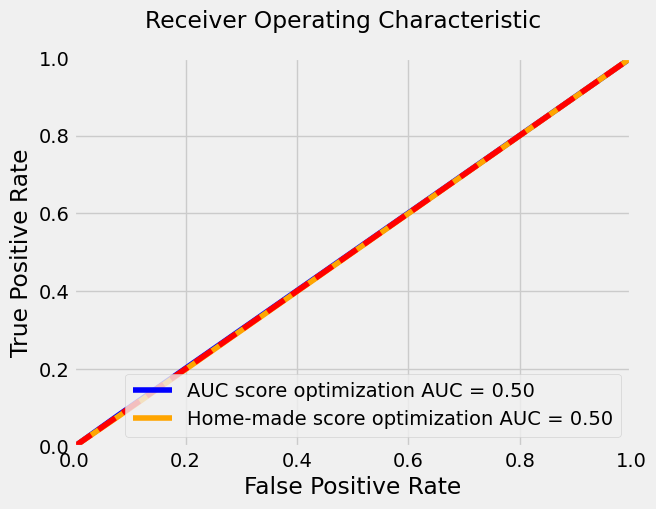

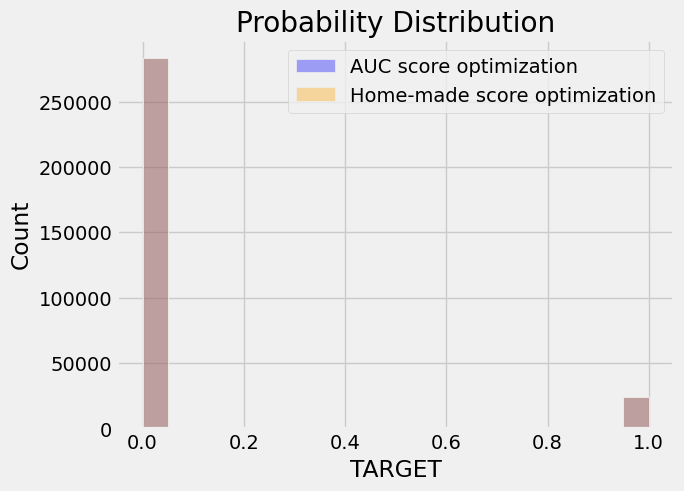

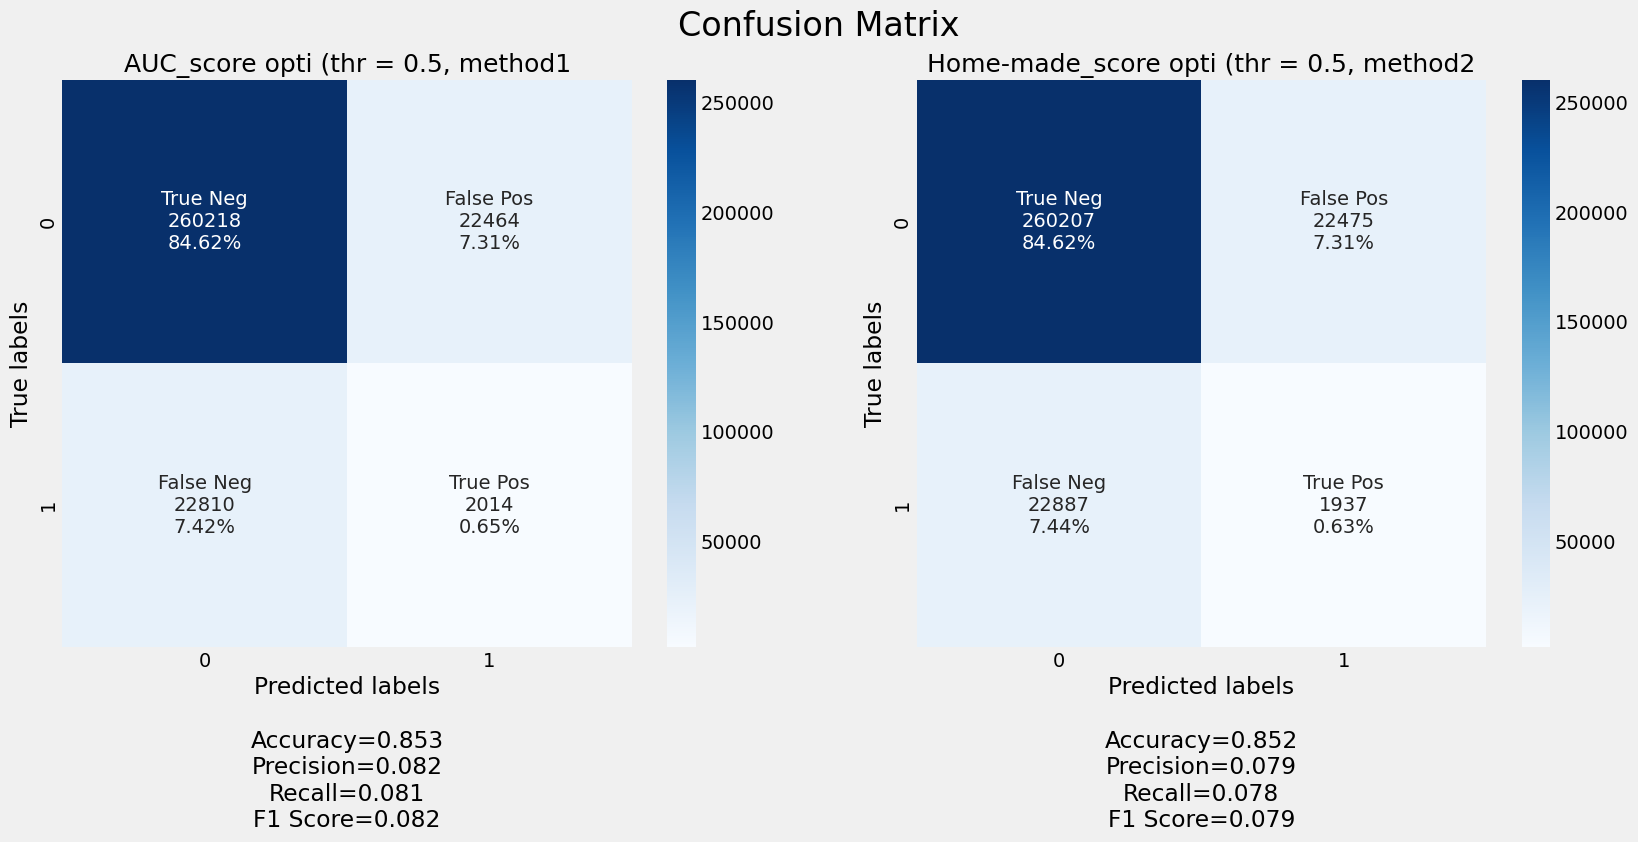

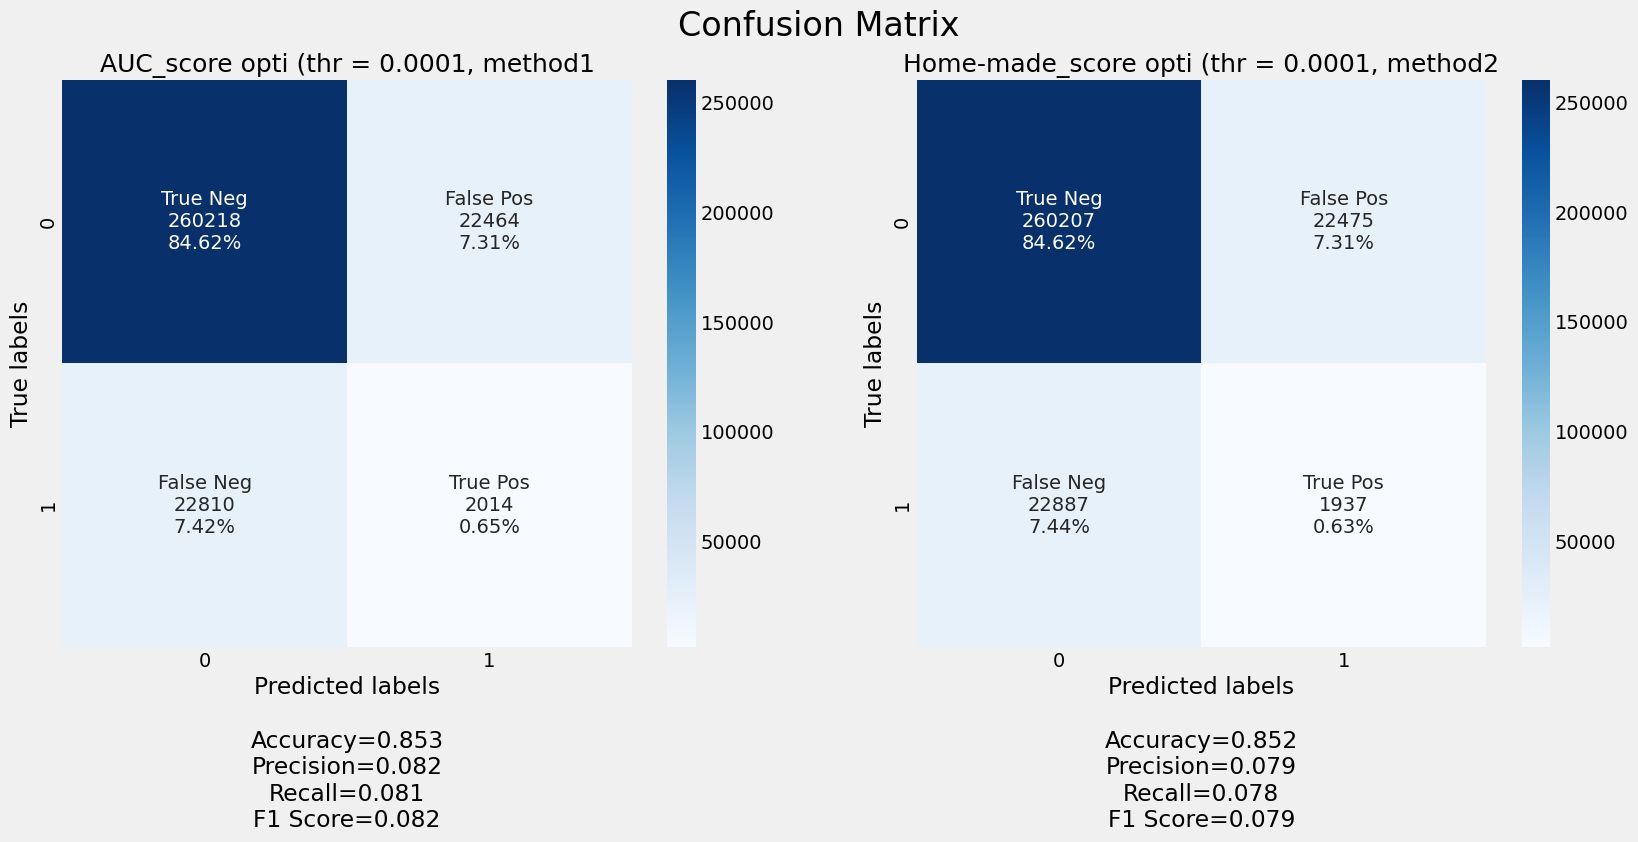

Classification Report / AUC score Optimization 
               precision    recall  f1-score   support

         0.0       0.92      0.92      0.92    282682
         1.0       0.08      0.08      0.08     24824

    accuracy                           0.85    307506
   macro avg       0.50      0.50      0.50    307506
weighted avg       0.85      0.85      0.85    307506
 

 Classification Report / Home-made score Optimization 
               precision    recall  f1-score   support

         0.0       0.92      0.92      0.92    282682
         1.0       0.08      0.08      0.08     24824

    accuracy                           0.85    307506
   macro avg       0.50      0.50      0.50    307506
weighted avg       0.85      0.85      0.85    307506



model  accuracy  \
DummyClassifier & class_weight (scoring AUC)        model1  0.852770   
DummyClassifier & class_weight (scoring AUC) / ...  model1  0.852770   
DummyClassifier & class_weight (scoring Home-made)  model2  0.852484   
DummyClassifier & class_weight (scoring Home-ma...  model2  0.852484   

                                                    precision    recall  \
DummyClassifier & class_weight (scoring AUC)         0.081131  0.082278   
DummyClassifier & class_weight (scoring AUC) / ...   0.081131  0.082278   
DummyClassifier & class_weight (scoring Home-made)   0.078029  0.079346   
DummyClassifier & class_weight (scoring Home-ma...   0.078029  0.079346   

                                                    f1-score   roc_auc  \
DummyClassifier & class_weight (scoring AUC)        0.081701  0.500832   
DummyClassifier & class_weight (scoring AUC) / ...  0.081701  0.500832   
DummyClassifier & class_weight (scoring Home-made)  0.078682  0.499262   
DummyClassifier & class_weight (scoring Home-ma...  0.078682  0.499262   

                                                    Home-made_score  \
DummyClassifier & class_weight (scoring AUC)              -0.044467   
DummyClassifier & class_weight (scoring AUC) / ...        -0.044467   
DummyClassifier & class_weight (scoring Home-made)        -0.019070   
DummyClassifier & class_weight (scoring Home-ma...        -0.019070   

                                                    threshold      time  
DummyClassifier & class_weight (scoring AUC)           0.5000  0.723884  
DummyClassifier & class_weight (scoring AUC) / ...     0.0001  0.723884  
DummyClassifier & class_weight (scoring Home-made)     0.5000  0.745416  
DummyClassifier & class_weight (scoring Home-ma...     0.0001  0.745416

In [ ]:
df_dum, model_dum, params_dum, scores_dum, curve_dum = model_res(dummy_clf, X, y, {})

In [ ]:
model_dum[1]

DummyClassifier(strategy='stratified')

In [ ]:
run_mlflow_experiment(model_dum[0], 
                      'DummyClassifier_ref', 'dummy_roc.png', params_dum[0], scores_dum[0], 0.723884, curve_dum)

<Figure size 640x480 with 0 Axes>

### LGBMClassifier_weighted

param_lgb = {'class_weight': [{0:x, 1:1.0-x} for x in np.linspace(0.1,0.3,5)],
            'num_leaves':range(10,80,10),
            'max_depth': [8, 9, 10, 11, 12],
            'n_estimators':range(100,900,100)}

In [ ]:
param_lgb = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
              'num_leaves':range(10,100,10),
              'min_child_samples':range(500,1000,100),
              'reg_alpha':[0.1,0.01,0.2,0.3],
              'reg_lambda':[0.1,0.01,0.2,0.3],
             'n_estimators':range(50,300,50),
              'max_bin': range(500,1500,100)}

[LightGBM] [Info] Number of positive: 24824, number of negative: 282682
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.802043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133588
[LightGBM] [Info] Number of data points in the train set: 307506, number of used features: 347
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 19859, number of negative: 226145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.671157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133590
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 347
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.00000

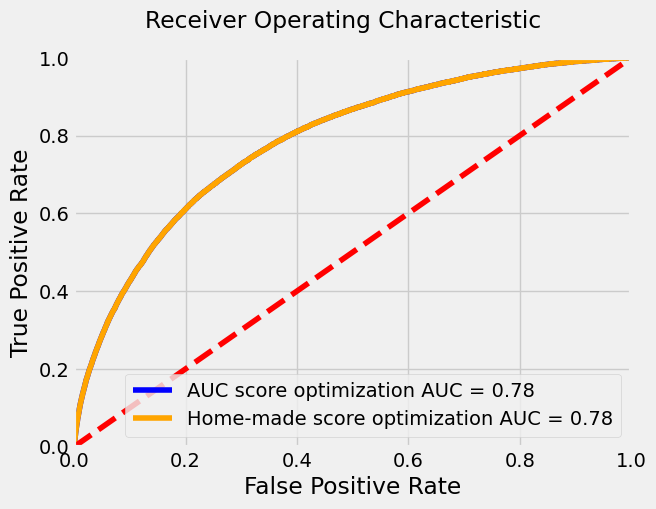

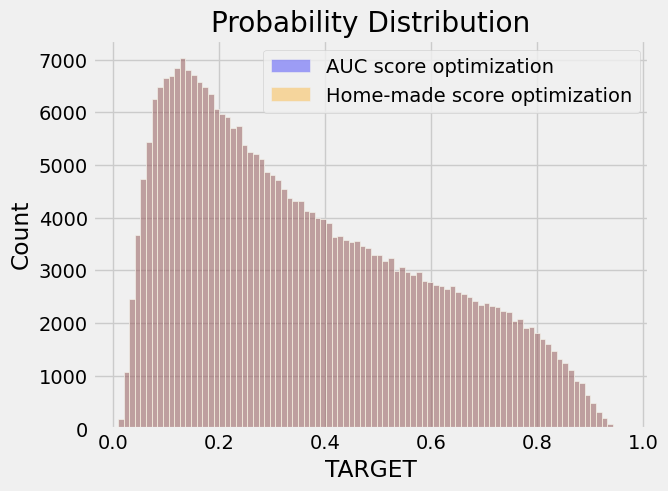

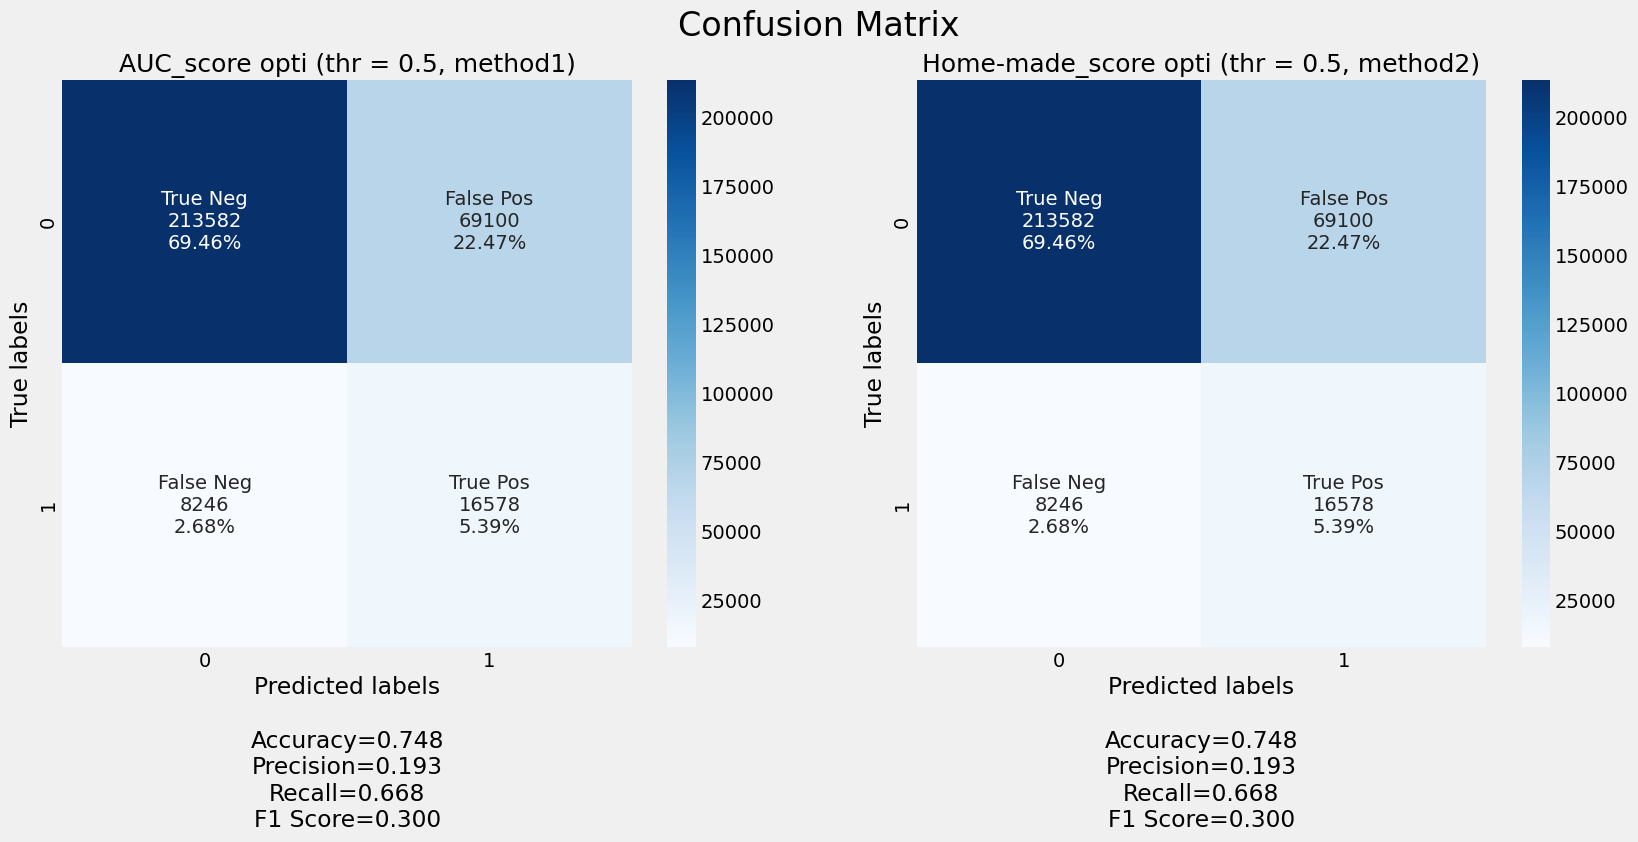

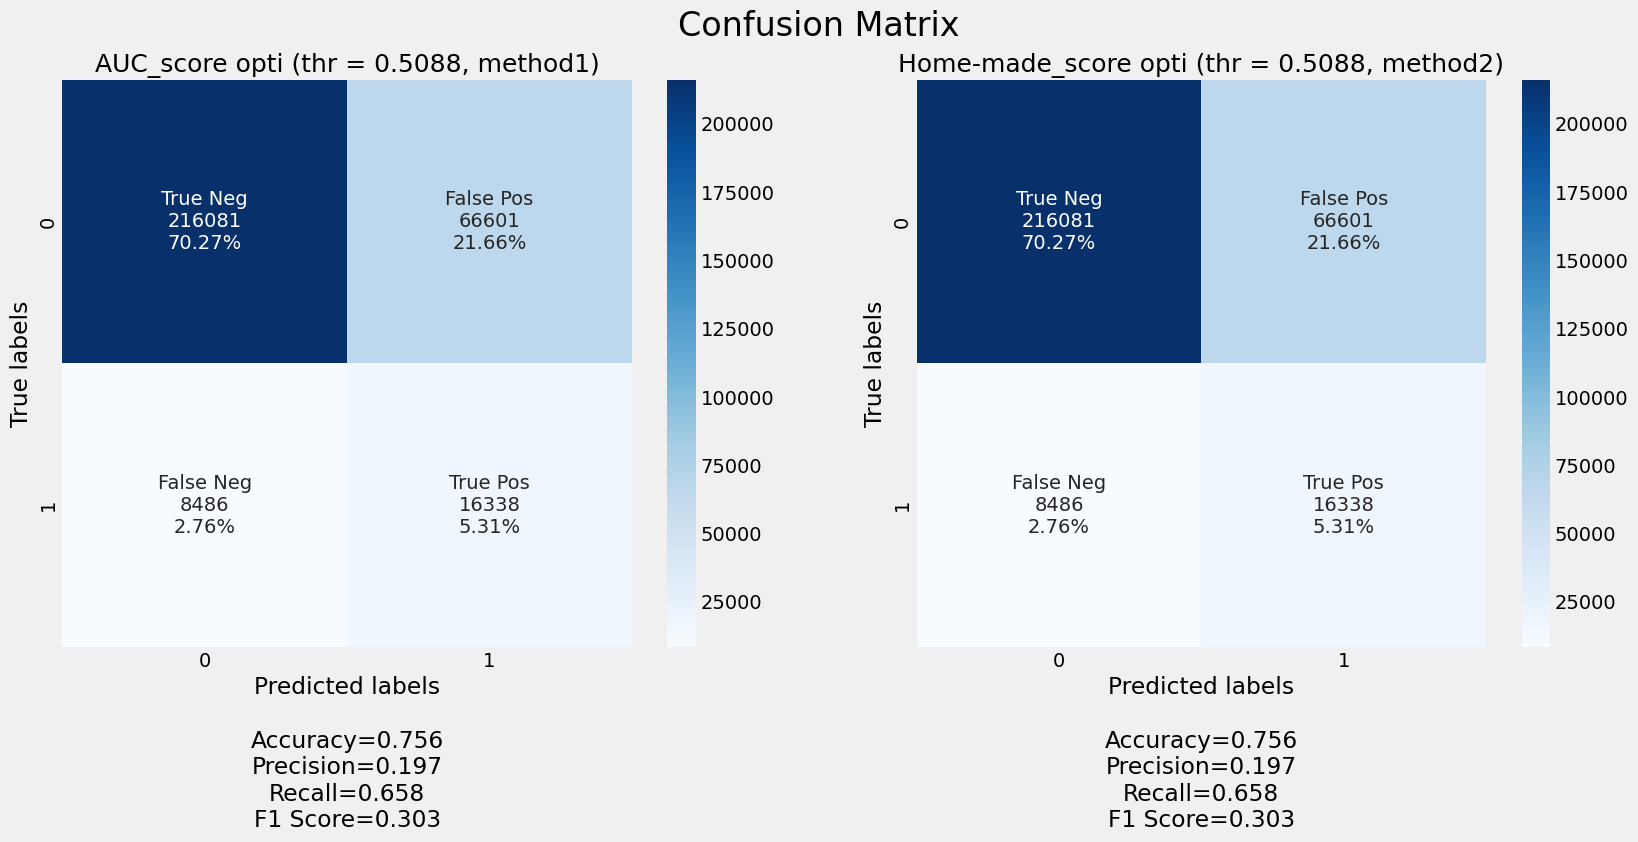

Classification Report / AUC score Optimization 
               precision    recall  f1-score   support

         0.0       0.96      0.76      0.85    282682
         1.0       0.19      0.67      0.30     24824

    accuracy                           0.75    307506
   macro avg       0.58      0.71      0.57    307506
weighted avg       0.90      0.75      0.80    307506
 

 Classification Report / Home-made score Optimization 
               precision    recall  f1-score   support

         0.0       0.96      0.76      0.85    282682
         1.0       0.19      0.67      0.30     24824

    accuracy                           0.75    307506
   macro avg       0.58      0.71      0.57    307506
weighted avg       0.90      0.75      0.80    307506



model  accuracy  \
LGBMClassifier & class_weight (scoring AUC)         model1  0.748473   
LGBMClassifier & class_weight (scoring AUC) / b...  model1  0.755819   
LGBMClassifier & class_weight (scoring Home-made)   model2  0.748473   
LGBMClassifier & class_weight (scoring Home-mad...  model2  0.755819   

                                                    precision    recall  \
LGBMClassifier & class_weight (scoring AUC)          0.667821  0.193492   
LGBMClassifier & class_weight (scoring AUC) / b...   0.658153  0.196988   
LGBMClassifier & class_weight (scoring Home-made)    0.667821  0.193492   
LGBMClassifier & class_weight (scoring Home-mad...   0.658153  0.196988   

                                                    f1-score  roc_auc  \
LGBMClassifier & class_weight (scoring AUC)         0.300049  0.78398   
LGBMClassifier & class_weight (scoring AUC) / b...  0.303221  0.78398   
LGBMClassifier & class_weight (scoring Home-made)   0.300049  0.78398   
LGBMClassifier & class_weight (scoring Home-mad...  0.303221  0.78398   

                                                    Home-made_score  \
LGBMClassifier & class_weight (scoring AUC)               -3.264047   
LGBMClassifier & class_weight (scoring AUC) / b...        -3.267266   
LGBMClassifier & class_weight (scoring Home-made)         -3.264047   
LGBMClassifier & class_weight (scoring Home-mad...        -3.267266   

                                                    threshold       time  
LGBMClassifier & class_weight (scoring AUC)            0.5000  43.396656  
LGBMClassifier & class_weight (scoring AUC) / b...     0.5088  43.396656  
LGBMClassifier & class_weight (scoring Home-made)      0.5000  43.478217  
LGBMClassifier & class_weight (scoring Home-mad...     0.5088  43.478217

In [ ]:
df_lgb, model_lgb, params_lgb, scores_lgb, curve_lgb = model_res(LGBMClassifier(random_state = 100, n_jobs=-1,
                                                                                class_weight = 'balanced'), 
                                                                 X, y, param_lgb)

df_lgb, model_lgb, params_lgb, scores_lgb, curve_lgb

In [ ]:
run_mlflow_experiment(model_lgb[1], 
                      'Best_LGMClassifier', 'lgbm_roc.png', params_lgb[1], scores_lgb[3], 43.478217, curve_lgb)

2023/11/11 00:25:05 INFO mlflow.tracking.fluent: Experiment with name 'Best_LGMClassifier' does not exist. Creating a new experiment.


<Figure size 640x480 with 0 Axes>

Le meilleur classifieur LGBM sera retenu ; il est par ailleurs beaucoup plus rapide que XGBoost.

## XVII.4 Pipeline de référence <a class="anchor" id="18_4"></a>

Combinaison du pipe de transformation enregistré et du modèle entraîné.

In [ ]:
transfo = joblib.load('col_transfo.joblib')

In [ ]:
logged_model = 'runs:/ae62ebaedc784cfd82037d5c270a2ed6/LGBMClassifier'
model_ref = mlflow.sklearn.load_model(logged_model)

In [ ]:
model_ref

LGBMClassifier(class_weight='balanced', max_bin=500, min_child_samples=800,
               n_jobs=-1, num_leaves=70, random_state=100, reg_alpha=0.2,
               reg_lambda=0.1)

In [ ]:
final_pipe = Pipeline([('transformer',transfo), ('model', model_ref)])

In [ ]:
joblib.dump(final_pipe, 'model.joblib')

['model.joblib']

## XVII.5 Improved functions <a class="anchor" id="18_5"></a>

In [ ]:
# ----------------------------------------------------------
# fonction de sélection des meilleurs modèles par RandomizeSearch 
# avec ou sans smote préalable (class_weight sinon et si possible)
# optimisation du score AUC puis du score créé
# identification des meilleurs seuils pour minimiser la fonction de coût
def model_res2(model, X, y, params, Kf = 2,
               disp = True, group_names=['True Neg','False Pos','False Neg','True Pos'],
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          sum_stats=True,
                          cmap='Blues'):
    
    kfold = StratifiedKFold(n_splits=Kf, random_state=100, shuffle=True)
    
    # Extract feature names
    feature_names = list(X.columns)
    
    # Convert to numpy
    X = X.to_numpy()
    y = y.to_numpy()

    model_name = str(type(model)).split('.')[-1][0:-2]
    
    
    model_name += ' & class_weight'     
    pipeline = model
    
        
    scorer = met.make_scorer(cost_score, greater_is_better = False)
    
    clf2 = RandomizedSearchCV(estimator = pipeline, param_distributions = params, scoring = scorer, cv = kfold, 
                              n_jobs=-1, random_state=100)
    clf2.fit(X, y)

    model2 = clf2.best_estimator_
    hyperparams2 = clf2.best_params_  
    start = time()
    y_pred_proba2 = cross_val_predict(model2, X, y, cv=kfold, method='predict_proba')[:, 1]
    end = time()
    laps2 = (end - start)/5
    
    y_pred2 = (y_pred_proba2 >= 0.4).astype(int)  
    accuracy=accuracy_score(y, y_pred2)
    recall=recall_score(y,y_pred2)
    precision=precision_score(y,y_pred2)
    f1=f1_score(y,y_pred2)
    rocauc=roc_auc_score(y,y_pred_proba2)
    score = cost_score(y,y_pred2)    
    scores2 = [accuracy, recall, precision, f1, rocauc, score, 0.4]

    thresh2 = best_thresh(y, y_pred_proba2)
    y_pred2bis = (y_pred_proba2 >= thresh2).astype(int)
    accuracy=accuracy_score(y, y_pred2bis)
    recall=recall_score(y,y_pred2bis)
    precision=precision_score(y,y_pred2bis)
    f1=f1_score(y,y_pred2bis)
    rocauc=roc_auc_score(y,y_pred_proba2)
    score = cost_score(y,y_pred2bis)     
    scores2bis = [accuracy, recall, precision, f1, rocauc, score, thresh2]    
    
    
    df = None
    
    if disp == True:

        fpr2, tpr2, _ = roc_curve(y, y_pred_proba2)
        curve = plt.figure()
        plt.plot(fpr2, tpr2, 'orange', label = 'Home-made score optimization AUC = %0.2f' % auc(fpr2, tpr2))
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.suptitle('Receiver Operating Characteristic')
        
        output2 = pd.DataFrame({'SK_ID_CURR': train_id.SK_ID_CURR, 
                               'TARGET': y, 'PREDICT' : y_pred_proba2})
        fig, ax = plt.subplots(1,1)        
        sns.histplot(output2['PREDICT'], ax = ax, label = 'Home-made score optimization', kde=True, alpha=0.35)
        plt.legend()
        plt.title('Probability Distribution')
        plt.show()
        

        # Confusion matrix
        #cm = pd.DataFrame({'SK_ID_CURR': train_id.to_numpy(), 'TARGET': y, 'PREDICT' : y_pred_proba2})
        my_pal = {0:bleu, '0.0':bleu, 1:rouge, '1.0':rouge}
        curve2 = sns.boxplot(data=output2, x='TARGET', y='PREDICT', palette=my_pal)
        curve2.axhline(y=thresh2, color=magenta, linestyle="dashed")
        
        cm2 = met.confusion_matrix(y, y_pred2)
        cm2bis = met.confusion_matrix(y, y_pred2bis)


            # CODE TO GENERATE TEXT INSIDE EACH SQUARE
        def cf_matrix(cf = cm2):
            blanks = ['' for i in range(cf.size)]

            if group_names and len(group_names)==cf.size:
                group_labels = ["{}\n".format(value) for value in group_names]
            else:
                group_labels = blanks

            if count:
                group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
            else:
                group_counts = blanks

            if percent:
                group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
            else:
                group_percentages = blanks

            box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
            box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
            return box_labels   
        
        def sum_stats(cf=cm2):
            # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
            if sum_stats:
                #Accuracy is sum of diagonal divided by total observations
                accuracy2  = np.trace(cf) / float(np.sum(cf))

                #if it is a binary confusion matrix, show some more stats
                if len(cf)==2:
                    #Metrics for Binary Confusion Matrices
                    recall2 = cf[1,1] / sum(cf[:,1])
                    precision2    = cf[1,1] / sum(cf[1,:])
                    f1_score  = 2*precision2*recall2 / (precision2 + recall2)
                    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                        accuracy2,precision2,recall2,f1_score)
                else:
                    stats_text = "\n\nAccuracy={:0.3f}".format(accuracy2)
            else:
                stats_text = ""
            return stats_text


        
        fig, ax = plt.subplots(1,2, figsize = (18,7))
        sns.heatmap(cm2bis, annot=cf_matrix(cm2bis),  fmt='', cmap=cmap,cbar=cbar,xticklabels=categories, 
                    yticklabels=categories, ax = ax[1])
        ax[1].set_title(f'Home-made_score optimization (thr = {thresh2})', fontsize=18)
        ax[1].set_ylabel('True labels')
        ax[1].set_xlabel('Predicted labels' + sum_stats(cf=cm2bis))
        sns.heatmap(cm2, annot=cf_matrix(cm2),  fmt='', cmap=cmap,cbar=cbar,xticklabels=categories, 
                    yticklabels=categories, ax = ax[0])
        ax[0].set_title(f'Home-made_score optimization (thr = {0.4})', fontsize=18)
        ax[0].set_ylabel('True labels')
        ax[0].set_xlabel('Predicted labels' + sum_stats(cf=cm2))
        plt.suptitle('Confusion Matrix', fontsize=24)
        plt.show()
                
        col = ['accuracy', 'precision', 'recall', 'f1-score', 'roc_auc', 'Home-made_score', 'threshold', 'time']
        model_name2 = model_name + ' (scoring Home-made)'
        model_name2bis = model_name + ' (scoring Home-made) / best thresh'
        dic_mod = {model_name2 : scores2 + [laps2], model_name2bis : scores2bis + [laps2]}
        df = pd.DataFrame.from_dict(dic_mod, orient = 'index', columns = col)
        
        display(df)        
        
    return df, model2, hyperparams2, (scores2, scores2bis), output2, curve, curve2

In [ ]:
# ----------------------------------------------------------
# fonction du MLFlow permettant d'enregistrer les expériences 
def run_mlflow_experiment2(model, exp_name, fig_name, hyperparams, scores, time, curve):
    plt.savefig(fig_name)
    
    
    if str(type(model)).split('.')[1] in ['sklearn', 'dummy', 'linear_model', 'ensemble']:
        model_name = str(type(model)).split('.')[-1][0:-2]
    else:
        model_name = 'Smote' + '/' + str(type(model.named_steps['classifier'])).split('.')[-1][0:-2]
    
    # Nom de l'expérience
    experiment_name = exp_name
    
    # Use the fluent API to set the tracking uri and the active experiment
    mlflow.set_tracking_uri("http://127.0.0.1:8080")
    # Initialisation de l'expérience
    mlflow.set_experiment(experiment_name)
    
    # Démarrage d'un run
    with mlflow.start_run(run_name = exp_name) as run:
        
        # Enregistrement des hyperparamètres
        mlflow.log_params(hyperparams)
        
        # Enregistrement des métriques
        mlflow.log_metric("Accuracy", scores[0])
        mlflow.log_metric("Precision", scores[1])
        mlflow.log_metric("Recall", scores[2])
        mlflow.log_metric("F1_score", scores[3])
        mlflow.log_metric("Auc_score", scores[4])
        mlflow.log_metric("Home-made_score", scores[5])
        mlflow.log_metric("Threshold", scores[6])
        mlflow.log_metric("Fit_time", time)

        # Enregistrement des graphiques
        mlflow.log_figure(curve, artifact_file = fig_name)
        
        # Enregistrement du modèle entraîné
        mlflow.sklearn.log_model(model, model_name)

## XVII.6 Dummy_classifier model <a class="anchor" id="18_6"></a>

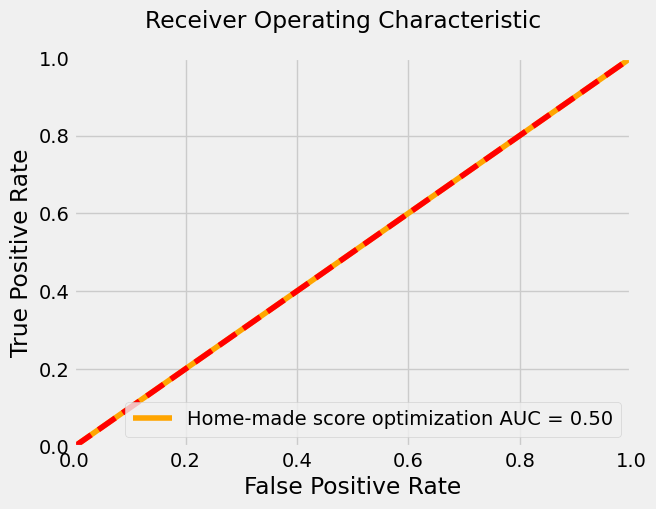

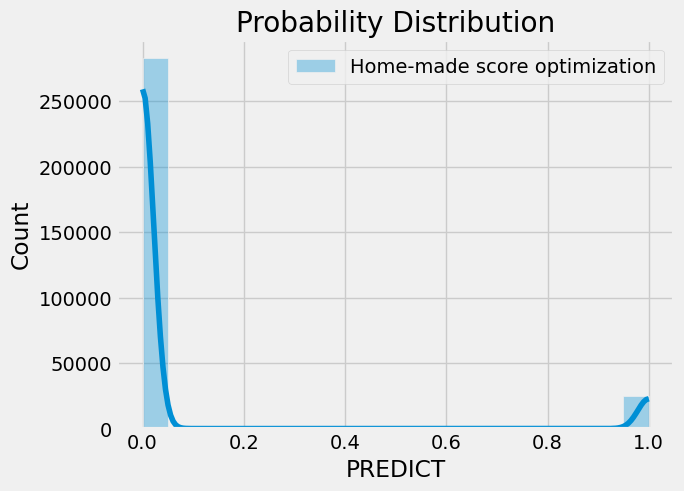

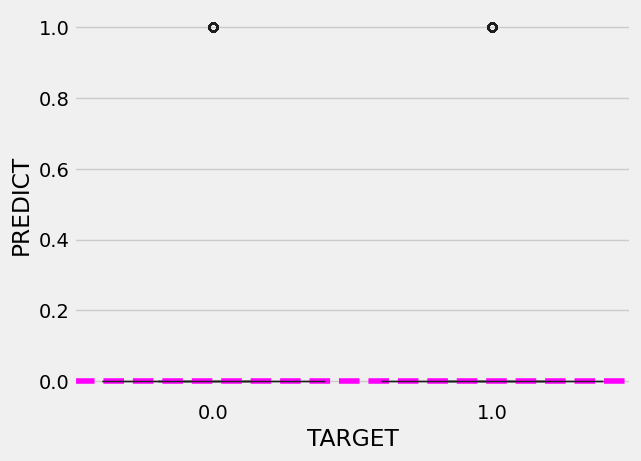

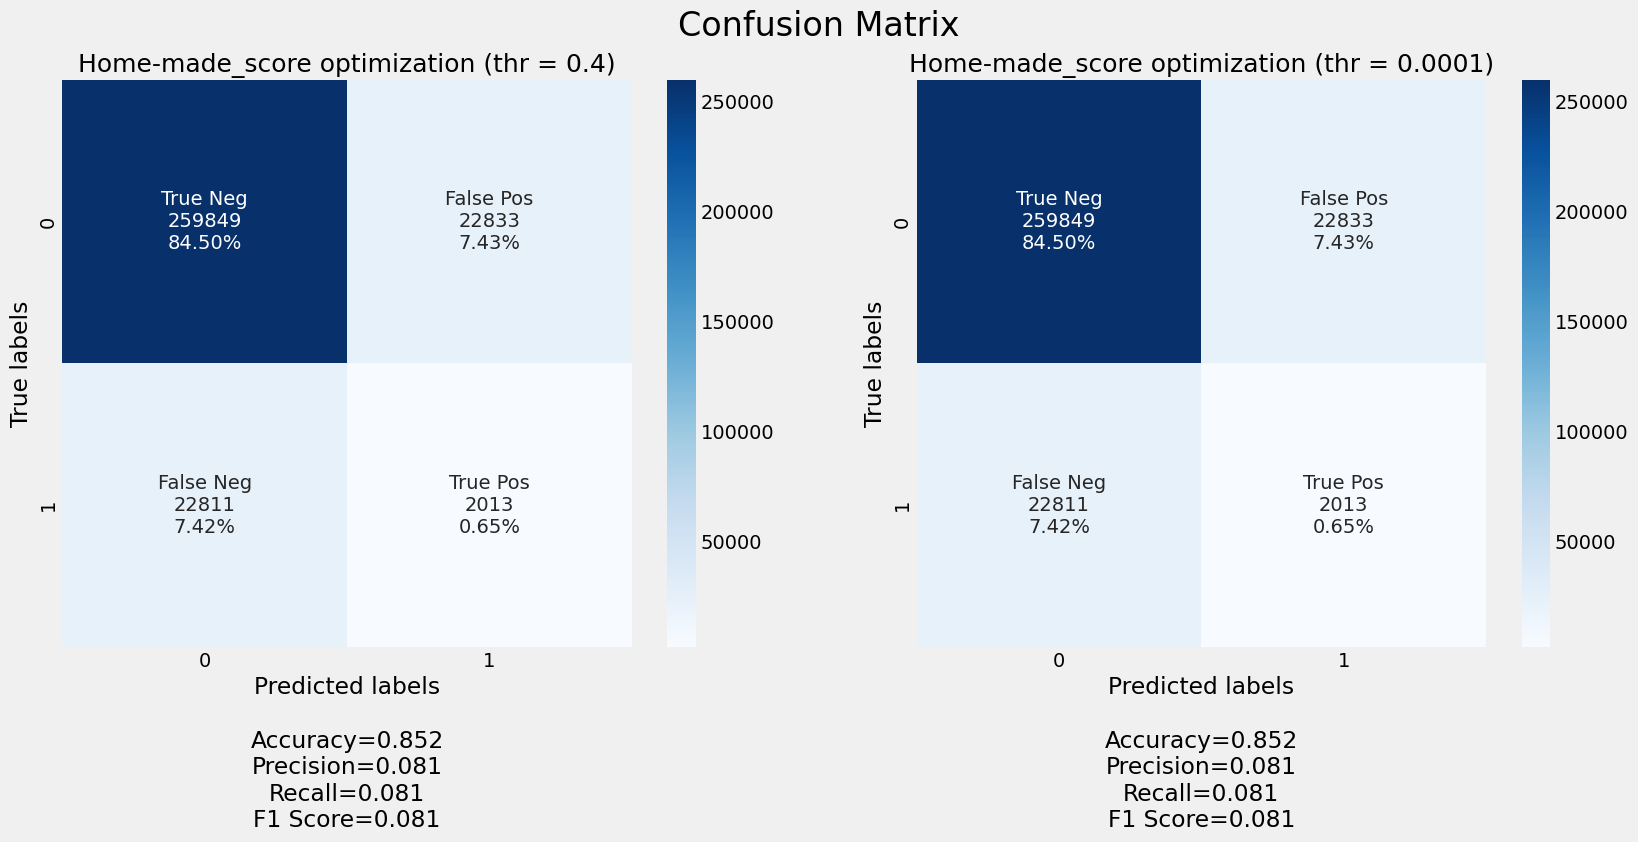

accuracy  precision  \
DummyClassifier & class_weight (scoring Home-made)  0.851567   0.081091   
DummyClassifier & class_weight (scoring Home-ma...  0.851567   0.081091   

                                                      recall  f1-score  \
DummyClassifier & class_weight (scoring Home-made)  0.081019  0.081055   
DummyClassifier & class_weight (scoring Home-ma...  0.081019  0.081055   

                                                     roc_auc  Home-made_score  \
DummyClassifier & class_weight (scoring Home-made)  0.500159        -0.032142   
DummyClassifier & class_weight (scoring Home-ma...  0.500159        -0.032142   

                                                    threshold      time  
DummyClassifier & class_weight (scoring Home-made)     0.4000  0.289064  
DummyClassifier & class_weight (scoring Home-ma...     0.0001  0.289064

In [ ]:
df_dum, model_dum, params_dum, scores_dum, pred_dum, curve_dum, curve2_dum = model_res2(dummy_clf, X, y, {})

## XVII.7 LGBM_Classifier model <a class="anchor" id="18_7"></a>

In [ ]:
param_lgb2 = {'class_weight': [{0:x, 1:1.0-x} for x in [0.05, 0.08, 0.12, 0.15, 0.18, 0.21, 0.25, 0.3]],
            'learning_rate':[0.2,0.1,0.01,0.05,0.001],
              'num_leaves':range(10,100,10),
              'min_child_samples':range(500,1000,100),
              'reg_alpha':[0.1,0.01,0.2,0.3],
              'reg_lambda':[0.1,0.01,0.2,0.3],
             'n_estimators':range(50,300,50),
              'max_bin': range(500,1500,100)}

[LightGBM] [Info] Number of positive: 24824, number of negative: 282682
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.057741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 310460
[LightGBM] [Info] Number of data points in the train set: 307506, number of used features: 347
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502459 -> initscore=0.009835
[LightGBM] [Info] Start training from score 0.009835
[LightGBM] [Info] Number of positive: 19859, number of negative: 226145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.894211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 310519
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 347
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502457 -> initscore=0.009828
[LightGBM] [Info] Start training from score 0.009828


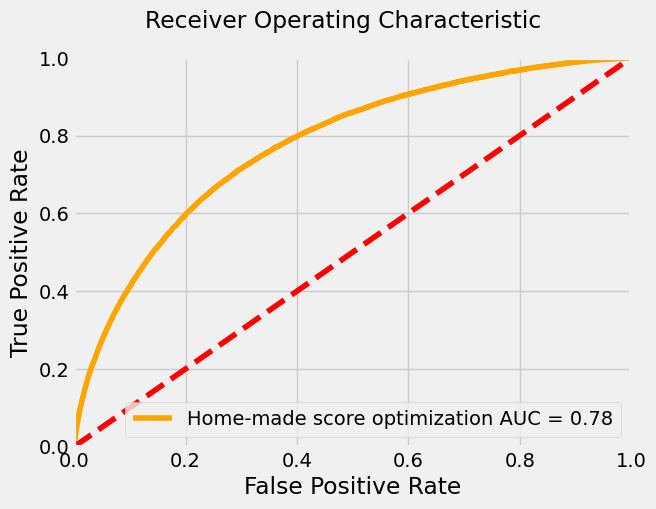

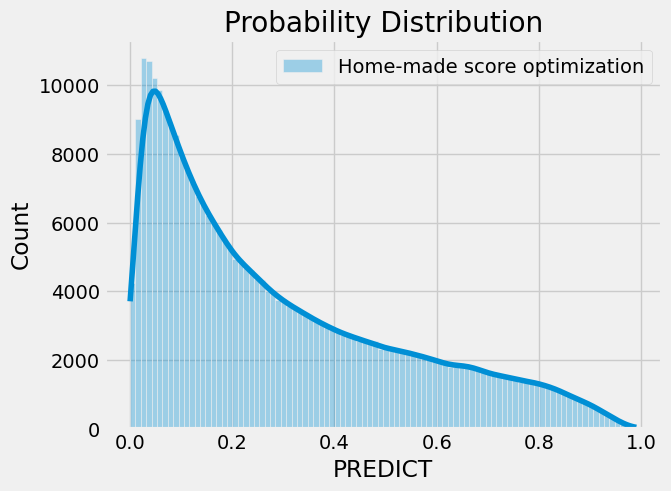

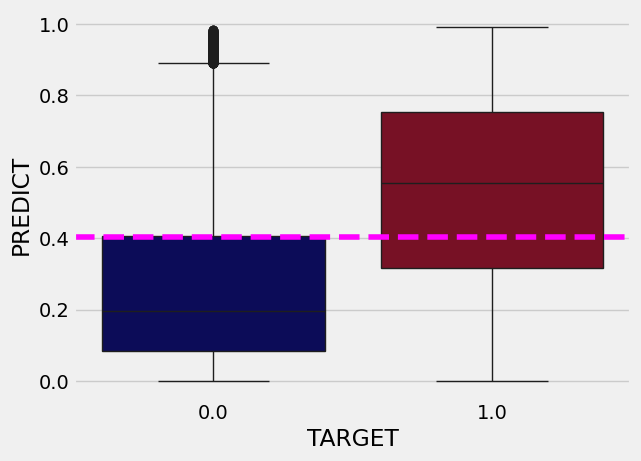

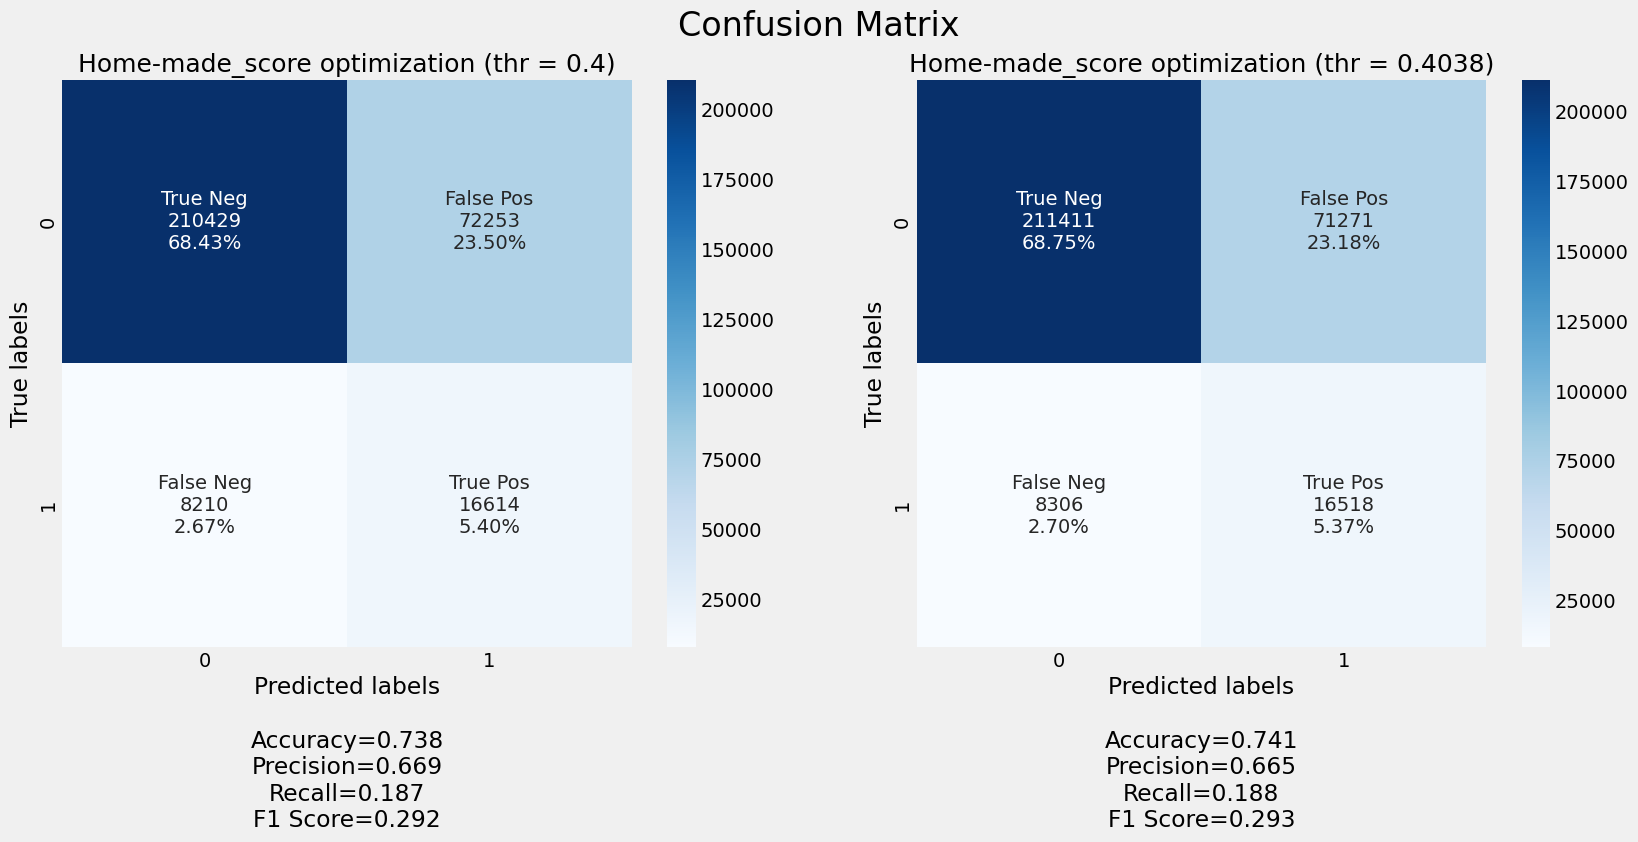

accuracy  precision  \
LGBMClassifier & class_weight (scoring Home-made)   0.738337   0.669272   
LGBMClassifier & class_weight (scoring Home-mad...  0.741218   0.665404   

                                                      recall  f1-score  \
LGBMClassifier & class_weight (scoring Home-made)   0.186954  0.292266   
LGBMClassifier & class_weight (scoring Home-mad...  0.188156  0.293359   

                                                     roc_auc  Home-made_score  \
LGBMClassifier & class_weight (scoring Home-made)   0.775734        -3.173219   
LGBMClassifier & class_weight (scoring Home-mad...  0.775734        -3.173935   

                                                    threshold       time  
LGBMClassifier & class_weight (scoring Home-made)      0.4000  74.254426  
LGBMClassifier & class_weight (scoring Home-mad...     0.4038  74.254426

In [ ]:
df_lgb, model_lgb, params_lgb, scores_lgb, pred_lgb, curve_lgb, curve2_lgb = model_res2(LGBMClassifier(random_state = 100, n_jobs=-1), 
                                                                 X, y, param_lgb2, Kf=5)

In [ ]:
pred_lgb.head(3)

SK_ID_CURR  TARGET   PREDICT
0      100002     1.0  0.679550
1      100003     0.0  0.147918
2      100004     0.0  0.225231

## XVII.8 Fonction coût métier <a class="anchor" id="18_8"></a>

#### Creation d'une fonction cm (generer matrice de confusion), d'une fct cout et d'une fct cout_plot

In [ ]:
def cm(cm=pred_lgb, seuil=0.35):
    cm2 = cm.copy()
    cm2.PREDICT = cm2.PREDICT.apply(lambda x : 1 if x > seuil else 0)
    cm2.TARGET = cm2.TARGET.apply(lambda x : int(x))
    cm2b = confusion_matrix(cm2.TARGET, cm2.PREDICT)
    """disp = ConfusionMatrixDisplay(confusion_matrix=cm2b,
                          display_labels=['0','1'])
    disp.plot(values_format="d")
    plt.show()
    print("")"""
    return cm2b

In [ ]:
def cout(Seuil=0.5):
    TN = cm(seuil=Seuil)[0][0]
    FP = cm(seuil=Seuil)[0][1]
    FN = cm(seuil=Seuil)[1][0]
    TP = cm(seuil=Seuil)[1][1]
    cout_norm = ((101 * FN) - (9 * TN) + TP + FP) / (FN+TN+TP+FP) #equation du cout normaliser (par le nombre)
    return cout_norm

In [ ]:
def cout_plot():
    l1 = []
    l2 = []
    for i in np.arange(0.0, 1.01, 0.01):
        l1.append(i)
        l2.append(cout(i))
    dico = {'seuil':l1, 'coût':l2}
    df = pd.DataFrame(dico, columns=['seuil', 'coût'])
    #df.to_csv(f'{path_to_dir}\\Method1\\line_plot_coutmetier.csv', index=False)
    return df

In [ ]:
df = cout_plot() #2min44s

In [ ]:
df[df['coût']==df['coût'].min()]['coût'].values[0]

-3.1732193843372163

In [ ]:
def plot2(table=df):
    x=round(table[table['coût']==table['coût'].min()]['seuil'].values[0], 2)
    y=round(table[table['coût']==table['coût'].min()]['coût'].values[0], 2)
    fig = px.line(table, x="seuil", y="coût", title='Coût normalisé en fonction du seuil')
    fig.add_vline(x=x, line_width=3, line_dash="dash", line_color=magenta)
    fig.add_annotation(x=x, y=y,
            text=f"Seuil optimal à {x} pour un coût minimal de {y}",
            showarrow=True,
            font=dict(family="sans serif", size=14, color=magenta),
            arrowhead=2)
    return fig

In [ ]:
curve3_lgb = plot2()

In [ ]:
curve3_lgb

## XVII.9 Save model with MLFlow <a class="anchor" id="18_9"></a>

In [ ]:
run_mlflow_experiment(model_lgb, 
                      'Best_LGMClassifier_final', 'lgbm_roc.png', params_lgb, scores_lgb[1], 74.254426, curve_lgb)

<Figure size 640x480 with 0 Axes>

In [ ]:
logged_model = 'runs:/daf6e939ed2e43c5b325fdf611d0c8f8/LGBMClassifier'
model_ref = mlflow.sklearn.load_model(logged_model)

In [ ]:
model_ref

LGBMClassifier(class_weight={0: 0.08, 1: 0.92}, learning_rate=0.2, max_bin=1300,
               min_child_samples=700, n_estimators=200, n_jobs=-1,
               num_leaves=60, random_state=100, reg_alpha=0.1, reg_lambda=0.3)

In [ ]:
final_pipe = Pipeline([('transformer',transfo), ('model', model_ref)])
joblib.dump(final_pipe, 'model.joblib')

['model.joblib']

 6. Feature importance et interprétabilité (globale et locale) <a class="anchor" id="6"></a>

## XVII.10 Feature importance <a class="anchor" id="18_10"></a>

In [14]:
pipe_test = joblib.load('model.joblib')

In [15]:
type(pipe_test[1])

lightgbm.sklearn.LGBMClassifier

In [ ]:
pipe_test[0]

ColumnTransformer(transformers=[('Cat',
                                 Pipeline(steps=[('LabelImputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('Encoder',
                                                  OrdinalEncoder())]),
                                 Index([], dtype='object')),
                                ('Num',
                                 Pipeline(steps=[('NumImputer',
                                                  SimpleImputer()),
                                                 ('Scaler', MinMaxScaler())]),
                                 Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE'...
       ...
       'APP_SCORE2_TO_POP_RATIO', 'APP_SCORE2_TO_PHONE_CHANGE_RATIO',
       'APP_EXT_SOURCE_1*EXT_SOURCE_2', 'APP_EXT_SOURCE_1*EXT_SOURCE_3',
       'APP_EXT_SOURCE_2*EXT_SOURCE_3', 'APP_EXT_SOURCE_1*DAYS_EMPLOYED',
       'APP_EXT_SOURCE_2*DAYS_EMPLOYED', 'APP_EXT_SOURCE_3*DAYS_EMPLOYED',
       'APPS_GOODS_INCOME_RATIO', 'APP_DAYS_EMPLOYED_DAYS_BIRTH_diff'],
      dtype='object', length=347))])

In [94]:
y_pred_test = pipe_test.predict_proba(train2)

In [95]:
train_test = train2.copy()
train_test['proba'] = pd.DataFrame(y_pred_test)[1]

In [ ]:
train_test.head(3)

SK_ID_CURR  TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0      100002     1.0          202500.0    406597.5      24700.5   
1      100003     0.0          270000.0   1293502.5      35698.5   
2      100004     0.0           67500.0    135000.0       6750.0   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801        9461         -637.0   
1        1129500.0                    0.003541       16765        -1188.0   
2         135000.0                    0.010032       19046         -225.0   

   DAYS_REGISTRATION  ...  APP_SCORE2_TO_PHONE_CHANGE_RATIO  \
0            -3648.0  ...                         -0.000232   
1            -1186.0  ...                         -0.000752   
2            -4260.0  ...                         -0.000682   

   APP_EXT_SOURCE_1*EXT_SOURCE_2  APP_EXT_SOURCE_1*EXT_SOURCE_3  \
0                       0.021834                       0.011573   
1                       0.193685                            NaN   
2                            NaN                            NaN   

   APP_EXT_SOURCE_2*EXT_SOURCE_3  APP_EXT_SOURCE_1*DAYS_EMPLOYED  \
0                       0.036649                      -52.894548   
1                            NaN                     -369.785566   
2                       0.405575                             NaN   

   APP_EXT_SOURCE_2*DAYS_EMPLOYED  APP_EXT_SOURCE_3*DAYS_EMPLOYED  \
0                     -167.498254                      -88.782372   
1                     -739.227981                             NaN   
2                     -125.080219                     -164.152505   

   APPS_GOODS_INCOME_RATIO  APP_DAYS_EMPLOYED_DAYS_BIRTH_diff     proba  
0                 1.733333                           -10098.0  0.791167  
1                 4.183333                           -17953.0  0.073628  
2                 2.000000                           -19271.0  0.172648  

[3 rows x 350 columns]

### 6.2 Feature importance de LGBM <a class="anchor" id="6.2"></a>

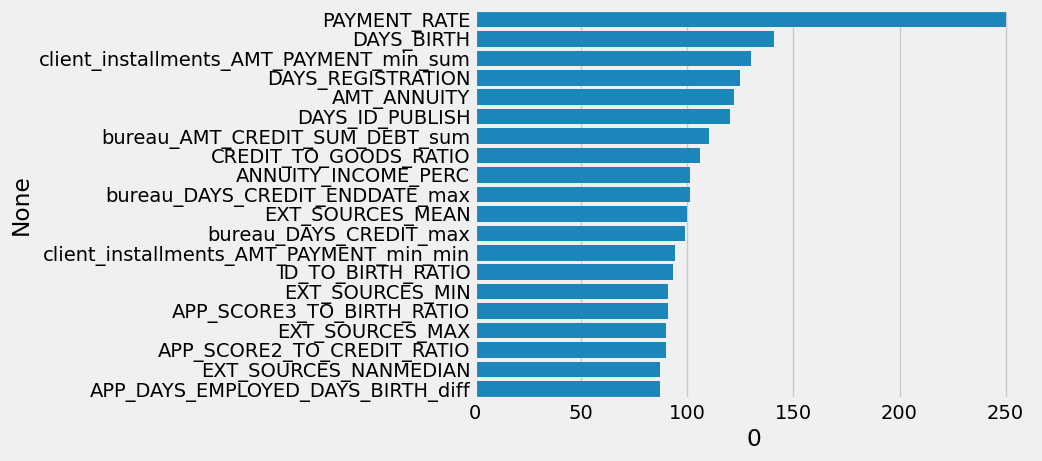

In [ ]:
df_feat = pd.DataFrame(pipe_test[1].feature_importances_, index = [ele.replace('#', '_') for ele in X.columns]).sort_values(by = 0, ascending = False)
fig, ax = plt.subplots()
sns.barplot(x=df_feat.head(20)[0], y=df_feat.head(20).index, ax = ax);

In [ ]:
df_feat.head(3)

0
PAYMENT_RATE                             250
DAYS_BIRTH                               141
client_installments_AMT_PAYMENT_min_sum  130

In [ ]:
df_feat.columns[0]

0

In [ ]:
fig = px.bar(df_feat.iloc[:10,], x=0, y=df_feat.iloc[:10,].index, orientation='h', 
             title='10 first feature importances of model_lgbmClassifier')
fig.update_layout(yaxis={'categoryorder':'total ascending'}) # add only this line
fig.update_layout(xaxis_title='Importance (no unit)', yaxis_title='Features')
fig.show()

## XVII.11 Verification of data leakage <a class="anchor" id="18_11"></a>

In [ ]:
#sns.relplot(x='DAYS_BIRTH', y='proba', hue='TARGET', data=train_test)
#sns.kdeplot(x='DAYS_BIRTH', y='proba', data=train_test);

In [ ]:
y_pred_test_proba = pipe_test.predict_proba(test2)
test_test = test2.copy()
test_test['proba'] = pd.DataFrame(y_pred_test_proba)[1]

In [ ]:
test_test.loc[0, 'proba']

0.14310324892161294

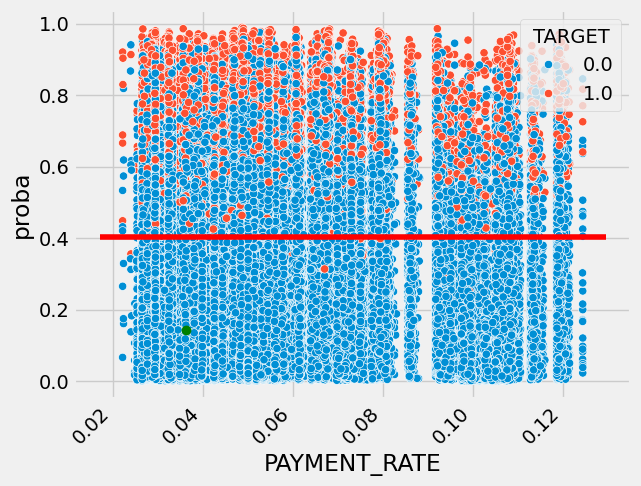

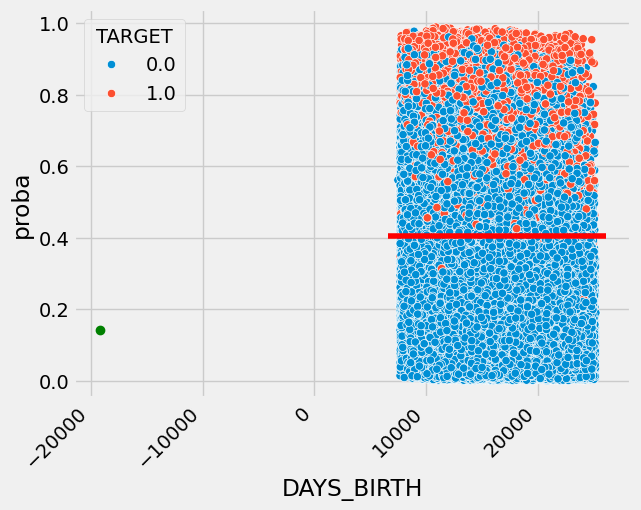

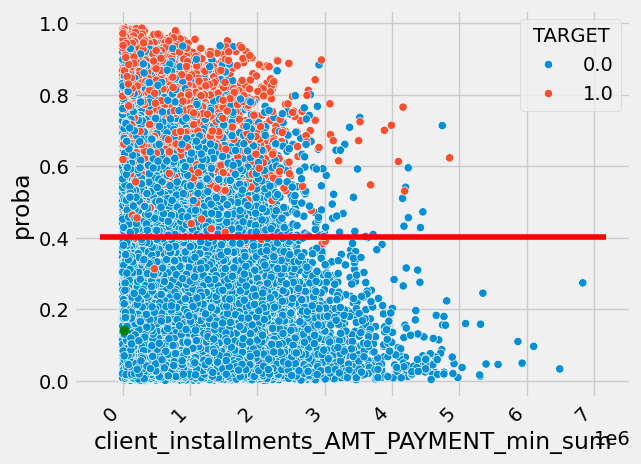

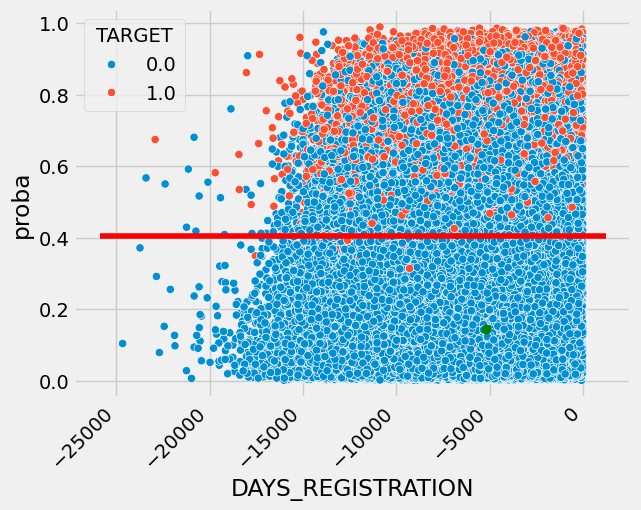

In [ ]:
for feat in df_feat.head(4).index:
    fig, ax = plt.subplots(1,1)
    sns.scatterplot(x=feat, y ='proba', hue = 'TARGET', data = train_test, ax = ax)
    x_min, x_max, y_min, y_max = plt.axis()
    plt.hlines(y = 0.4038, xmin = x_min, xmax = x_max, color = 'red')
    xp = test_test.loc[0, feat]
    yp = test_test.loc[0, 'proba']
    plt.plot(xp, yp, marker = 'o', color = 'green')
    plt.xticks(rotation = 45, ha = 'right');

In [ ]:
# Find correlations with the target and sort
correlations = train_test.corr()['proba'].sort_values()

# Display correlations
print('Most Positive Correlations with proba:\n', correlations.tail(15))
print('\nMost Negative Correlations with proba:\n', correlations.head(15))

Most Positive Correlations with proba:
 DAYS_EMPLOYED_PERC                                0.224054
client_bureau_balance_MONTHS_BALANCE_sum_min      0.228787
bureau_CREDIT_ACTIVE_Active_count_norm            0.230370
client_bureau_balance_MONTHS_BALANCE_sum_mean     0.239071
bureau_DAYS_CREDIT_min                            0.239360
client_bureau_balance_MONTHS_BALANCE_mean_mean    0.246572
DAYS_EMPLOYED                                     0.249976
APP_DAYS_EMPLOYED_DAYS_BIRTH_diff                 0.276736
bureau_DAYS_CREDIT_mean                           0.277827
client_bureau_balance_MONTHS_BALANCE_min_mean     0.283745
APP_EXT_SOURCE_1*DAYS_EMPLOYED                    0.311211
APP_EXT_SOURCE_2*DAYS_EMPLOYED                    0.343974
APP_EXT_SOURCE_3*DAYS_EMPLOYED                    0.353848
TARGET                                            0.510288
proba                                             1.000000
Name: proba, dtype: float64

Most Negative Correlations with proba:
 EXT_SO

### /!\ Some vairables are highly anti-correlated (depending on EXT_SOURCES)

## XVII.12 Create reduced train & test datasets <a class="anchor" id="18_12"></a>

In [96]:
_, test2_samp = train_test_split(test2, test_size = 0.01)
_, train2_samp = train_test_split(train2, test_size = 0.01, stratify=train2.TARGET)

In [ ]:
#train2_samp.to_csv('train2_samp.csv')
#test2_samp.to_csv('test2_samp.csv')

Regardons si la réduction du dataset de train change l'allure des graphs...

In [97]:
train_test.head(3)

SK_ID_CURR  TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0      100002     1.0          202500.0    406597.5      24700.5   
1      100003     0.0          270000.0   1293502.5      35698.5   
2      100004     0.0           67500.0    135000.0       6750.0   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801        9461         -637.0   
1        1129500.0                    0.003541       16765        -1188.0   
2         135000.0                    0.010032       19046         -225.0   

   DAYS_REGISTRATION  ...  APP_SCORE2_TO_PHONE_CHANGE_RATIO  \
0            -3648.0  ...                         -0.000232   
1            -1186.0  ...                         -0.000752   
2            -4260.0  ...                         -0.000682   

   APP_EXT_SOURCE_1*EXT_SOURCE_2  APP_EXT_SOURCE_1*EXT_SOURCE_3  \
0                       0.021834                       0.011573   
1                       0.193685                            NaN   
2                            NaN                            NaN   

   APP_EXT_SOURCE_2*EXT_SOURCE_3  APP_EXT_SOURCE_1*DAYS_EMPLOYED  \
0                       0.036649                      -52.894548   
1                            NaN                     -369.785566   
2                       0.405575                             NaN   

   APP_EXT_SOURCE_2*DAYS_EMPLOYED  APP_EXT_SOURCE_3*DAYS_EMPLOYED  \
0                     -167.498254                      -88.782372   
1                     -739.227981                             NaN   
2                     -125.080219                     -164.152505   

   APPS_GOODS_INCOME_RATIO  APP_DAYS_EMPLOYED_DAYS_BIRTH_diff     proba  
0                 1.733333                           -10098.0  0.791167  
1                 4.183333                           -17953.0  0.073628  
2                 2.000000                           -19271.0  0.172648  

[3 rows x 350 columns]

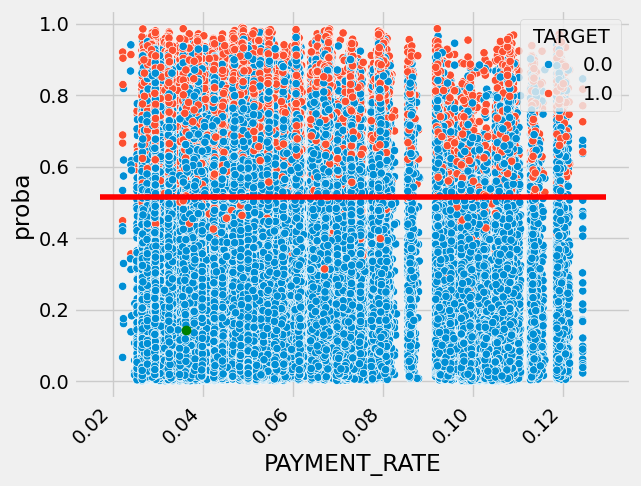

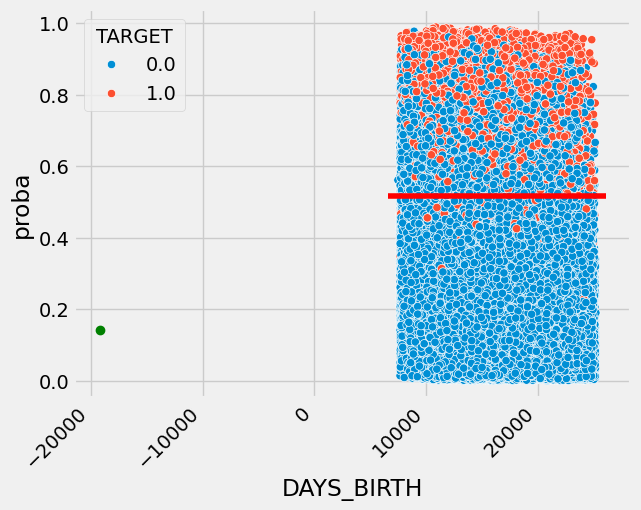

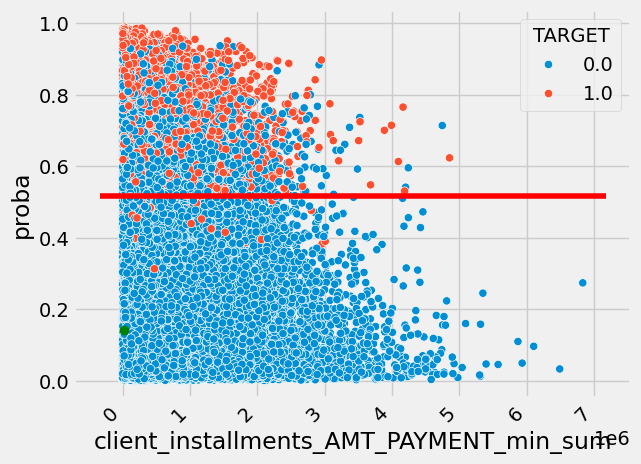

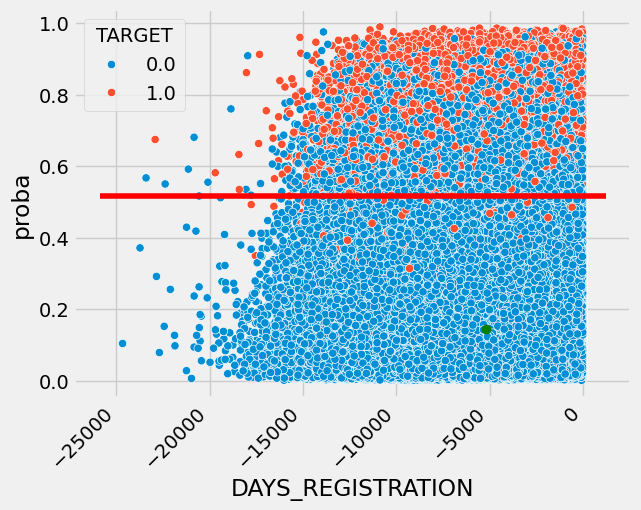

In [ ]:
for feat in df_feat.head(4).index:
    fig, ax = plt.subplots(1,1)
    sns.scatterplot(x=feat, y ='proba', hue = 'TARGET', data = train_test, ax = ax)
    x_min, x_max, y_min, y_max = plt.axis()
    plt.hlines(y = 0.4038, xmin = x_min, xmax = x_max, color = 'red')
    xp = test_test.loc[0, feat]
    yp = test_test.loc[0, 'proba']
    plt.plot(xp, yp, marker = 'o', color = 'green')
    plt.xticks(rotation = 45, ha = 'right');

In [ ]:
train_test[train_test.SK_ID_CURR==285505]

SK_ID_CURR  TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
160018      285505     0.0          171000.0    819432.0      23958.0   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
160018         684000.0                    0.008866       14594   

        DAYS_EMPLOYED  DAYS_REGISTRATION  ...  \
160018        -6959.0            -1491.0  ...   

        APP_SCORE2_TO_PHONE_CHANGE_RATIO  APP_EXT_SOURCE_1*EXT_SOURCE_2  \
160018                         -0.000285                       0.408453   

        APP_EXT_SOURCE_1*EXT_SOURCE_3  APP_EXT_SOURCE_2*EXT_SOURCE_3  \
160018                       0.541527                       0.310268   

        APP_EXT_SOURCE_1*DAYS_EMPLOYED  APP_EXT_SOURCE_2*DAYS_EMPLOYED  \
160018                    -5875.693849                     -3366.48573   

        APP_EXT_SOURCE_3*DAYS_EMPLOYED  APPS_GOODS_INCOME_RATIO  \
160018                    -4463.281704                      4.0   

        APP_DAYS_EMPLOYED_DAYS_BIRTH_diff     proba  
160018                           -21553.0  0.008476  

[1 rows x 350 columns]

In [ ]:
test2.head(3)

SK_ID_CURR  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0      100001          135000.0    568800.0      20560.5         450000.0   
1      100005           99000.0    222768.0      17370.0         180000.0   
2      100013          202500.0    663264.0      69777.0         630000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018850      -19241        -2329.0            -5170.0   
1                    0.035792      -18064        -4469.0            -9118.0   
2                    0.019101      -20038        -4458.0            -2175.0   

   DAYS_ID_PUBLISH  ...  APP_SCORE2_TO_POP_RATIO  \
0             -812  ...                41.891478   
1            -1623  ...                 8.148623   
2            -3503  ...                36.636136   

   APP_SCORE2_TO_PHONE_CHANGE_RATIO  APP_EXT_SOURCE_1*EXT_SOURCE_2  \
0                         -0.000454                       0.594305   
1                               NaN                       0.164783   
2                         -0.000818                            NaN   

   APP_EXT_SOURCE_1*EXT_SOURCE_3  APP_EXT_SOURCE_2*EXT_SOURCE_3  \
0                       0.120057                       0.125965   
1                       0.244619                       0.126276   
2                            NaN                       0.427564   

   APP_EXT_SOURCE_1*DAYS_EMPLOYED  APP_EXT_SOURCE_2*DAYS_EMPLOYED  \
0                    -1752.839149                    -1839.104984   
1                    -2524.941212                    -1303.408573   
2                             NaN                    -3119.649689   

   APP_EXT_SOURCE_3*DAYS_EMPLOYED  APPS_GOODS_INCOME_RATIO  \
0                     -371.521010                 3.333333   
1                    -1934.905690                 1.818182   
2                    -2723.799341                 3.111111   

   APP_DAYS_EMPLOYED_DAYS_BIRTH_diff  
0                            16912.0  
1                            13595.0  
2                            15580.0  

[3 rows x 348 columns]

In [98]:
_, train_samp = train_test_split(train_test, test_size = 0.01, stratify = train_test[['TARGET']])

In [99]:
_, test2_samp = train_test_split(test2, test_size = 0.01)

In [ ]:
train_samp.to_csv('train_samp.csv')
test2_samp.to_csv('test_samp.csv')

## /!\ Here to reload test_samp & train_samp.csv

In [11]:
train_samp = pd.read_csv('train_samp.csv', index_col=0)
test2_samp = pd.read_csv('test_samp.csv', index_col=0)

In [8]:
train_samp.head(3)

SK_ID_CURR  TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
118000      236835     0.0          157500.0    247500.0      12766.5   
160018      285505     0.0          171000.0    819432.0      23958.0   
65292       175729     0.0          112500.0    501435.0      23503.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
118000         247500.0                    0.026392       19597   
160018         684000.0                    0.008866       14594   
65292          414000.0                    0.024610       14499   

        DAYS_EMPLOYED  DAYS_REGISTRATION  ...  \
118000         -939.0           -10802.0  ...   
160018        -6959.0            -1491.0  ...   
65292         -7310.0             -182.0  ...   

        APP_SCORE2_TO_PHONE_CHANGE_RATIO  APP_EXT_SOURCE_1*EXT_SOURCE_2  \
118000                         -0.000307                            NaN   
160018                         -0.000285                       0.408453   
65292                          -0.000530                       0.187643   

        APP_EXT_SOURCE_1*EXT_SOURCE_3  APP_EXT_SOURCE_2*EXT_SOURCE_3  \
118000                            NaN                       0.325634   
160018                       0.541527                       0.310268   
65292                        0.193340                       0.419930   

        APP_EXT_SOURCE_1*DAYS_EMPLOYED  APP_EXT_SOURCE_2*DAYS_EMPLOYED  \
118000                             NaN                     -745.594127   
160018                    -5875.693849                    -3366.485730   
65292                     -2148.600689                    -4666.715901   

        APP_EXT_SOURCE_3*DAYS_EMPLOYED  APPS_GOODS_INCOME_RATIO  \
118000                     -385.086316                 1.571429   
160018                    -4463.281704                 4.000000   
65292                     -4808.399580                 3.680000   

        APP_DAYS_EMPLOYED_DAYS_BIRTH_diff     proba  
118000                           -20536.0  0.471715  
160018                           -21553.0  0.008476  
65292                            -21809.0  0.117563  

[3 rows x 350 columns]

In [12]:
train_samp.shape, test2_samp.shape

((3076, 350), (488, 348))

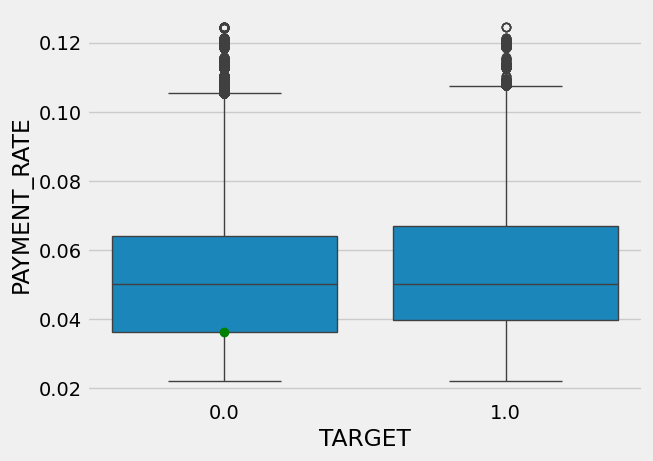

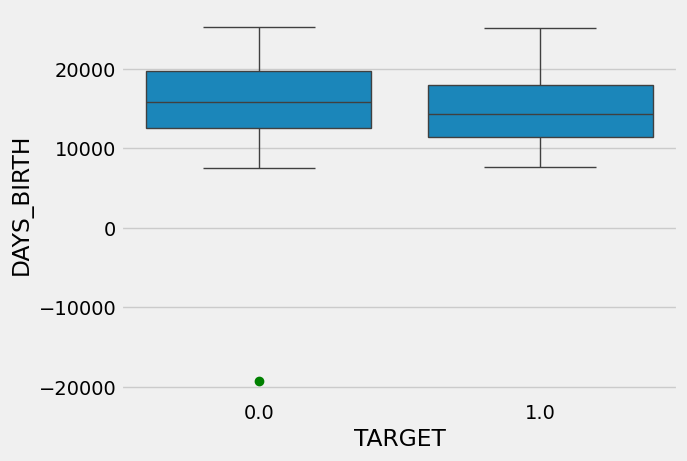

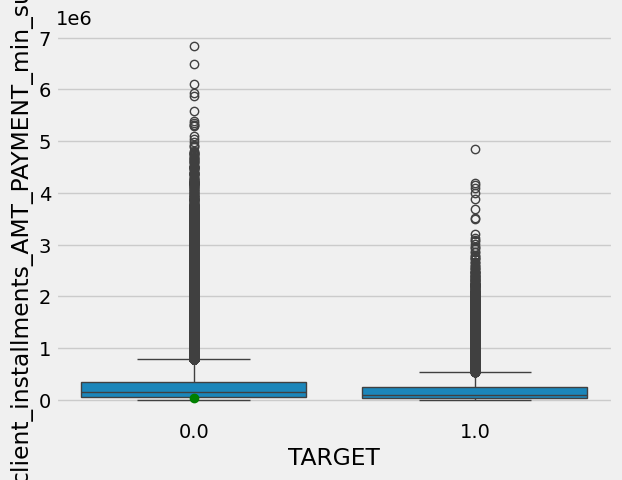

In [ ]:
for feat in df_feat.head(3).index:
    fig, ax = plt.subplots(1,1)
    sns.boxplot(x= 'TARGET', y = feat, data = train_test)
    xp = test_test.loc[0, feat]
    plt.plot(0, xp, marker = 'o', color = 'green');

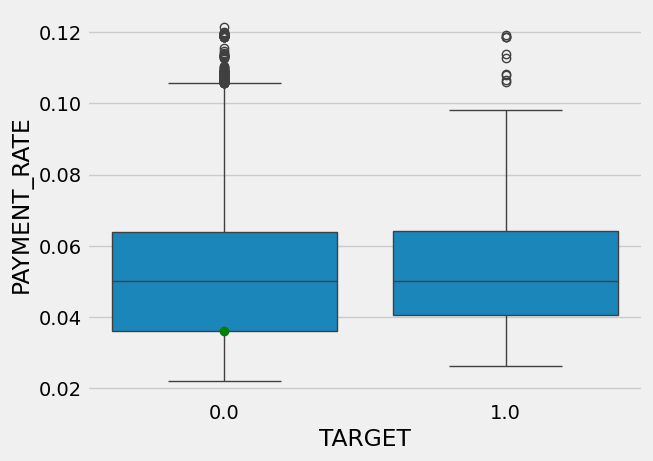

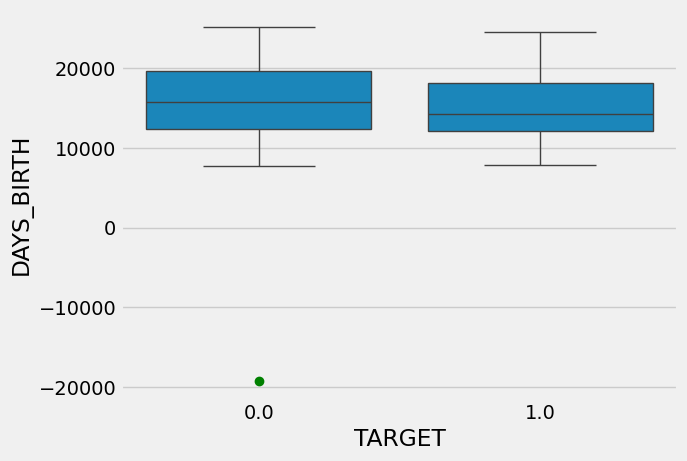

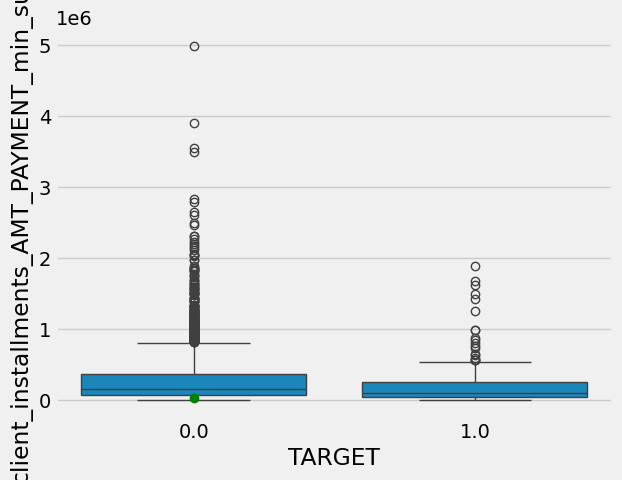

In [ ]:
for feat in df_feat.head(3).index:
    fig, ax = plt.subplots(1,1)
    sns.boxplot(x= 'TARGET', y = feat, data = train_samp)
    xp = test_test.loc[0, feat]
    plt.plot(0, xp, marker = 'o', color = 'green');

## XVII.13 Global interpretation <a class="anchor" id="18_13"></a>

### /!\ Shap values on train_sample

In [101]:
pipe_test[0]

ColumnTransformer(transformers=[('Cat',
                                 Pipeline(steps=[('LabelImputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('Encoder',
                                                  OrdinalEncoder())]),
                                 Index([], dtype='object')),
                                ('Num',
                                 Pipeline(steps=[('NumImputer',
                                                  SimpleImputer()),
                                                 ('Scaler', MinMaxScaler())]),
                                 Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE'...
       ...
       'APP_SCORE2_TO_POP_RATIO', 'APP_SCORE2_TO_PHONE_CHANGE_RATIO',
       'APP_EXT_SOURCE_1*EXT_SOURCE_2', 'APP_EXT_SOURCE_1*EXT_SOURCE_3',
       'APP_EXT_SOURCE_2*EXT_SOURCE_3', 'APP_EXT_SOURCE_1*DAYS_EMPLOYED',
       'APP_EXT_SOURCE_2*DAYS_EMPLOYED', 'APP_EXT_SOURCE_3*DAYS_EMPLOYED',
       'APPS_GOODS_INCOME_RATIO', 'APP_DAYS_EMPLOYED_DAYS_BIRTH_diff'],
      dtype='object', length=347))])

In [102]:
_, train2_samp = train_test_split(train2, test_size = 0.01, stratify = train2[['TARGET']])

In [103]:
explainer = shap.TreeExplainer(pipe_test[1], pipe_test[0].transform(train2_samp), check_additivity=False)

In [23]:
col = [ele.replace('#', '_') for ele in X.columns]

In [105]:
X_shap = pd.DataFrame(pipe_test[0].transform(train2_samp[col]), columns = col)
shap_val = explainer(X_shap, check_additivity=False)

100%|===================| 3073/3076 [00:42<00:00]        

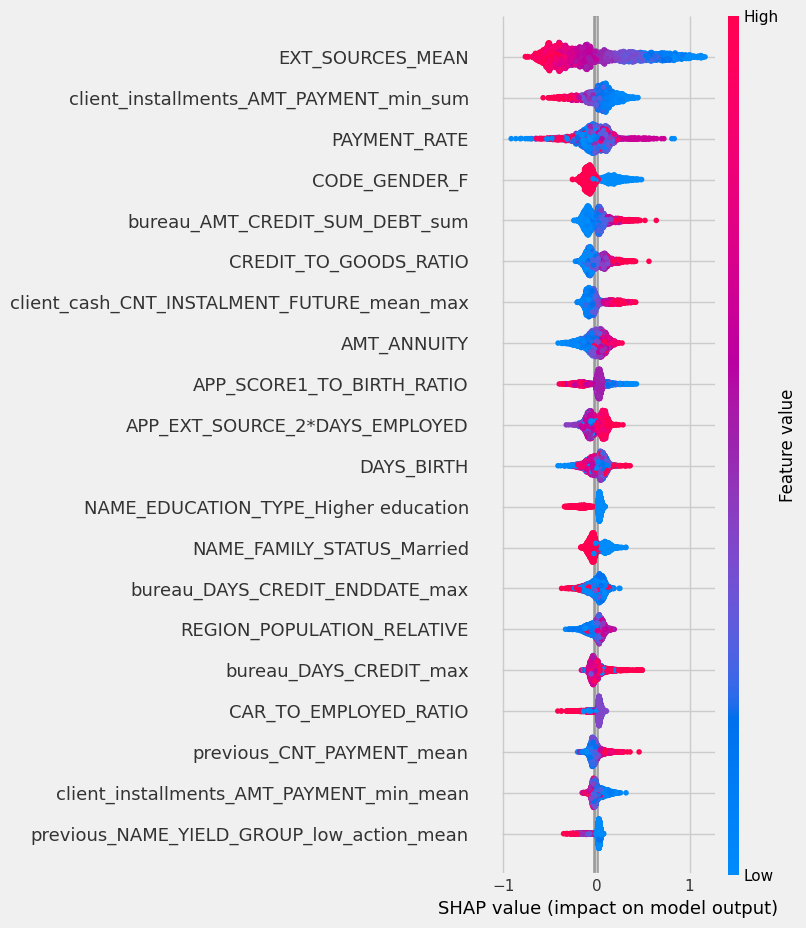

In [106]:
shap.summary_plot(shap_val, show=True)

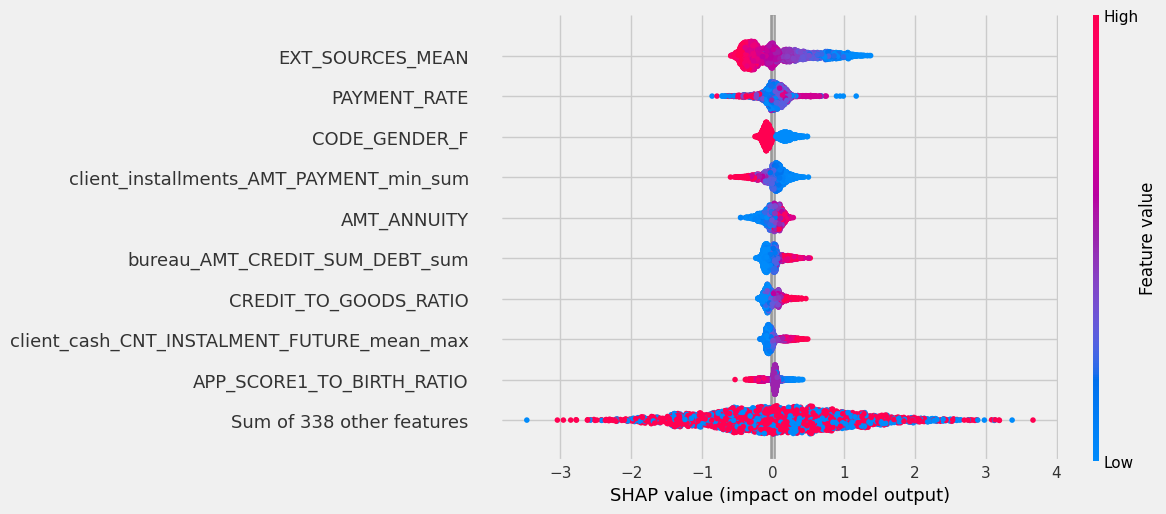

In [ ]:
shap.plots.beeswarm(shap_val)

## XVII.14 Local interpretation <a class="anchor" id="18_14"></a>

In [25]:
test2_samp

SK_ID_CURR  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
34482      351831          157500.0    488970.0      18562.5         337500.0   
14457      204226          193500.0    577147.5      24583.5         459000.0   
35072      356539           45000.0    450000.0      19048.5         450000.0   
5841       142752          171000.0   1065681.0      45148.5         904500.0   
31499      329086           76500.0    111384.0      10345.5          90000.0   
...           ...               ...         ...          ...              ...   
2141       115078          135000.0    695970.0      29614.5         553500.0   
22692      264979          360000.0   1415475.0      45792.0        1215000.0   
47265      445427          180000.0    156384.0      15597.0         135000.0   
1709       112105          180000.0    509400.0      40374.0         450000.0   
16596      219886          157500.0   1024740.0      52452.0         900000.0   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
34482                    0.018801      -20442            NaN   
14457                    0.010147      -20468       -13625.0   
35072                    0.046220      -20646            NaN   
5841                     0.018801      -19690        -8726.0   
31499                    0.020246      -10198         -286.0   
...                           ...         ...            ...   
2141                     0.011657      -12416         -277.0   
22692                    0.072508      -15252        -2271.0   
47265                    0.022625      -14287         -857.0   
1709                     0.007020      -13118        -1187.0   
16596                    0.010276      -12799         -716.0   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  ...  APP_SCORE2_TO_POP_RATIO  \
34482            -6314.0            -3608  ...                27.821509   
14457            -5282.0            -3689  ...                51.816033   
35072           -10262.0            -2884  ...                13.507131   
5841              -556.0            -3228  ...                24.540410   
31499            -1270.0            -2872  ...                12.547372   
...                  ...              ...  ...                      ...   
2141             -2828.0            -4840  ...                23.172117   
22692            -9380.0            -5355  ...                 8.056414   
47265             -555.0            -3692  ...                28.735616   
1709             -4408.0            -5383  ...                80.440636   
16596             -272.0            -2495  ...                47.516836   

       APP_SCORE2_TO_PHONE_CHANGE_RATIO  APP_EXT_SOURCE_1*EXT_SOURCE_2  \
34482                               NaN                            NaN   
14457                         -0.002767                       0.272784   
35072                         -0.000947                       0.402310   
5841                          -0.000149                       0.338756   
31499                         -0.000681                       0.078055   
...                                 ...                            ...   
2141                          -0.000129                       0.102157   
22692                         -0.000167                            NaN   
47265                         -0.000319                            NaN   
1709                          -0.001765                       0.276666   
16596                         -0.000240                       0.255413   

       APP_EXT_SOURCE_1*EXT_SOURCE_3  APP_EXT_SOURCE_2*EXT_SOURCE_3  \
34482                            NaN                       0.219091   
14457                       0.331030                       0.335469   
35072                       0.239939                       0.232448   
5841                             NaN                            NaN   
31499                       0.049014                       0.040523   
...                              ...             

In [26]:
Xtest_shap = pd.DataFrame(pipe_test[0].transform(test2_samp[col]), columns = col, index=test2_samp['SK_ID_CURR'])

In [27]:
# Fits the explainer
explainer_test = shap.TreeExplainer(pipe_test[1], pipe_test[0].transform(test2_samp), check_additivity=False)
# Calculates the SHAP values -
shap_values_test = explainer_test(Xtest_shap.loc[[351831]], check_additivity=False)
#save explainer to the disk
#filename = f'{path_to_dir}\\Method1\\explainer-test_sample.sav'
#pickle.dump(explainer_test, open(filename, 'wb'))

In [28]:
Xtest_shap.loc[[351831]]

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
351831              0.007335    0.110854     0.066093         0.074074   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
351831                        0.256321   -1.574464       0.866897   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  ...  \
SK_ID_CURR                                                   ...   
351831               0.744082          0.49868      0.13254  ...   

            APP_SCORE2_TO_POP_RATIO  APP_SCORE2_TO_PHONE_CHANGE_RATIO  \
SK_ID_CURR                                                              
351831                     0.011655                          0.987384   

            APP_EXT_SOURCE_1*EXT_SOURCE_2  APP_EXT_SOURCE_1*EXT_SOURCE_3  \
SK_ID_CURR                                                                 
351831                            0.36528                       0.329563   

            APP_EXT_SOURCE_2*EXT_SOURCE_3  APP_EXT_SOURCE_1*DAYS_EMPLOYED  \
SK_ID_CURR                                                                  
351831                           0.310871                        0.921158   

            APP_EXT_SOURCE_2*DAYS_EMPLOYED  APP_EXT_SOURCE_3*DAYS_EMPLOYED  \
SK_ID_CURR                                                                   
351831                            0.903314                        0.911199   

            APPS_GOODS_INCOME_RATIO  APP_DAYS_EMPLOYED_DAYS_BIRTH_diff  
SK_ID_CURR                                                              
351831                     0.024857                           0.729694  

[1 rows x 347 columns]

In [29]:
len(shap_values_test)

1

In [30]:
shap_values_test

.values =
array([[ 4.29414615e-03, -2.89159829e-03, -6.69165024e-02,
         2.61779760e-02,  5.50870365e-02,  0.00000000e+00,
         6.41519794e-03, -1.11001605e-02,  6.95723107e-03,
         3.55747287e-02, -1.29092833e-02, -1.93226603e-02,
         2.17334866e-02, -4.75152351e-03,  1.03262639e-02,
         1.99414192e-03, -2.84194753e-02, -1.04057415e-02,
        -2.20034936e-02,  2.06349571e-03,  6.34191437e-04,
         3.22445710e-03, -1.36265589e-02,  2.99196895e-02,
         8.09569566e-02, -7.95442646e-04, -4.52321224e-03,
         2.80848094e-03,  8.39510133e-03, -1.04513853e-03,
         1.11155286e-02,  2.69896991e-03,  1.38310918e-04,
         4.50123190e-04,  1.75321734e-03,  1.79124281e-03,
         3.60085249e-02,  3.75320400e-03, -9.26354407e-03,
         3.72771135e-02, -2.71203619e-03,  1.81439156e-04,
        -5.36925451e-03, -5.19684677e-02, -6.31143583e-04,
         6.33370987e-03, -2.98924439e-03,  7.89483936e-04,
        -1.56882453e-02, -2.37298564e-02, -9.3

In [31]:
np.array(shap_values_test.values.tolist())

array([[ 4.29414615e-03, -2.89159829e-03, -6.69165024e-02,
         2.61779760e-02,  5.50870365e-02,  0.00000000e+00,
         6.41519794e-03, -1.11001605e-02,  6.95723107e-03,
         3.55747287e-02, -1.29092833e-02, -1.93226603e-02,
         2.17334866e-02, -4.75152351e-03,  1.03262639e-02,
         1.99414192e-03, -2.84194753e-02, -1.04057415e-02,
        -2.20034936e-02,  2.06349571e-03,  6.34191437e-04,
         3.22445710e-03, -1.36265589e-02,  2.99196895e-02,
         8.09569566e-02, -7.95442646e-04, -4.52321224e-03,
         2.80848094e-03,  8.39510133e-03, -1.04513853e-03,
         1.11155286e-02,  2.69896991e-03,  1.38310918e-04,
         4.50123190e-04,  1.75321734e-03,  1.79124281e-03,
         3.60085249e-02,  3.75320400e-03, -9.26354407e-03,
         3.72771135e-02, -2.71203619e-03,  1.81439156e-04,
        -5.36925451e-03, -5.19684677e-02, -6.31143583e-04,
         6.33370987e-03, -2.98924439e-03,  7.89483936e-04,
        -1.56882453e-02, -2.37298564e-02, -9.34467620e-0

In [32]:
type(shap_values_test)

shap._explanation.Explanation

In [33]:
shap_values_test.feature_names

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_WORK_PHONE',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'COMMONAREA_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_S

In [34]:
import shap

# Create an empty Explanation object
explanation = shap.Explanation(values=shap_values_test.values, feature_names = shap_values_test.feature_names, 
                               data = shap_values_test.data, base_values = shap_values_test.base_values)

# Now you can use this empty explanation object as needed


In [35]:
explanation

.values =
array([[ 4.29414615e-03, -2.89159829e-03, -6.69165024e-02,
         2.61779760e-02,  5.50870365e-02,  0.00000000e+00,
         6.41519794e-03, -1.11001605e-02,  6.95723107e-03,
         3.55747287e-02, -1.29092833e-02, -1.93226603e-02,
         2.17334866e-02, -4.75152351e-03,  1.03262639e-02,
         1.99414192e-03, -2.84194753e-02, -1.04057415e-02,
        -2.20034936e-02,  2.06349571e-03,  6.34191437e-04,
         3.22445710e-03, -1.36265589e-02,  2.99196895e-02,
         8.09569566e-02, -7.95442646e-04, -4.52321224e-03,
         2.80848094e-03,  8.39510133e-03, -1.04513853e-03,
         1.11155286e-02,  2.69896991e-03,  1.38310918e-04,
         4.50123190e-04,  1.75321734e-03,  1.79124281e-03,
         3.60085249e-02,  3.75320400e-03, -9.26354407e-03,
         3.72771135e-02, -2.71203619e-03,  1.81439156e-04,
        -5.36925451e-03, -5.19684677e-02, -6.31143583e-04,
         6.33370987e-03, -2.98924439e-03,  7.89483936e-04,
        -1.56882453e-02, -2.37298564e-02, -9.3

In [36]:
shap_values_test.base_values

array([-1.5879989])

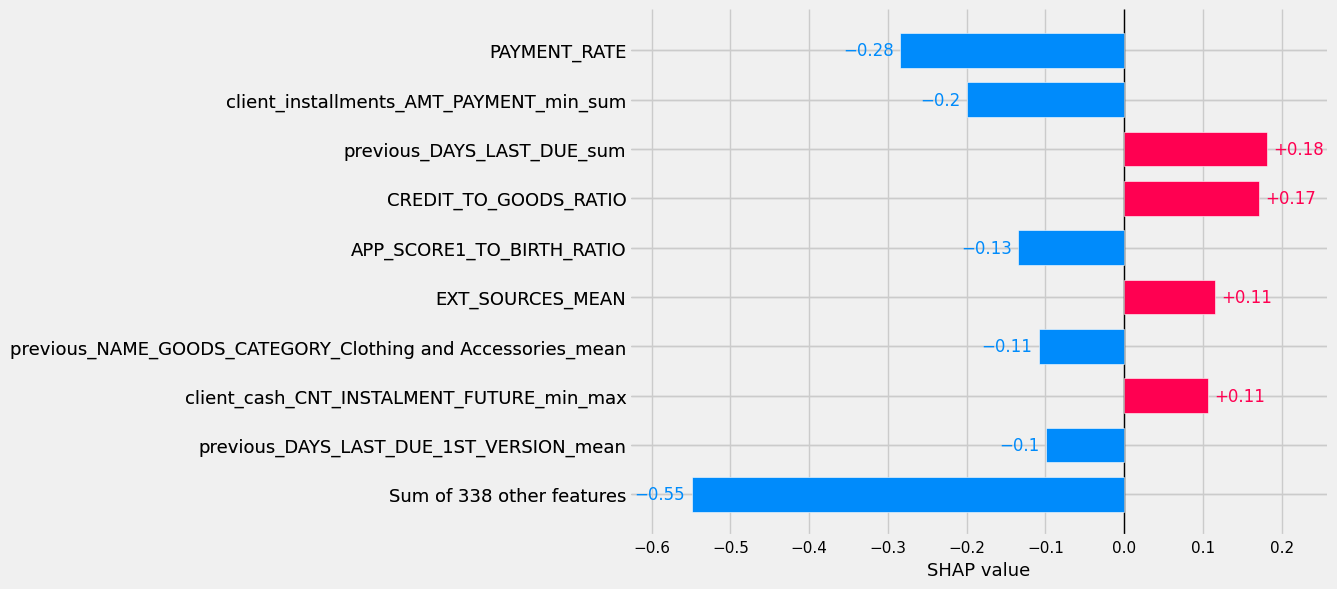

In [37]:
shap.plots.bar(explanation[0]) #individu 0

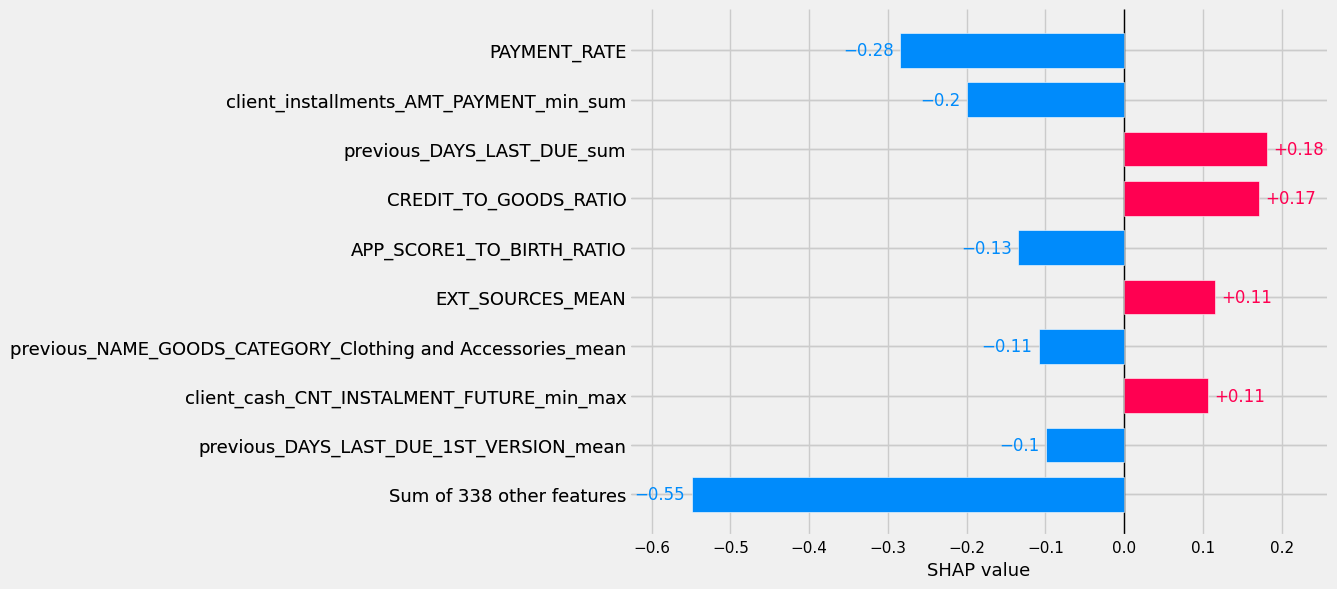

In [38]:
fig, ax = plt.subplots()

# Create the SHAP summary plot
shap.plots.bar(shap_values_test[0], show=False)
# Show the plot
# Save the plot as a PNG file
#fig.savefig('shap_summary_plot.png')

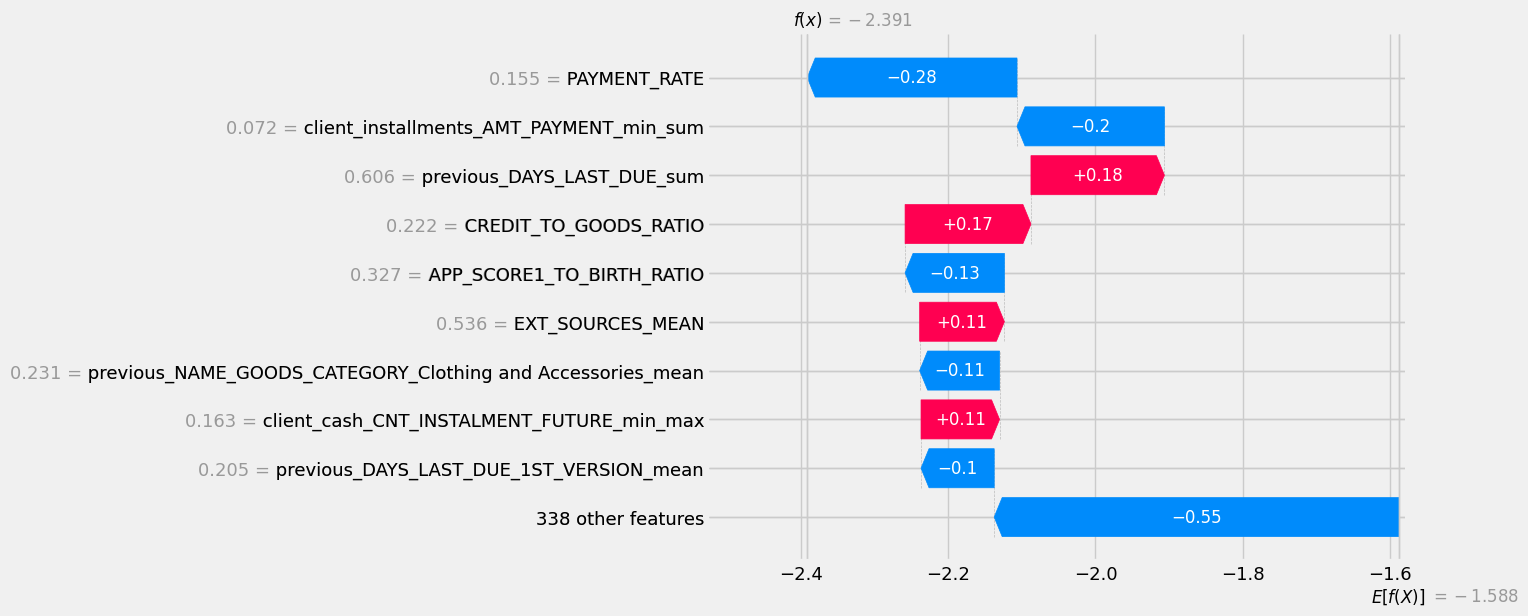

In [39]:
shap.plots.waterfall(explanation[0]) #individu 0

In [40]:
test2_samp.head(3)

SK_ID_CURR  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
34482      351831          157500.0    488970.0      18562.5         337500.0   
14457      204226          193500.0    577147.5      24583.5         459000.0   
35072      356539           45000.0    450000.0      19048.5         450000.0   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
34482                    0.018801      -20442            NaN   
14457                    0.010147      -20468       -13625.0   
35072                    0.046220      -20646            NaN   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  ...  APP_SCORE2_TO_POP_RATIO  \
34482            -6314.0            -3608  ...                27.821509   
14457            -5282.0            -3689  ...                51.816033   
35072           -10262.0            -2884  ...                13.507131   

       APP_SCORE2_TO_PHONE_CHANGE_RATIO  APP_EXT_SOURCE_1*EXT_SOURCE_2  \
34482                               NaN                            NaN   
14457                         -0.002767                       0.272784   
35072                         -0.000947                       0.402310   

       APP_EXT_SOURCE_1*EXT_SOURCE_3  APP_EXT_SOURCE_2*EXT_SOURCE_3  \
34482                            NaN                       0.219091   
14457                       0.331030                       0.335469   
35072                       0.239939                       0.232448   

       APP_EXT_SOURCE_1*DAYS_EMPLOYED  APP_EXT_SOURCE_2*DAYS_EMPLOYED  \
34482                             NaN                             NaN   
14457                    -7068.920784                    -7163.715573   
35072                             NaN                             NaN   

       APP_EXT_SOURCE_3*DAYS_EMPLOYED  APPS_GOODS_INCOME_RATIO  \
34482                             NaN                 2.142857   
14457                    -8693.343067                 2.372093   
35072                             NaN                10.000000   

       APP_DAYS_EMPLOYED_DAYS_BIRTH_diff  
34482                                NaN  
14457                             6843.0  
35072                                NaN  

[3 rows x 348 columns]

In [41]:
test2_samp.at[34482, 'EXT_SOURCES_MEAN']

0.470963237701826

In [43]:
Xtest_shap

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
351831              0.007335    0.110854     0.066093         0.074074   
204226              0.009338    0.132871     0.089575         0.104377   
356539              0.001077    0.101124     0.067989         0.102132   
142752              0.008086    0.254852     0.169779         0.215488   
329086              0.002829    0.016575     0.034047         0.012346   
...                      ...         ...          ...              ...   
115078              0.006084    0.162539     0.109196         0.127946   
264979              0.018601    0.342191     0.172289         0.292929   
445427              0.008587    0.027811     0.054528         0.023569   
112105              0.008587    0.115955     0.151158         0.102132   
219886              0.007335    0.244629     0.198263         0.214366   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
351831                        0.256321   -1.574464       0.866897   
204226                        0.136490   -1.575930       0.239337   
356539                        0.635991   -1.585964       0.866897   
142752                        0.256321   -1.532074       0.512841   
329086                        0.276330   -0.997012       0.984033   
...                                ...         ...            ...   
115078                        0.157398   -1.122041       0.984536   
264979                        1.000000   -1.281905       0.873213   
445427                        0.309272   -1.227508       0.952155   
112105                        0.093190   -1.161612       0.933732   
219886                        0.138276   -1.143630       0.960027   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  ...  \
SK_ID_CURR                                                   ...   
351831               0.744082         0.498680     0.132540  ...   
204226               0.785911         0.487425     0.132540  ...   
356539               0.584063         0.599277     0.132540  ...   
142752               0.977464         0.551480     0.197802  ...   
329086               0.948525         0.600945     0.132540  ...   
...                       ...              ...          ...  ...   
115078               0.885376         0.327498     0.132540  ...   
264979               0.619812         0.255940     0.043956  ...   
445427               0.977505         0.487008     0.132540  ...   
112105               0.821336         0.252049     0.132540  ...   
219886               0.988975         0.653328     0.132540  ...   

            APP_SCORE2_TO_POP_RATIO  APP_SCORE2_TO_PHONE_CHANGE_RATIO  \
SK_ID_CURR                                                              
351831                     0.011655                          0.987384   
204226                     0.021707                          0.996763   
356539                     0.005658                          0.998892   
142752                     0.010281                          0.999826   
329086                     0.005256                          0.999203   
...                             ...                               ...   
115078                     0.009707                          0.999849   
264979                     0.003375                          0.999805   
445427                     0.012038                          0.999626   
112105                     0.033698                          0.997936   
219886                     0.019906                          0.999720   

            APP_EXT_SOURCE_1*EXT_SOURCE_2  APP_EXT_SOURCE_1*EXT_SOURCE_3  \
SK_ID_CURR                                                                 
351831                           0.365280                       0.329563   
204226                           0.365631                       0.419529   
356539      

In [44]:
Xtest_shap.at[351831, 'EXT_SOURCES_MEAN']

0.5358501259884147

# XVIII. DATA DRIFT CHECK (New Saved model) <a class="anchor" id="19"></a>

[See Summary](#0)

In [ ]:
train2_samp.shape

(3076, 349)

In [ ]:
train2_samp.head(3)

SK_ID_CURR  TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
21478       125020     0.0          121500.0    179865.0      11502.0   
163592      289644     0.0           90000.0    107820.0       8190.0   
70162       181400     0.0          175500.0    619965.0      22905.0   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
21478          148500.0                    0.030755       22370   
163592          90000.0                    0.022625       20120   
70162          517500.0                    0.072508       22271   

        DAYS_EMPLOYED  DAYS_REGISTRATION  ...  APP_SCORE2_TO_POP_RATIO  \
21478             NaN            -7783.0  ...                16.986958   
163592            NaN            -5573.0  ...                28.898558   
70162         -1464.0            -9395.0  ...                10.379303   

        APP_SCORE2_TO_PHONE_CHANGE_RATIO  APP_EXT_SOURCE_1*EXT_SOURCE_2  \
21478                          -0.000203                            NaN   
163592                               NaN                            NaN   
70162                          -0.000869                            NaN   

        APP_EXT_SOURCE_1*EXT_SOURCE_3  APP_EXT_SOURCE_2*EXT_SOURCE_3  \
21478                             NaN                       0.213341   
163592                            NaN                       0.341755   
70162                             NaN                            NaN   

        APP_EXT_SOURCE_1*DAYS_EMPLOYED  APP_EXT_SOURCE_2*DAYS_EMPLOYED  \
21478                              NaN                             NaN   
163592                             NaN                             NaN   
70162                              NaN                    -1101.780749   

        APP_EXT_SOURCE_3*DAYS_EMPLOYED  APPS_GOODS_INCOME_RATIO  \
21478                              NaN                 1.222222   
163592                             NaN                 1.000000   
70162                              NaN                 2.948718   

        APP_DAYS_EMPLOYED_DAYS_BIRTH_diff  
21478                                 NaN  
163592                                NaN  
70162                            -23735.0  

[3 rows x 349 columns]

In [ ]:
to_remove = ['SK_ID_CURR', 'TARGET']

In [ ]:
train_ddrift = train2_samp.drop(columns=[ele for ele in train2_samp if ele in to_remove])
test_ddrift = test2_samp.drop(columns=[ele for ele in test2_samp if ele in to_remove])

In [ ]:
tests = TestSuite(tests=[
    TestNumberOfColumnsWithMissingValues(),
    TestNumberOfRowsWithMissingValues(),
    TestNumberOfConstantColumns(),
    TestNumberOfDuplicatedRows(),
    TestNumberOfDuplicatedColumns(),
    TestColumnsType(),
    TestNumberOfDriftedColumns(),
])

tests.run(reference_data=train_ddrift, current_data=test_ddrift)
tests

In [ ]:
report = Report(metrics=[
    DataDriftPreset(num_stattest_threshold=0.1), 
])

report.run(reference_data=train_ddrift, current_data=test_ddrift)

report.save_html('ddrift_report.html')

# XIX. PREPARATIONS FOR API & DASHBOARD <a class="anchor" id="20"></a>

In [ ]:
Xtest_shap.head(3)

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          0.007335    0.110854     0.066093         0.074074   
1          0.009338    0.132871     0.089575         0.104377   
2          0.001077    0.101124     0.067989         0.102132   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.256321   -1.574464       0.866897           0.744082   
1                    0.136490   -1.575930       0.239337           0.785911   
2                    0.635991   -1.585964       0.866897           0.584063   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  ...  APP_SCORE2_TO_POP_RATIO  \
0         0.498680      0.13254  ...                 0.011655   
1         0.487425      0.13254  ...                 0.021707   
2         0.599277      0.13254  ...                 0.005658   

   APP_SCORE2_TO_PHONE_CHANGE_RATIO  APP_EXT_SOURCE_1*EXT_SOURCE_2  \
0                          0.987384                       0.365280   
1                          0.996763                       0.365631   
2                          0.998892                       0.539244   

   APP_EXT_SOURCE_1*EXT_SOURCE_3  APP_EXT_SOURCE_2*EXT_SOURCE_3  \
0                       0.329563                       0.310871   
1                       0.419529                       0.476001   
2                       0.304080                       0.329823   

   APP_EXT_SOURCE_1*DAYS_EMPLOYED  APP_EXT_SOURCE_2*DAYS_EMPLOYED  \
0                        0.921158                        0.903314   
1                        0.528696                        0.455601   
2                        0.921158                        0.903314   

   APP_EXT_SOURCE_3*DAYS_EMPLOYED  APPS_GOODS_INCOME_RATIO  \
0                        0.911199                 0.024857   
1                        0.406308                 0.027563   
2                        0.911199                 0.117622   

   APP_DAYS_EMPLOYED_DAYS_BIRTH_diff  
0                           0.729694  
1                           1.420812  
2                           0.729694  

[3 rows x 347 columns]

In [ ]:
Xtest_samp = Xtest_shap.copy()

In [ ]:
test2_samp.index

Index([34482, 14457, 35072,  5841, 31499,  3606, 32321, 45194, 41461, 43356,
       ...
       19213, 11976, 34753, 13757, 23609,  2141, 22692, 47265,  1709, 16596],
      dtype='int64', length=488)

In [ ]:
Xtest_samp = Xtest_samp.set_index(pd.Series(list(test2_samp.index)))

In [ ]:
json_client = Xtest_samp.loc[int(34482)].to_json()

In [ ]:
print(json_client)

{"AMT_INCOME_TOTAL":0.0073354163,"AMT_CREDIT":0.1108539326,"AMT_ANNUITY":0.0660933661,"AMT_GOODS_PRICE":0.0740740741,"REGION_POPULATION_RELATIVE":0.2563211388,"DAYS_BIRTH":-1.574464487,"DAYS_EMPLOYED":0.8668966026,"DAYS_REGISTRATION":0.7440823606,"DAYS_ID_PUBLISH":0.4986800056,"OWN_CAR_AGE":0.1325397876,"FLAG_WORK_PHONE":0.0,"REGION_RATING_CLIENT_W_CITY":0.5,"HOUR_APPR_PROCESS_START":0.6086956522,"REG_CITY_NOT_LIVE_CITY":0.0,"EXT_SOURCE_1":0.5142378554,"EXT_SOURCE_2":0.611780537,"EXT_SOURCE_3":0.4671527631,"APARTMENTS_AVG":0.0258,"BASEMENTAREA_AVG":0.0,"YEARS_BEGINEXPLUATATION_AVG":0.9707,"YEARS_BUILD_AVG":0.7524715116,"COMMONAREA_AVG":0.0446211398,"ENTRANCES_AVG":0.0345,"FLOORSMAX_AVG":0.0417,"LANDAREA_AVG":0.0,"LIVINGAPARTMENTS_AVG":0.1007759737,"LIVINGAREA_AVG":0.0108,"NONLIVINGAREA_AVG":0.0,"APARTMENTS_MODE":0.0263,"BASEMENTAREA_MODE":0.0,"YEARS_BEGINEXPLUATATION_MODE":0.9707,"YEARS_BUILD_MODE":0.7596373497,"COMMONAREA_MODE":0.0425535388,"LANDAREA_MODE":0.0,"LIVINGAPARTMENTS_MODE":

In [ ]:
Xtest_samp2 = Xtest_samp.copy()

In [ ]:
Xtest_samp2.columns = [ele.replace('_', "#") for ele in Xtest_samp]

In [ ]:
Xtest_samp2

AMT#INCOME#TOTAL  AMT#CREDIT  AMT#ANNUITY  AMT#GOODS#PRICE  \
34482          0.007335    0.110854     0.066093         0.074074   
14457          0.009338    0.132871     0.089575         0.104377   
35072          0.001077    0.101124     0.067989         0.102132   
5841           0.008086    0.254852     0.169779         0.215488   
31499          0.002829    0.016575     0.034047         0.012346   
...                 ...         ...          ...              ...   
2141           0.006084    0.162539     0.109196         0.127946   
22692          0.018601    0.342191     0.172289         0.292929   
47265          0.008587    0.027811     0.054528         0.023569   
1709           0.008587    0.115955     0.151158         0.102132   
16596          0.007335    0.244629     0.198263         0.214366   

       REGION#POPULATION#RELATIVE  DAYS#BIRTH  DAYS#EMPLOYED  \
34482                    0.256321   -1.574464       0.866897   
14457                    0.136490   -1.575930       0.239337   
35072                    0.635991   -1.585964       0.866897   
5841                     0.256321   -1.532074       0.512841   
31499                    0.276330   -0.997012       0.984033   
...                           ...         ...            ...   
2141                     0.157398   -1.122041       0.984536   
22692                    1.000000   -1.281905       0.873213   
47265                    0.309272   -1.227508       0.952155   
1709                     0.093190   -1.161612       0.933732   
16596                    0.138276   -1.143630       0.960027   

       DAYS#REGISTRATION  DAYS#ID#PUBLISH  OWN#CAR#AGE  ...  \
34482           0.744082         0.498680     0.132540  ...   
14457           0.785911         0.487425     0.132540  ...   
35072           0.584063         0.599277     0.132540  ...   
5841            0.977464         0.551480     0.197802  ...   
31499           0.948525         0.600945     0.132540  ...   
...                  ...              ...          ...  ...   
2141            0.885376         0.327498     0.132540  ...   
22692           0.619812         0.255940     0.043956  ...   
47265           0.977505         0.487008     0.132540  ...   
1709            0.821336         0.252049     0.132540  ...   
16596           0.988975         0.653328     0.132540  ...   

       APP#SCORE2#TO#POP#RATIO  APP#SCORE2#TO#PHONE#CHANGE#RATIO  \
34482                 0.011655                          0.987384   
14457                 0.021707                          0.996763   
35072                 0.005658                          0.998892   
5841                  0.010281                          0.999826   
31499                 0.005256                          0.999203   
...                        ...                               ...   
2141                  0.009707                          0.999849   
22692                 0.003375                          0.999805   
47265                 0.012038                          0.999626   
1709                  0.033698                          0.997936   
16596                 0.019906                          0.999720   

       APP#EXT#SOURCE#1*EXT#SOURCE#2  APP#EXT#SOURCE#1*EXT#SOURCE#3  \
34482                       0.365280                       0.329563   
14457                       0.365631                       0.419529   
35072                       0.539244                       0.304080   
5841                        0.454058                       0.329563   
31499                       0.104623                       0.062103   
...                              ...                            ...   
2141                        0.136929                       0.382549   
22692                       0.365280                       0.329563   
47265                       0.365280                       0.329563   
1709                        0.370835                       0.329563   
16596                       0.342348                  

In [ ]:
json_client = Xtest_samp2.loc[int(34482)].to_json()

In [ ]:
print(json_client)

{"AMT#INCOME#TOTAL":0.0073354163,"AMT#CREDIT":0.1108539326,"AMT#ANNUITY":0.0660933661,"AMT#GOODS#PRICE":0.0740740741,"REGION#POPULATION#RELATIVE":0.2563211388,"DAYS#BIRTH":-1.574464487,"DAYS#EMPLOYED":0.8668966026,"DAYS#REGISTRATION":0.7440823606,"DAYS#ID#PUBLISH":0.4986800056,"OWN#CAR#AGE":0.1325397876,"FLAG#WORK#PHONE":0.0,"REGION#RATING#CLIENT#W#CITY":0.5,"HOUR#APPR#PROCESS#START":0.6086956522,"REG#CITY#NOT#LIVE#CITY":0.0,"EXT#SOURCE#1":0.5142378554,"EXT#SOURCE#2":0.611780537,"EXT#SOURCE#3":0.4671527631,"APARTMENTS#AVG":0.0258,"BASEMENTAREA#AVG":0.0,"YEARS#BEGINEXPLUATATION#AVG":0.9707,"YEARS#BUILD#AVG":0.7524715116,"COMMONAREA#AVG":0.0446211398,"ENTRANCES#AVG":0.0345,"FLOORSMAX#AVG":0.0417,"LANDAREA#AVG":0.0,"LIVINGAPARTMENTS#AVG":0.1007759737,"LIVINGAREA#AVG":0.0108,"NONLIVINGAREA#AVG":0.0,"APARTMENTS#MODE":0.0263,"BASEMENTAREA#MODE":0.0,"YEARS#BEGINEXPLUATATION#MODE":0.9707,"YEARS#BUILD#MODE":0.7596373497,"COMMONAREA#MODE":0.0425535388,"LANDAREA#MODE":0.0,"LIVINGAPARTMENTS#MODE":

In [ ]:
pipe_test = joblib.load('model.joblib')

In [ ]:
joblib_in = open("model.joblib","rb")
model=joblib.load(joblib_in)

In [ ]:
type(pipe_test)

imblearn.pipeline.Pipeline

In [ ]:
pipe_test[1]

LGBMClassifier(class_weight={0: 0.08, 1: 0.92}, learning_rate=0.2, max_bin=1300,
               min_child_samples=700, n_estimators=200, n_jobs=-1,
               num_leaves=60, random_state=100, reg_alpha=0.1, reg_lambda=0.3)

In [ ]:
model[1]

LGBMClassifier(class_weight={0: 0.08, 1: 0.92}, learning_rate=0.2, max_bin=1300,
               min_child_samples=700, n_estimators=200, n_jobs=-1,
               num_leaves=60, random_state=100, reg_alpha=0.1, reg_lambda=0.3)

## /!\ Creation of json files for Pytest

In [ ]:
# Select a specific row (e.g., the first row)
row_index = 0
row_data = X.iloc[row_index]

# Convert the row to a JSON object
json_object = row_data.to_dict()

print(json_object)

{'AMT#INCOME#TOTAL': 0.009838971339301809, 'AMT#CREDIT': 0.09028651685393257, 'AMT#ANNUITY': 0.09003159003159003, 'AMT#GOODS#PRICE': 0.07744107744107744, 'REGION#POPULATION#RELATIVE': 0.25632113877426677, 'DAYS#BIRTH': 0.11116121758737318, 'DAYS#EMPLOYED': 0.9644372487717732, 'DAYS#REGISTRATION': 0.8521400778210116, 'DAYS#ID#PUBLISH': 0.7054328192302348, 'OWN#CAR#AGE': 0.13253978761724028, 'FLAG#WORK#PHONE': 0.0, 'REGION#RATING#CLIENT#W#CITY': 0.5, 'HOUR#APPR#PROCESS#START': 0.43478260869565216, 'REG#CITY#NOT#LIVE#CITY': 0.0, 'EXT#SOURCE#1': 0.07221501501380354, 'EXT#SOURCE#2': 0.3075422675356639, 'EXT#SOURCE#3': 0.1550544520000416, 'APARTMENTS#AVG': 0.0247, 'BASEMENTAREA#AVG': 0.0369, 'YEARS#BEGINEXPLUATATION#AVG': 0.9722, 'YEARS#BUILD#AVG': 0.6192, 'COMMONAREA#AVG': 0.0143, 'ENTRANCES#AVG': 0.069, 'FLOORSMAX#AVG': 0.0833, 'LANDAREA#AVG': 0.0369, 'LIVINGAPARTMENTS#AVG': 0.0202, 'LIVINGAREA#AVG': 0.019, 'NONLIVINGAREA#AVG': 0.0, 'APARTMENTS#MODE': 0.0252, 'BASEMENTAREA#MODE': 0.0383, '

In [ ]:
import json

In [ ]:
# Specify the file path where you want to save the JSON file
file_path = "output.json"

# Save the JSON data to the file
with open(file_path, 'w') as json_file:
    json.dump(json_object, json_file, indent=2)

print(f"JSON data has been saved to {file_path}")

In [ ]:
# Specify the path to your JSON file
file_path = "output.json"

# Open the file and read its contents
with open(file_path, 'r') as json_file:
    # Load the JSON data from the file
    json_data = json.load(json_file)

# Now, json_data is a Python object representing the contents of the JSON file
print(json_data)

{'AMT#INCOME#TOTAL': 0.009838971339301809, 'AMT#CREDIT': 0.09028651685393257, 'AMT#ANNUITY': 0.09003159003159003, 'AMT#GOODS#PRICE': 0.07744107744107744, 'REGION#POPULATION#RELATIVE': 0.25632113877426677, 'DAYS#BIRTH': 0.11116121758737318, 'DAYS#EMPLOYED': 0.9644372487717732, 'DAYS#REGISTRATION': 0.8521400778210116, 'DAYS#ID#PUBLISH': 0.7054328192302348, 'OWN#CAR#AGE': 0.13253978761724028, 'FLAG#WORK#PHONE': 0.0, 'REGION#RATING#CLIENT#W#CITY': 0.5, 'HOUR#APPR#PROCESS#START': 0.43478260869565216, 'REG#CITY#NOT#LIVE#CITY': 0.0, 'EXT#SOURCE#1': 0.07221501501380354, 'EXT#SOURCE#2': 0.3075422675356639, 'EXT#SOURCE#3': 0.1550544520000416, 'APARTMENTS#AVG': 0.0247, 'BASEMENTAREA#AVG': 0.0369, 'YEARS#BEGINEXPLUATATION#AVG': 0.9722, 'YEARS#BUILD#AVG': 0.6192, 'COMMONAREA#AVG': 0.0143, 'ENTRANCES#AVG': 0.069, 'FLOORSMAX#AVG': 0.0833, 'LANDAREA#AVG': 0.0369, 'LIVINGAPARTMENTS#AVG': 0.0202, 'LIVINGAREA#AVG': 0.019, 'NONLIVINGAREA#AVG': 0.0, 'APARTMENTS#MODE': 0.0252, 'BASEMENTAREA#MODE': 0.0383, '

In [ ]:
train_samp = pd.read_csv('train_samp.csv', index_col=0)

In [ ]:
train_samp

SK_ID_CURR  TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
118000      236835     0.0          157500.0    247500.0      12766.5   
160018      285505     0.0          171000.0    819432.0      23958.0   
65292       175729     0.0          112500.0    501435.0      23503.5   
65572       176050     0.0          247500.0    270000.0      13500.0   
155356      280098     0.0          189000.0    942300.0      30528.0   
...            ...     ...               ...         ...          ...   
103655      220305     0.0          180000.0   1214100.0      67923.0   
206838      339747     0.0          247500.0    888723.0      56925.0   
95649       211046     0.0          171000.0    497520.0      25402.5   
189348      319535     0.0          112500.0    454500.0      27063.0   
38200       144240     0.0          135000.0    986553.0      28975.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
118000         247500.0                    0.026392       19597   
160018         684000.0                    0.008866       14594   
65292          414000.0                    0.024610       14499   
65572          270000.0                    0.025164       10517   
155356         675000.0                    0.016612       19945   
...                 ...                         ...         ...   
103655        1125000.0                    0.011657       11991   
206838         823500.0                    0.046220       11063   
95649          450000.0                    0.022800       15112   
189348         454500.0                    0.030755       23780   
38200          823500.0                    0.030755       17553   

        DAYS_EMPLOYED  DAYS_REGISTRATION  ...  \
118000         -939.0           -10802.0  ...   
160018        -6959.0            -1491.0  ...   
65292         -7310.0             -182.0  ...   
65572         -1336.0            -4440.0  ...   
155356         -204.0           -11702.0  ...   
...               ...                ...  ...   
103655        -2619.0            -6209.0  ...   
206838         -949.0            -5340.0  ...   
95649          -173.0             -780.0  ...   
189348        -7632.0            -5904.0  ...   
38200         -1588.0            -3564.0  ...   

        APP_SCORE2_TO_PHONE_CHANGE_RATIO  APP_EXT_SOURCE_1*EXT_SOURCE_2  \
118000                         -0.000307                            NaN   
160018                         -0.000285                       0.408453   
65292                          -0.000530                       0.187643   
65572                          -0.000666                            NaN   
155356                         -0.003721                            NaN   
...                                  ...                            ...   
103655                               NaN                       0.280651   
206838                         -0.000333                       0.144761   
95649                          -0.001594                            NaN   
189348                         -0.000326                            NaN   
38200                          -0.000385                            NaN   

        APP_EXT_SOURCE_1*EXT_SOURCE_3  APP_EXT_SOURCE_2*EXT_SOURCE_3  \
118000                            NaN                       0.325634   
160018                       0.541527                       0.310268   
65292                        0.193340                       0.419930   
65572                             NaN                       0.098199   
155356                            NaN                       0.150868   
...                               ...                            ...   
103655                            NaN                            NaN   
206838                       0.267550                       0.199721   
95649                             NaN                            NaN   
189348                            NaN                       0.346483   
38200                             NaN       

<AxesSubplot: xlabel='proba', ylabel='Density'>

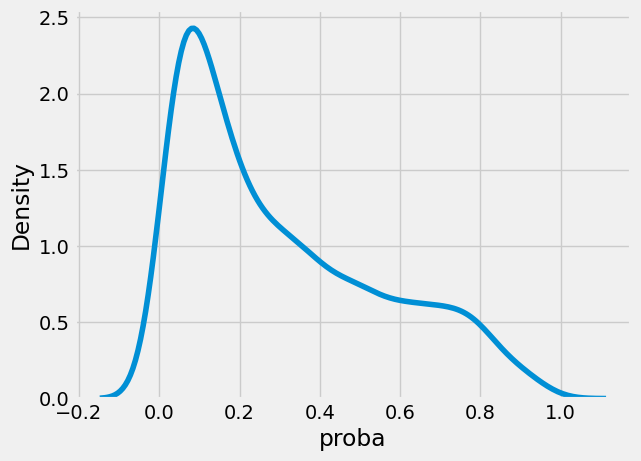

In [ ]:
sns.kdeplot(train_samp, x='proba')

proba 236835 = 0.471715

In [ ]:
sample = train_samp.set_index('SK_ID_CURR')

In [ ]:
ind = sample.index

In [ ]:
sample = sample.drop(columns=['TARGET', 'proba'])

In [ ]:
new_col = [ele.replace('_', '#') for ele in sample.columns]

In [ ]:
sample.columns = new_col

In [ ]:
sample = pd.DataFrame(final_pipe[0].transform(sample[new_col]), columns = new_col)
sample = sample.set_index(pd.Series(ind))

In [ ]:
sample

AMT#INCOME#TOTAL  AMT#CREDIT  AMT#ANNUITY  AMT#GOODS#PRICE  \
SK_ID_CURR                                                               
236835              0.007335    0.050562     0.043489         0.051627   
285505              0.008086    0.193366     0.087136         0.160494   
175729              0.004832    0.113966     0.085363         0.093154   
176050              0.012343    0.056180     0.046350         0.057239   
280098              0.009088    0.224045     0.112759         0.158249   
...                      ...         ...          ...              ...   
220305              0.008587    0.291910     0.258600         0.270483   
339747              0.012343    0.210667     0.215707         0.195286   
211046              0.008086    0.112989     0.092769         0.102132   
319535              0.004832    0.102247     0.099245         0.103255   
144240              0.006084    0.235094     0.106704         0.195286   

            REGION#POPULATION#RELATIVE  DAYS#BIRTH  DAYS#EMPLOYED  \
SK_ID_CURR                                                          
236835                        0.361433    0.682525       0.947577   
285505                        0.118752    0.400507       0.611490   
175729                        0.336758    0.395152       0.591894   
176050                        0.344429    0.170688       0.925413   
280098                        0.226010    0.702142       0.988611   
...                                ...         ...            ...   
220305                        0.157398    0.253777       0.853785   
339747                        0.635991    0.201466       0.947019   
211046                        0.311695    0.429707       0.990342   
319535                        0.421848    0.918320       0.573917   
144240                        0.421848    0.567306       0.911344   

            DAYS#REGISTRATION  DAYS#ID#PUBLISH  OWN#CAR#AGE  ...  \
SK_ID_CURR                                                   ...   
236835               0.562176         0.568292     0.132540  ...   
285505               0.939567         0.492427     0.132540  ...   
175729               0.992623         0.447825     0.197802  ...   
176050               0.820039         0.579547     0.120879  ...   
280098               0.525697         0.516187     0.132540  ...   
...                       ...              ...          ...  ...   
220305               0.748338         0.939558     0.054945  ...   
339747               0.783560         0.679589     0.043956  ...   
211046               0.968385         0.293456     0.000000  ...   
319535               0.760700         0.320272     0.132540  ...   
144240               0.855545         0.849660     0.132540  ...   

            APP#SCORE2#TO#POP#RATIO  APP#SCORE2#TO#PHONE#CHANGE#RATIO  \
SK_ID_CURR                                                              
236835                     0.012604                          0.999641   
285505                     0.022858                          0.999666   
175729                     0.010867                          0.999380   
176050                     0.004312                          0.999221   
280098                     0.013137                          0.995648   
...                             ...                               ...   
220305                     0.020814                          0.987384   
339747                     0.002979                          0.999610   
211046                     0.007088                          0.998136   
319535                     0.008877                          0.999619   
144240                     0.005649                          0.999550   

            APP#EXT#SOURCE#1*EXT#SOURCE#2  APP#EXT#SOURCE#1*EXT#SOURCE#3  \
SK_ID_CURR                                                                 
236835                           0.365280                       0.329563   
285505                           0.547478                       0.686312   
175729      

In [ ]:
sample1 = sample.loc[int(236835)].to_json()

In [ ]:
sample1

'{"AMT#INCOME#TOTAL":0.0073354163,"AMT#CREDIT":0.0505617978,"AMT#ANNUITY":0.0434889435,"AMT#GOODS#PRICE":0.051627385,"REGION#POPULATION#RELATIVE":0.3614334376,"DAYS#BIRTH":0.6825253664,"DAYS#EMPLOYED":0.9475770433,"DAYS#REGISTRATION":0.5621757458,"DAYS#ID#PUBLISH":0.568292344,"OWN#CAR#AGE":0.1325397876,"FLAG#WORK#PHONE":0.0,"REGION#RATING#CLIENT#W#CITY":0.5,"HOUR#APPR#PROCESS#START":0.5217391304,"REG#CITY#NOT#LIVE#CITY":0.0,"EXT#SOURCE#1":0.5142378554,"EXT#SOURCE#2":0.928690361,"EXT#SOURCE#3":0.4573795765,"APARTMENTS#AVG":0.0722,"BASEMENTAREA#AVG":0.0884424657,"YEARS#BEGINEXPLUATATION#AVG":0.9811,"YEARS#BUILD#AVG":0.7524715116,"COMMONAREA#AVG":0.0446211398,"ENTRANCES#AVG":0.1379,"FLOORSMAX#AVG":0.1667,"LANDAREA#AVG":0.066333831,"LIVINGAPARTMENTS#AVG":0.1007759737,"LIVINGAREA#AVG":0.0617,"NONLIVINGAREA#AVG":0.0,"APARTMENTS#MODE":0.0735,"BASEMENTAREA#MODE":0.0875433351,"YEARS#BEGINEXPLUATATION#MODE":0.9811,"YEARS#BUILD#MODE":0.7596373497,"COMMONAREA#MODE":0.0425535388,"LANDAREA#MODE":0.0

In [ ]:
def createsjson(ind:int = 236835):
    dico = {236835:1, 285505:0}
    sample1 = sample.loc[int(ind)].to_json()
    # Specify the file path where you want to save the JSON file
    file_path = f"intput{dico[ind]}.json"

    # Save the JSON data to the file
    with open(file_path, 'w') as json_file:
        json.dump(sample1, json_file, indent=2)
    return print(f"JSON data has been saved to {file_path}")

In [ ]:
createsjson(285505)

JSON data has been saved to intput0.json


In [ ]:
train_test[train_test.SK_ID_CURR==285505]

SK_ID_CURR  TARGET  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
160018      285505     0.0          171000.0    819432.0      23958.0   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
160018         684000.0                    0.008866       14594   

        DAYS_EMPLOYED  DAYS_REGISTRATION  ...  \
160018        -6959.0            -1491.0  ...   

        APP_SCORE2_TO_PHONE_CHANGE_RATIO  APP_EXT_SOURCE_1*EXT_SOURCE_2  \
160018                         -0.000285                       0.408453   

        APP_EXT_SOURCE_1*EXT_SOURCE_3  APP_EXT_SOURCE_2*EXT_SOURCE_3  \
160018                       0.541527                       0.310268   

        APP_EXT_SOURCE_1*DAYS_EMPLOYED  APP_EXT_SOURCE_2*DAYS_EMPLOYED  \
160018                    -5875.693849                     -3366.48573   

        APP_EXT_SOURCE_3*DAYS_EMPLOYED  APPS_GOODS_INCOME_RATIO  \
160018                    -4463.281704                      4.0   

        APP_DAYS_EMPLOYED_DAYS_BIRTH_diff     proba  
160018                           -21553.0  0.008476  

[1 rows x 350 columns]

In [1]:
import json

In [79]:
def read_json_file(file_path):
    with open(file_path, 'r') as json_file:
        return json.load(json_file)

In [82]:
input0 = read_json_file('intput0.json')

In [87]:
input1 = read_json_file('intput1.json')

In [83]:
def get_proba(data1):
    response = requests.get(url, data=data1, timeout=80)
    response.raise_for_status()  # Raise an HTTPError for bad responses
    proba_default = eval(response.content)["probability"]
    result = round(proba_default * 100, 1)
    return result

In [85]:
base_url = "http://127.0.0.1:8000"
endpoint = "/prediction/"
url = f"{base_url}{endpoint}"

In [89]:
get_proba(input0)

1.0

In [5]:
def load_model():
    model_path = "model.joblib"
    return joblib.load(open(model_path, "rb"))

pipeline = load_model()

In [7]:
df_test = pd.read_csv('test_samp.csv', index_col=0)
df_test = df_test.set_index('SK_ID_CURR')
ids = list(df_test.index)

In [10]:
df_train = pd.read_csv('train_samp.csv', index_col=0)
df_train = df_train.set_index('SK_ID_CURR')
to_keep = ['TARGET', 'proba']
cm_met1 = df_train.drop(columns=[ele for ele in df_train if ele not in to_keep])
df_train = df_train.drop(columns=['TARGET', 'proba'])
feat = list(df_train.columns)

In [13]:
col = df_train.columns

In [15]:
df_test2 = pd.DataFrame(pipeline[0].transform(df_test[col]), columns = col)
df_test2 = df_test2.set_index(pd.Series(list(df_test.index)))

In [16]:
df_test2

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
351831          0.007335    0.110854     0.066093         0.074074   
204226          0.009338    0.132871     0.089575         0.104377   
356539          0.001077    0.101124     0.067989         0.102132   
142752          0.008086    0.254852     0.169779         0.215488   
329086          0.002829    0.016575     0.034047         0.012346   
...                  ...         ...          ...              ...   
115078          0.006084    0.162539     0.109196         0.127946   
264979          0.018601    0.342191     0.172289         0.292929   
445427          0.008587    0.027811     0.054528         0.023569   
112105          0.008587    0.115955     0.151158         0.102132   
219886          0.007335    0.244629     0.198263         0.214366   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
351831                    0.256321   -1.574464       0.866897   
204226                    0.136490   -1.575930       0.239337   
356539                    0.635991   -1.585964       0.866897   
142752                    0.256321   -1.532074       0.512841   
329086                    0.276330   -0.997012       0.984033   
...                            ...         ...            ...   
115078                    0.157398   -1.122041       0.984536   
264979                    1.000000   -1.281905       0.873213   
445427                    0.309272   -1.227508       0.952155   
112105                    0.093190   -1.161612       0.933732   
219886                    0.138276   -1.143630       0.960027   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  ...  \
351831           0.744082         0.498680     0.132540  ...   
204226           0.785911         0.487425     0.132540  ...   
356539           0.584063         0.599277     0.132540  ...   
142752           0.977464         0.551480     0.197802  ...   
329086           0.948525         0.600945     0.132540  ...   
...                   ...              ...          ...  ...   
115078           0.885376         0.327498     0.132540  ...   
264979           0.619812         0.255940     0.043956  ...   
445427           0.977505         0.487008     0.132540  ...   
112105           0.821336         0.252049     0.132540  ...   
219886           0.988975         0.653328     0.132540  ...   

        APP_SCORE2_TO_POP_RATIO  APP_SCORE2_TO_PHONE_CHANGE_RATIO  \
351831                 0.011655                          0.987384   
204226                 0.021707                          0.996763   
356539                 0.005658                          0.998892   
142752                 0.010281                          0.999826   
329086                 0.005256                          0.999203   
...                         ...                               ...   
115078                 0.009707                          0.999849   
264979                 0.003375                          0.999805   
445427                 0.012038                          0.999626   
112105                 0.033698                          0.997936   
219886                 0.019906                          0.999720   

        APP_EXT_SOURCE_1*EXT_SOURCE_2  APP_EXT_SOURCE_1*EXT_SOURCE_3  \
351831                       0.365280                       0.329563   
204226                       0.365631                       0.419529   
356539                       0.539244                       0.304080   
142752                       0.454058                       0.329563   
329086                       0.104623                       0.062103   
...                               ...                            ...   
115078                       0.136929                       0.382549   
264979                       0.365280                       0.329563   
445427                       0.365280                       0.329563   
112105                       0.370835                       0.329563

In [21]:
json_client = df_test2.loc[int(351831)].to_json()

In [24]:
json_client

'{"AMT_INCOME_TOTAL":0.0073354163,"AMT_CREDIT":0.1108539326,"AMT_ANNUITY":0.0660933661,"AMT_GOODS_PRICE":0.0740740741,"REGION_POPULATION_RELATIVE":0.2563211388,"DAYS_BIRTH":-1.574464487,"DAYS_EMPLOYED":0.8668966026,"DAYS_REGISTRATION":0.7440823606,"DAYS_ID_PUBLISH":0.4986800056,"OWN_CAR_AGE":0.1325397876,"FLAG_WORK_PHONE":0.0,"REGION_RATING_CLIENT_W_CITY":0.5,"HOUR_APPR_PROCESS_START":0.6086956522,"REG_CITY_NOT_LIVE_CITY":0.0,"EXT_SOURCE_1":0.5142378554,"EXT_SOURCE_2":0.611780537,"EXT_SOURCE_3":0.4671527631,"APARTMENTS_AVG":0.0258,"BASEMENTAREA_AVG":0.0,"YEARS_BEGINEXPLUATATION_AVG":0.9707,"YEARS_BUILD_AVG":0.7524715116,"COMMONAREA_AVG":0.0446211398,"ENTRANCES_AVG":0.0345,"FLOORSMAX_AVG":0.0417,"LANDAREA_AVG":0.0,"LIVINGAPARTMENTS_AVG":0.1007759737,"LIVINGAREA_AVG":0.0108,"NONLIVINGAREA_AVG":0.0,"APARTMENTS_MODE":0.0263,"BASEMENTAREA_MODE":0.0,"YEARS_BEGINEXPLUATATION_MODE":0.9707,"YEARS_BUILD_MODE":0.7596373497,"COMMONAREA_MODE":0.0425535388,"LANDAREA_MODE":0.0,"LIVINGAPARTMENTS_MODE"

In [25]:
df_one_client = pd.Series(json_client).to_frame().transpose()

In [28]:
df_one_client

0
0  {"AMT_INCOME_TOTAL":0.0073354163,"AMT_CREDIT":...

In [29]:
dict2 = {'id': 124}

In [30]:
dict2

{'id': 124}

In [31]:
json_string = json.dumps(dict2, indent=4)  
print(json_string)

{
    "id": 124
}


## Run mlflow dashboard

In [1]:
#mlflow ui